You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 

You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import sys
import os
import re
import copy
from collections import Counter, namedtuple
import time
import warnings

from pandas.core.frame import DataFrame as pdf
from pandas.core.series import Series as pds
from typing import Tuple, List

import pandas as pd
import numpy as np

import numba
import statistics as pystats
from scipy import stats
import math
import random

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

Preparing the input features, training the models, tuning hyperparameters and finally making the prediction on the test set is broadly-speaking split over 6 or 7 numbered sections. 

Preparing the input features is contained in sections 1-5. Note that section 4 (exploring correlations with survival) does not really contribute much to the end solution, but I have kept it in as I think it is useful for seeing some more simple visualisation and statistical tests.

Training and tuning the models is in section 6. 

Using the final model(s) to perform predictions on the test dataset is in section 7.

Parts of the EDA and visualisations were informed by other notebooks on Kaggle, as well as various examples around the web. 
Acknowledgement should also go to Jason Brownlee for many excellent explanations on his blog 'Machine Learning Mastery'.

The following python implimentations of `Cramér's V`, `Theil's U` (aka uncertainty coefficient principle) and `Correlation ratio` are taken from https://github.com/shakedzy/dython:

In [2]:
# For generating correlation matrices, where some or all variables are categorical:
def cramers_v(x, y) -> float:
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def _conditional_entropy(x, y, log_base: float = math.e) -> float:
# Simplifying this function on the premise that x and y will have no nans, I've comment out the following 4 lines:
#     if nan_strategy == _REPLACE:
#         x, y = replace_nan_with_value(x, y, nan_replace_value)
#     elif nan_strategy == _DROP:
#         x, y = remove_incomplete_samples(x, y)
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy, log_base)
    return entropy

def theils_u(x, y) -> float:
    s_xy = _conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = stats.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

def correlation_ratio(categories, measurements) -> float:
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

* An important first step is to find out what the data attributes mean. Not sure where on Kaggle the data is explained/described but from N.Donges & T.Dib I got:

```survival:    Survival 
PassengerId: Unique Id of a passenger. 
pclass:    Ticket class     
sex:    Sex     
Age:    Age in years     
sibsp:    # of siblings / spouses aboard the Titanic     
parch:    # of parents / children aboard the Titanic     
ticket:    Ticket number     
fare:    Passenger fare     
cabin:    Cabin number     
embarked:    Port of Embarkation (Cherbourg, Queenstown & Southampton)```

### ***1. Read in data:***

As I understand it, the purpose of splitting a dataset like this is strictly for training and testing machine learning algorithms, and not necessarily for the EDA stage as well. It seems to me unnecessary to reduce the size of an already smallish dataset, so I would be tempted to combine the train and test datasets into hot and use that for most of the EDA. However, assuming I am interpreting the instructions correctly - "*Using the patterns you find in train.csv, you have to predict whether the other 418 passengers on board (in test.csv) survived.*") - I interpret "*the patterns you find*" to be referring to EDA, as well as predictive modeling, so I will rely on train dataset only. 

In [3]:
def read_train_test_datasets() -> Tuple[pdf, pdf]:
    train = pd.read_csv('/kaggle/input/titanic/train.csv')
    test = pd.read_csv('/kaggle/input/titanic/test.csv')
    return train, test
    
train, test = read_train_test_datasets()

In [4]:
def check_train_test_read_in_correctly(df_train, df_test) -> None:
    print(f'`train` has {len(df_train.columns)} columns. \nThey are: {list(df_train.columns)}. It has shape: {df_train.shape}')
    print(f'`test` has {len(df_test.columns)} columns. \nThey are: {list(df_test.columns)}. It has shape: {df_test.shape}')
    print('`train.head()`:') 
    df_train.head()
    
check_train_test_read_in_correctly(train, test)

`train` has 12 columns. 
They are: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']. It has shape: (891, 12)
`test` has 11 columns. 
They are: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']. It has shape: (418, 11)
`train.head()`:


### ***2. Deal with missing records:***

*2.1. Visualise missing data with heatmap:*

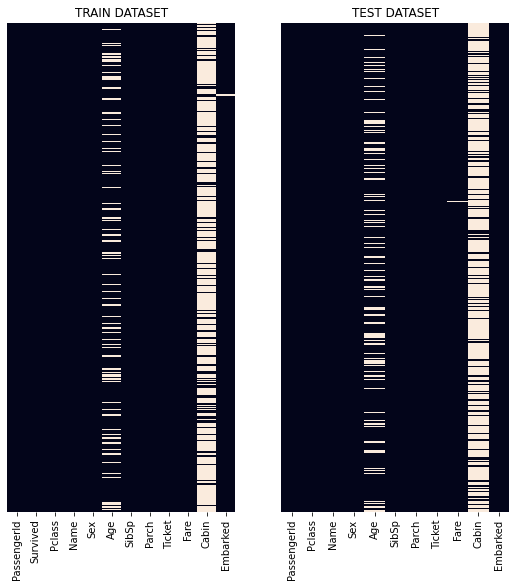

In [5]:
def heatmap_to_visualise_nans_in_train_test(train, test) -> None:
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(9,9))
    sns.heatmap(train.isnull(), ax=ax1, cbar=False)
    sns.heatmap(test.isnull(), ax=ax2, cbar=False, yticklabels=0)
    ax1.set_title('TRAIN DATASET')
    ax2.set_title('TEST DATASET')
    plt.show()

heatmap_to_visualise_nans_in_train_test(train, test)

*2.2. Tabulate missing data:*

(This is essential as the heatmap visualisation above is only useful as a general overview. It's not a fail-safe way to detect single missing values).

In [6]:
def _get_total_and_percentage_nans(df: pdf) -> pdf:
    total = df.isnull().sum().sort_values(ascending=False)
    # Note: `df.isnull().count()` simply used here to count total number of all rows (i.e. both True & False).
    percent = df.isnull().sum() / df.isnull().count() * 100
    percent = (round(percent, 1)).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', '%'])

def make_nan_stats_table(df_train: pdf, df_test: pdf) -> pdf:
    train_nan = _get_total_and_percentage_nans(df_train)
    test_nan = _get_total_and_percentage_nans(df_test)
    both = {'train': train_nan,'test': test_nan}
    table = pd.concat(both, axis=1)
    return table.sort_values(by=[('train', 'Total'), ('test', 'Total')], ascending=False, inplace=False)

table = make_nan_stats_table(train, test)
table.head()

train         test      
            Total     %  Total     %
Cabin         687  77.1  327.0  78.2
Age           177  19.9   86.0  20.6
Embarked        2   0.2    0.0   0.0
Fare            0   0.0    1.0   0.2
PassengerId     0   0.0    0.0   0.0

***2.3. Impute missing `Embarked` records:***

*As only 2 are missing out of 891 records and as there is one `Embarked` value that is much more common than the other two, I will replace the missing `Embarked` record with the most common one:*

In [7]:
# Ideally I'd want numerical measure of distribution, to allow selection of average method to be determined at runtime (hence mean() if 
# distribution is deemed to be normal enough (i.e. not too much skewness) and median() otherwise. 
# I'm not sure how to do this yet though. I did not get understandable results when using `scipy.stats.normaltest` in section 2.2.1.5, 
# in terms of how normal the distributions look on the visualisations as compared to the numbers (`p` and `k2`) returned by this lib.
# As such, the selection of mean() vs median() is currently based on manual visualisation of distributions. mode() is the only selection 
# for non-numerical datatypes.
# def impute_col_with_avg(ds: pdf, colname_to_impute: str, avg_method: str) -> pdf:
#     print(f'Before imputation: Number of missing values in column {colname_to_impute} is {ds[colname_to_impute].isnull().sum()}')
#     if avg_method == 'mode':
#         avg = ds[colname_to_impute].mode()[0]
#     elif avg_method == 'mean':
#         avg = ds[colname_to_impute].mean()
#     else:
#         avg = ds[colname_to_impute].median()
#     print(f'Average value to be used for imputation is {avg}')
#     ds[colname_to_impute].fillna(avg, inplace=True)
#     print(f'After imputation: Number of missing values in column {colname_to_impute} is {ds[colname_to_impute].isnull().sum()}')

# impute_col_with_avg(train, colname_to_impute='Embarked', avg_method='mode')

def impute_embarked_with_mode(ds: pdf) -> pdf:
    print(f"Before imputation: Number of missing values in Embarked is {ds['Embarked'].isnull().sum()}")
    most_common = ds['Embarked'].mode()[0]
    print(f'Average value to be used for imputation is {most_common}')
    ds['Embarked'].fillna(most_common, inplace=True)
    print(f"After imputation: Number of missing values in Embarked is {ds['Embarked'].isnull().sum()}")

impute_embarked_with_mode(train)

Before imputation: Number of missing values in Embarked is 2
Average value to be used for imputation is S
After imputation: Number of missing values in Embarked is 0


In [8]:
def determine_normality_of_distribution_by_pclass(df: pdf, alpha=0.1) -> None:
    # With alpha set to 0.1,  this measures 90% level of confidence.
    for sex in ['male', 'female']:
        for pclass in [1, 2, 3]:
            k2, p = stats.normaltest(df.loc[(df.Pclass == pclass) & (df.Sex == sex)]['Age'].dropna().to_list())
            print(f'p = {p}; k2 = {k2}')
            word = '' if p < alpha else 'NOT'
            print(f'wrt normality of `Age` distribution within `PClass` {pclass} for {sex}, the null hypothesis CAN{word} be rejected with 90% level of confidence.\n')

determine_normality_of_distribution_by_pclass(train)

p = 0.9964650009453282; k2 = 0.007082523855372656
wrt normality of `Age` distribution within `PClass` 1 for male, the null hypothesis CANNOT be rejected with 90% level of confidence.

p = 0.5269376422470439; k2 = 1.2813461266975494
wrt normality of `Age` distribution within `PClass` 2 for male, the null hypothesis CANNOT be rejected with 90% level of confidence.

p = 6.467013659008396e-06; k2 = 23.897592246786257
wrt normality of `Age` distribution within `PClass` 3 for male, the null hypothesis CAN be rejected with 90% level of confidence.

p = 0.12237391329921511; k2 = 4.201348116518041
wrt normality of `Age` distribution within `PClass` 1 for female, the null hypothesis CANNOT be rejected with 90% level of confidence.

p = 0.9761515868773057; k2 = 0.04827478041122385
wrt normality of `Age` distribution within `PClass` 2 for female, the null hypothesis CANNOT be rejected with 90% level of confidence.

p = 0.24286932553421842; k2 = 2.8304634705737675
wrt normality of `Age` distributio

***2.4. Impute missing `Age` records:***

*2.4.1. Visualise `Age` distributions*

This was partly done in preparation for deciding whether to use average `Age` values grouped by `Pclass` for data imputation. However, I am in fact going to use a Random Forest Regressor for the data imputation, so the following distribution visualisations and statistical tests are only shown here as a demonstration of some of the nice capabilities of `seaborn` as well as some useful statistical tools in `scipy` and `pandas`. 

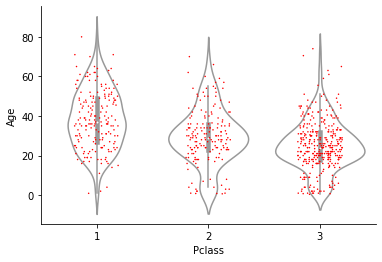

In [9]:
def visualise_by_pclass_violin_stripplots(df: pdf, colname: str) -> None:
    sns.violinplot(x='Pclass', y=colname, data=df, color='white')
    sns.stripplot(x='Pclass', y=colname, data=df, color="red", jitter=0.2, size=1.5)
    sns.despine()
    plt.show()

visualise_by_pclass_violin_stripplots(train, 'Age')

*2.4.1. Visualise `Age` distributions by `Pclass`:*

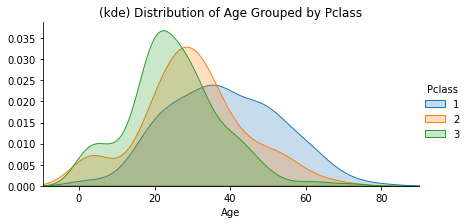

In [10]:
def visualise_distributions_kdeplot(df: pdf, var_of_interest: str, title=None, hue=None, col=None, bw_method=None, bw_adjust=1, 
                                    xlim_min=None, xlim_max=None, sharex=True, sharey=True) -> None:
    fig = sns.FacetGrid(df, hue=hue, col=col, aspect=2, height=3, sharex=sharex, sharey=sharey)
    bw_method='scott'if not bw_method else bw_method # alternatively `silverman`, a scalar constant or callable.
    fig.map(sns.kdeplot, var_of_interest, shade=True, bw_adjust=bw_adjust, bw_method=bw_method)
    if not col: # otherwise these 3 lines will override sharex=False, unwanted behaviour when you explicitly set it to False.
        xlim_min = (df[var_of_interest].min() - 10) if not xlim_min else xlim_min
        xlim_max = (df[var_of_interest].max() + 10) if not xlim_max else xlim_max
        fig.set(xlim=(xlim_min, xlim_max))
    if title: fig.set(title=title)
    fig.add_legend()
    plt.show()

# using default bandwidth adjust factor of 1
visualise_distributions_kdeplot(df=train, var_of_interest='Age', hue='Pclass', title='(kde) Distribution of Age Grouped by Pclass')

*2.4.2. How normal are `Age` distributions for each `Pclass` ?*

In [11]:
def determine_normality_of_distribution_by_pclass(df: pdf, alpha=0.01) -> None:
    # With alpha set to 0.01, this measures 99% level of confidence.
    for pclass in [1, 2, 3]:
        k2, p = stats.normaltest(df.loc[df.Pclass == pclass]['Age'].dropna())
        print(f'p = {p}; k2 = {k2}')
        word = '' if p < alpha else 'NOT'
        print(f'wrt normality of `Age` distribution within `PClass` {pclass}, the null hypothesis CAN{word} be rejected with 99% level of confidence.\n')

determine_normality_of_distribution_by_pclass(train)

p = 0.4315036357542328; k2 = 1.6809586852884995
wrt normality of `Age` distribution within `PClass` 1, the null hypothesis CANNOT be rejected with 99% level of confidence.

p = 0.561074873262309; k2 = 1.1558018368785472
wrt normality of `Age` distribution within `PClass` 2, the null hypothesis CANNOT be rejected with 99% level of confidence.

p = 2.5944880976350556e-05; k2 = 21.119072465384342
wrt normality of `Age` distribution within `PClass` 3, the null hypothesis CAN be rejected with 99% level of confidence.



*2.2.1.3. How well does `Age` correlate with `Pclass` and `Sex`?*

In [12]:
# Panda's `corr()` uses Pearson's correlation by default:
t1 = train[['Sex', 'Pclass', 'Age']]
round(t1.groupby(['Sex']).corr() * 100, 1)

Pclass    Age
Sex                         
female Pclass   100.0  -38.6
       Age      -38.6  100.0
male   Pclass   100.0  -39.3
       Age      -39.3  100.0

*2.2.1.4. Visualise `Age` distributions by `Pclass` and `Sex`:*

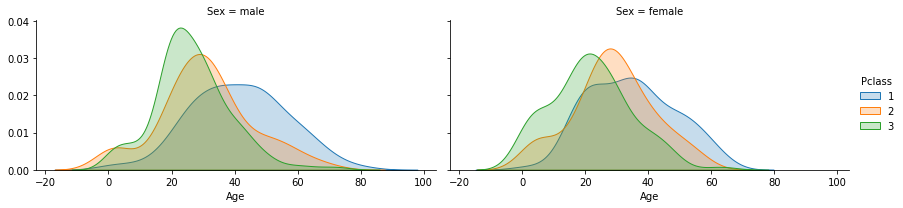

In [13]:
visualise_distributions_kdeplot(df=train, var_of_interest='Age', hue='Pclass', col='Sex')

*2.2.1.5. How normal are `Age` distributions for each `Pclass` and `Sex`?*

In [14]:
def determine_normality_of_distribution_by_pclass(df: pdf, alpha=0.1) -> None:
    # With alpha set to 0.1,  this measures 90% level of confidence.
    for sex in ['male', 'female']:
        for pclass in [1, 2, 3]:
            k2, p = stats.normaltest(df.loc[(df.Pclass == pclass) & (df.Sex == sex)]['Age'].dropna().to_list())
            print(f'p = {p}; k2 = {k2}')
            word = '' if p < alpha else 'NOT'
            print(f'wrt normality of `Age` distribution within `PClass` {pclass} for {sex}, the null hypothesis CAN{word} be rejected with 90% level of confidence.\n')

determine_normality_of_distribution_by_pclass(train)

p = 0.9964650009453282; k2 = 0.007082523855372656
wrt normality of `Age` distribution within `PClass` 1 for male, the null hypothesis CANNOT be rejected with 90% level of confidence.

p = 0.5269376422470439; k2 = 1.2813461266975494
wrt normality of `Age` distribution within `PClass` 2 for male, the null hypothesis CANNOT be rejected with 90% level of confidence.

p = 6.467013659008396e-06; k2 = 23.897592246786257
wrt normality of `Age` distribution within `PClass` 3 for male, the null hypothesis CAN be rejected with 90% level of confidence.

p = 0.12237391329921511; k2 = 4.201348116518041
wrt normality of `Age` distribution within `PClass` 1 for female, the null hypothesis CANNOT be rejected with 90% level of confidence.

p = 0.9761515868773057; k2 = 0.04827478041122385
wrt normality of `Age` distribution within `PClass` 2 for female, the null hypothesis CANNOT be rejected with 90% level of confidence.

p = 0.24286932553421842; k2 = 2.8304634705737675
wrt normality of `Age` distributio

* scipy.stats.normaltest` (D’Agostino & Pearson's test which combines skew and kurtosis) does not seem to be particularly helpful in this case. It seems no better than just looking at the shape of the distribution by eye.

##### ***As mentioned earlier (in 2.2.1.), I will impute missing `Age` records by machine learning. Before I do that though, I will engineer additional features (in part#3) which will be used for imputing missing `Age` (and also to be used in the subsequent predictive modeling of survival (in part#6)).***

*2.2.2. Remove `cabin`:*

In [15]:
def drop_cabin(df: pdf) -> pdf: 
    return df.drop('Cabin', axis=1, inplace=False) if 'Cabin' in df.columns else df

train = drop_cabin(train)
print(f'`train` now has {len(train.columns)} columns. \nThey are: {list(train.columns)}')

`train` now has 11 columns. 
They are: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']


*2.2.3. Remove `PassengerId`:*

In [16]:
def drop_passengerid(df: pdf) -> pdf:
    return df.drop('PassengerId', axis=1, inplace=False) if 'PassengerId' in df.columns else df

train = drop_passengerid(train)
print(f'`train` now has {len(train.columns)} columns. \nThey are: {list(train.columns)}')

`train` now has 10 columns. 
They are: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']


### ***3. Engineer additional features:***

***3.1. Extract title from `Name`:***

*3.1.1. The regex here is designed to extract titles from `Name` based entirely on the expectation that they always consist of a starting capital letter followed by lowercase letters and that they always end with a full-stop.*

*3.1.2. Combine special titles with one label and consolidate variations on female titles:*

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Jonkheer      1
Don           1
Sir           1
Ms            1
Capt          1
Mme           1
Lady          1
Countess      1
Name: Name, dtype: int64
`train` has 11 columns. 
They are: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked', 'title']


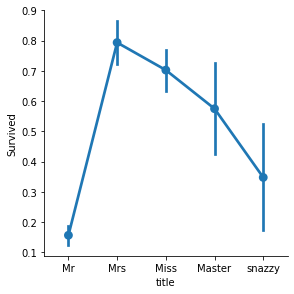

In [17]:
def _get_title(name: str) -> str:
    title_search = re.search(' ([A-Za-z]+)\.', name)
    return title_search.group(1) if title_search else ''

# Replace all special titles with one label. Replace some female title variations.
def _combine_special_titles(df: pdf) -> pdf:
    special_titles = ['Dr', 'Rev', 'Major', 'Col', 'Don', 'Lady', 'Countess', 'Capt', 'Jonkheer', 'Sir', 'Dona']
    miss = ['Mlle', 'Ms']
    mrs = ['Mme']
    # Titles signifying special social status changed to one label: 'special titles'
    df.loc[df['title'].isin(miss), 'title'] = 'Miss'
    df.loc[df['title'].isin(mrs), 'title'] = 'Mrs'
    df.loc[df['title'].isin(special_titles), 'title'] = 'snazzy'
    return df

def extract_title(df: pdf) -> pdf:
    titles = df.Name.apply(_get_title)
    print(pd.value_counts(titles))
    df['title'] = titles
    return _combine_special_titles(df)

train = extract_title(train)
print(f'`train` has {len(train.columns)} columns. \nThey are: {list(train.columns)}')

# visualise how the newly created title categories plot against survival
sns.catplot(data=train, x='title', y='Survived', kind='point', height=4)
plt.show()

***3.2. Extract the numeric part of `Ticket` to new feature `ticket_num`:***

*3.2. Extract the numeric part of `Ticket`:*

*`errors='coerce'` means NaN will be assigned to the corresponding `TicketNumber` record if `to_numeric()` fails (e.g. wherever the `Ticket` value contains no numbers at all).*

In [18]:
def extract_ticket_number(df: pdf) -> pdf:
    df['ticket_num'] = df.Ticket.str.extract('(\d{1,})', expand=True)
    df['ticket_num'] = pd.to_numeric(df['ticket_num'], errors='coerce')
    return df

train = extract_ticket_number(train)
print(f'`train` has {len(train.columns)} columns. \nThey are: {list(train.columns)}')

`train` has 12 columns. 
They are: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked', 'title', 'ticket_num']


*3.2.1. Impute missing `ticket_num`:*

*3.2.1.1. Visualise distributions of `ticket_num` by `Pclass` by violin & strip plots:*

(*In the absence of qualitative information on tickets, I guess there may be some association between tickets and `Pclass`. The following visualisation confirms there may be some level of association such that using `Pclass` will help impute missing `ticket_num` records.)*


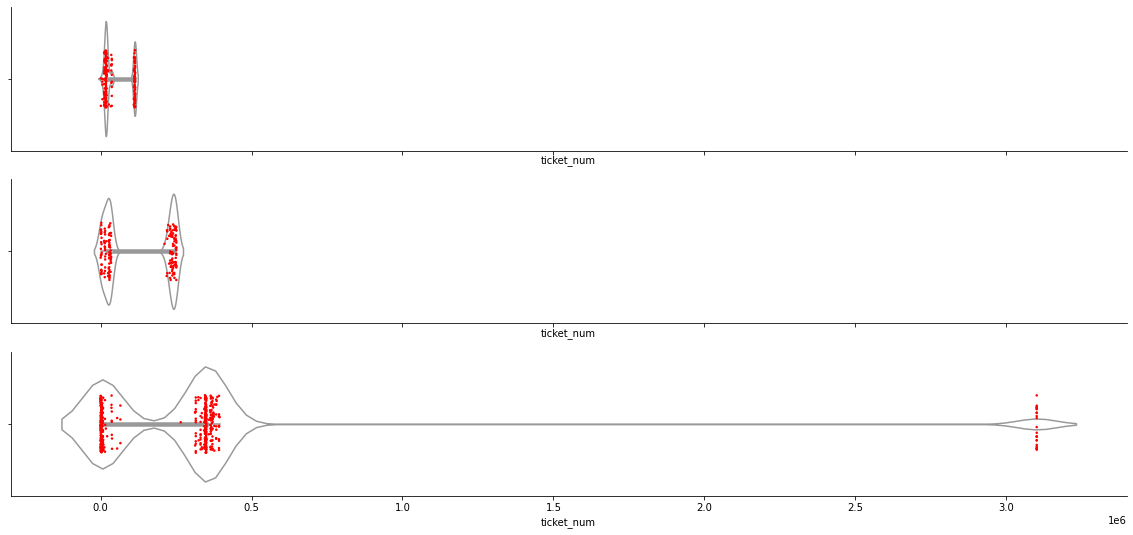

In [19]:
def visualise_horizontal_violinplots_per_pclass(df: pdf, sharex: bool, col_of_interest: str) -> None:
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=sharex, figsize=(20,9))
    sns.violinplot(x=col_of_interest, data=df[df.Pclass == 1], color='white', ax=ax1, bw=.1)
    sns.stripplot(x=col_of_interest, data=df[df.Pclass == 1],  color="red", jitter=0.2, size=2.5, ax=ax1)
    sns.violinplot(x=col_of_interest, data=df[df.Pclass == 2], color='white', ax=ax2, bw=.1)
    sns.stripplot(x=col_of_interest, data=df[df.Pclass == 2], color="red", jitter=0.2, size=2.5, ax=ax2)
    sns.violinplot(x=col_of_interest, data=df[df.Pclass == 3], color='white', ax=ax3, bw=.1)
    sns.stripplot(x=col_of_interest, data=df[df.Pclass == 3], color="red", jitter=0.2, size=2.5, ax=ax3)
    # ax3.set(xlim=(0,10))
    sns.despine()
    plt.show()
    
visualise_horizontal_violinplots_per_pclass(df=train, sharex=True, col_of_interest='ticket_num')

*3.2.1.2. Impute missing `ticket_num` according to the `Pclass`:*

In [20]:
def impute_ticket_num_with_mode_per_pclass(df: pdf) -> pdf:
    tick_num_mode_pclass = df.groupby('Pclass')['ticket_num'].agg(lambda x: pd.Series.mode(x).iat[0]).to_frame()
    tick_num_mode_pclass.reset_index(level=0, inplace=True)
    for pclass in [1,2,3]:
        df.loc[(df.Pclass == pclass) & (df.ticket_num.isna()), 'ticket_num'] = int(tick_num_mode_pclass.loc[tick_num_mode_pclass.Pclass == pclass]['ticket_num'])
    return df

# def impute_col_with_avg_per_pclass(df: pdf, colname: str, avg_method: str) -> pdf:
#     if avg_method == 'mode':
#         colname_avg_pclass = df.groupby('Pclass')[colname].agg(lambda x: pd.Series.mode(x).iat[0]).to_frame()
#     elif avg_method == 'median':
#         colname_avg_pclass = df.groupby('Pclass')[colname].agg(lambda x: pd.Series.median(x)).to_frame()
#     else:
#         colname_avg_pclass = df.groupby('Pclass')[colname].agg(lambda x: pd.Series.mean(x)).to_frame()
#     colname_avg_pclass.reset_index(level=0, inplace=True)
#     print(colname_avg_pclass.head())
#     for pclass in [1,2,3]:
#         df.loc[(df.Pclass == pclass) & (df[colname].isna()), colname] = int(colname_avg_pclass.loc[colname_avg_pclass.Pclass == pclass][colname])
#     return df

train = impute_ticket_num_with_mode_per_pclass(train)
# train = impute_col_with_avg_per_pclass(train, colname='ticket_num', avg_method='mode')

In [21]:
train_nan = _get_total_and_percentage_nans(train)
train_nan.sort_values(by=['Total'], ascending=False, inplace=True)
train_nan.head()

,Total,%
Age,177,19.9
Survived,0,0.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0


*3.2.1.2. Sanity-check that this imputation has not drastically altered the distributions by violin & strip plots:*

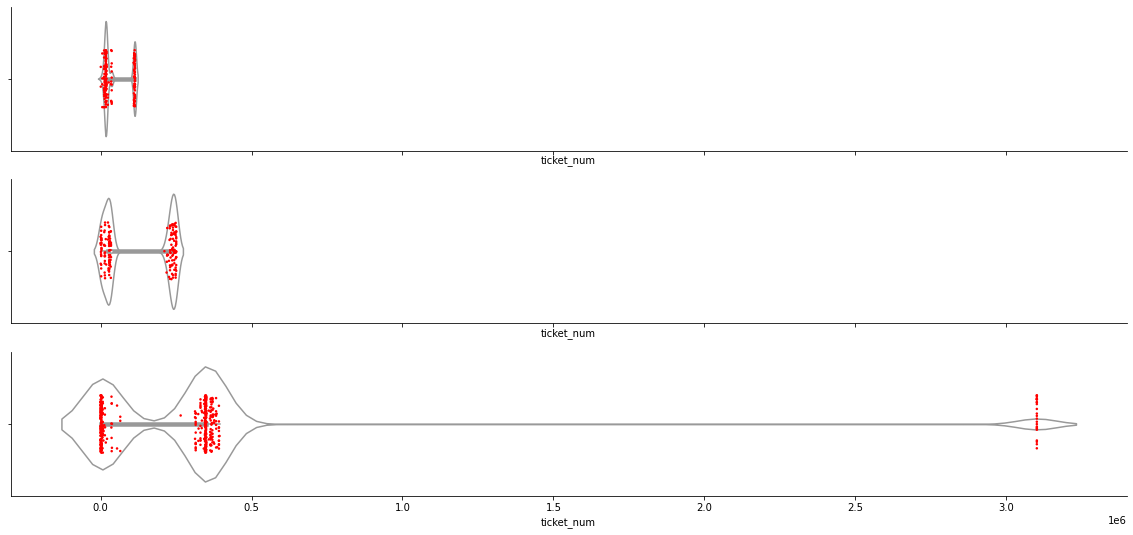

In [22]:
visualise_horizontal_violinplots_per_pclass(df=train, sharex=True, col_of_interest='ticket_num')

*3.2.2. The `ticket_num` violin plots highlight the categorical nature of the tickets. Hence, bin `ticket_num` into suitable groups:*

*3.2.2.1. Visualise to identify suitable binning values:* 

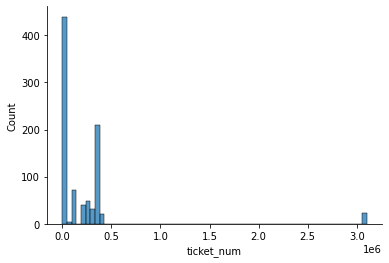

In [23]:
sns.histplot(x='ticket_num', data=train, bins=65)
sns.despine()
plt.show()

*3.2.2.2. Discretize `ticket_num`:*

In [24]:
# All commented out parts are an alternative (and more sophisticated) method for discretization (via sklearn)
# from sklearn.preprocessing import KBinsDiscretizer
# The alternative is this more manual approach. 

# def _discretize_and_plot(df, col_to_bin: str, n_bins: int, encode: str, strategy='quantile'):
def _discretize_and_plot(df: pdf, col_to_bin: str, bins: list, labels: list) -> pdf:
    new_col = col_to_bin.lower() + '_d'
    df[new_col] = pd.cut(df[col_to_bin], bins=bins, labels=labels)
#     # KBinsDiscretizer requires arguments of `n_bins` and `encode` (choice of ordinal, onehot or onehot-dense). 
#     # Optional parameter `strategy` is choice of `uniform`, `quantile` (default) or `kmeans`.
#     disc = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)
#     disc.fit_transform(df[col_to_bin])

    if 'Survived' in list(df.columns):
        cplt = sns.catplot(x=new_col, y='Survived', data=df, kind='point', height=4, aspect=2)
        cplt.set_xticklabels(rotation=45)
        plt.show()
    else:
        print('Survived not in df.columns, hence histplot is generated (instead of catplot against `Survived`.)')
        hplot = sns.histplot(x=new_col, data=df, bins=50)
        plt.setp(hplot.get_xticklabels(), rotation=45)
        sns.despine()
        plt.show()
    return df

In [25]:
## Alternatively, discretize without plotting anything
def _discretize(df: pdf, col_to_bin: str, bins: list, labels: list) -> pdf:
    new_col = col_to_bin.lower() + '_d'
    df[new_col] = pd.cut(df[col_to_bin], bins=bins, labels=labels)
    return df

# NOT COMPLETED:
# def _discretize(df, col_to_bin: str, n_bins: int, encode: str, strategy='quantile'):
#     # KBinsDiscretizer requires arguments of `n_bins` and `encode` (choice of ordinal, onehot or onehot-dense). 
#     # Optional parameter `strategy` is choice of `uniform`, `quantile` (default) or `kmeans`.
#     kbd = KBinsDiscretizer(n_bins=bins, encode=encode, strategy=strategy)
#     kbd.fit_transform(df[col_to_bin])
#     return df

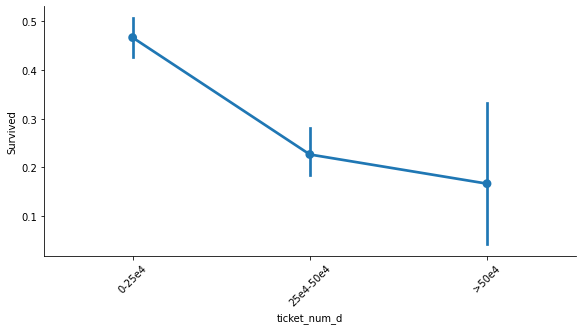

`train` has 13 columns. 
They are: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked', 'title', 'ticket_num', 'ticket_num_d']


In [26]:
def discretize_ticket_nums_and_plot(df: pdf) -> pdf:
    # tckt_num_bins = [-0.1,50000,100000,150000,200000,250000,300000,350000,400000,450000,500000,4000000]
    tckt_num_bins = [-0.1,250000,500000,4000000]
    # tckt_num_bin_labels = ['0-5e4', '5e4-10e4', '10e4-15e4', '15e4-20e4', '20e4-25e4', '25e4-30e4', '30e4-35e4', '35e4-40e4', '40e4-45e4', '45e4-50e4', '>50e4']
    tckt_num_bin_labels = ['0-25e4', '25e4-50e4', '>50e4']
    return _discretize_and_plot(df, col_to_bin='ticket_num', bins=tckt_num_bins, labels=tckt_num_bin_labels)

discretize_ticket_nums_and_plot(train)
print(f'`train` has {len(train.columns)} columns. \nThey are: {list(train.columns)}')

In [27]:
# Or without plotting:
def discretize_ticket_nums(df: pdf) -> pdf:
    tckt_num_bins = [-0.1,250000,500000,4000000]
    tckt_num_bin_labels = ['0-25e4', '25e4-50e4', '>50e4']
    return _discretize(df, col_to_bin='ticket_num', bins=tckt_num_bins, labels=tckt_num_bin_labels)

***3.3. Extract & discretize family size from `SibSp` and `Parch`:***

Empty DataFrame
Columns: [Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Embarked, title, ticket_num, ticket_num_d, fam_size]
Index: []


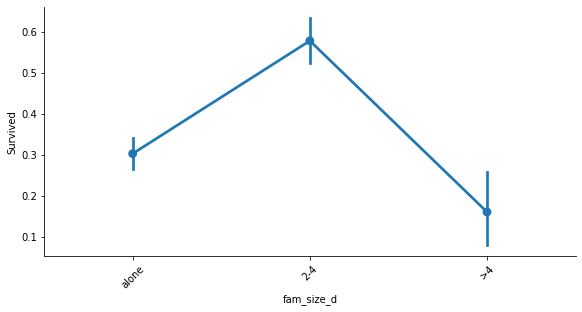

['2-4', 'alone', '>4']
Categories (3, object): ['alone' < '2-4' < '>4']
alone    537
2-4      292
>4        62
Name: fam_size_d, dtype: int64
`train` has 15 columns. 
They are: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked', 'title', 'ticket_num', 'ticket_num_d', 'fam_size', 'fam_size_d']


In [28]:
def extract_fam_size_discretize_and_plot(df: pdf) -> pdf:
    df['fam_size'] = df['SibSp'] + df['Parch'] + 1
    # print(df['fam_size'].value_counts())
    print(df[df['fam_size'].isnull()])
    return _discretize_and_plot(df, col_to_bin='fam_size', bins=[-0.1,1,4,20], labels=['alone', '2-4', '>4'])

train = extract_fam_size_discretize_and_plot(train)

print(train['fam_size_d'].unique())
print(train['fam_size_d'].value_counts())
print(f'`train` has {len(train.columns)} columns. \nThey are: {list(train.columns)}')

In [29]:
# Or without plotting anything
def extract_fam_size_and_discretize(df: pdf) -> pdf:
    df['fam_size'] = df['SibSp'] + df['Parch'] + 1
    print(df[df['fam_size'].isnull()])
    return _discretize(df, col_to_bin='fam_size', bins=[-0.1,1,4,20], labels=['alone', '2-4', '>4'])

***3.4. Extract & discretize lengths of names:***

*3.4.1. Bin name lengths into four categories and plot with `sns.catplot()` (suited to looking at the frequencies of categories)*

*(The apparent correlation alluded to by the following catplot is (between the length of a passenger's name and their survival stats) is likely to be partly due to the inclreased length of names with distinguished titles preceeding them.)*

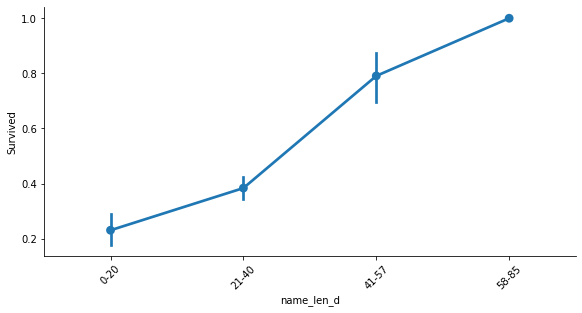

`train` has 17 columns. 
They are: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked', 'title', 'ticket_num', 'ticket_num_d', 'fam_size', 'fam_size_d', 'name_len', 'name_len_d']


In [30]:
def extract_name_length_discretize_and_plot(df: pdf) -> pdf:
    df['name_len'] = df.Name.str.len()
    name_len_bins = [-0.1, 20, 40, 57, 85]
    name_len_bin_labels = ['0-20', '21-40', '41-57', '58-85']
    return _discretize_and_plot(df, col_to_bin='name_len', bins=name_len_bins, labels=name_len_bin_labels)

train = extract_name_length_discretize_and_plot(train)

print(f'`train` has {len(train.columns)} columns. \nThey are: {list(train.columns)}')

In [31]:
# Or without plotting anything
def extract_name_length_and_discretize(df: pdf) -> pdf:
    df['name_len'] = df.Name.str.len()
    name_len_bins = [-0.1, 20, 40, 57, 85]
    name_len_bin_labels = ['0-20', '21-40', '41-57', '58-85']
    return _discretize(df, col_to_bin='name_len', bins=name_len_bins, labels=name_len_bin_labels)

***3.5. Discretize `Fare`:***

*3.5.1. Visualise to evaluate what bins might be suitable:*

*3.5.1.1. Visualise with KDE plot and low bandwidth adjust value to see more detail (and per `Pclass`):*

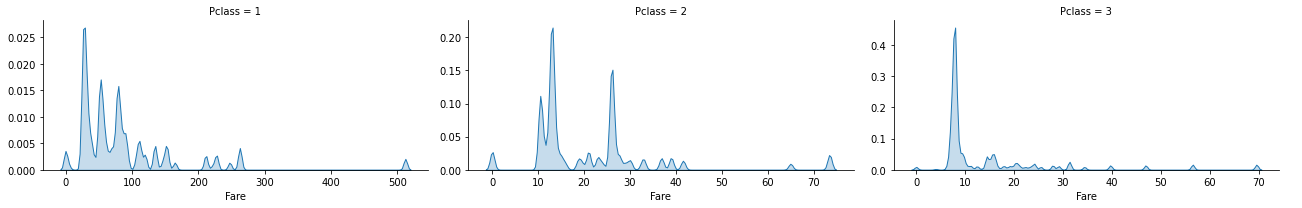

In [32]:
# using lower bandwidth adjust factor to view distribution with higher granularity
visualise_distributions_kdeplot(df=train, var_of_interest='Fare', col='Pclass', sharex=False, sharey=False, bw_adjust=0.1)

*3.5.1.2. Visualise with histograms (and per `Pclass`):*

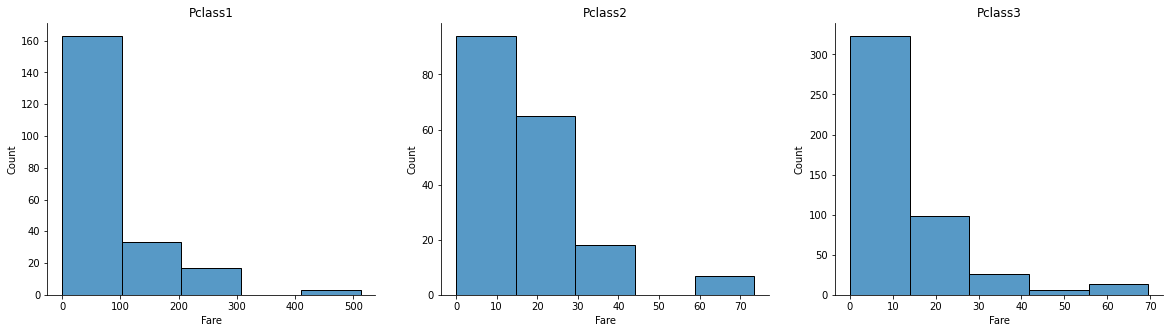

In [33]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
sns.histplot(x='Fare', data=train[train.Pclass == 1], bins=5, ax=ax1)
sns.histplot(x='Fare', data=train[train.Pclass == 2], bins=5, ax=ax2)
sns.histplot(x='Fare', data=train[(train.ticket_num < 500000) & (train.Pclass == 3)], bins=5, ax=ax3)
ax1.set_title('Pclass1')
ax2.set_title('Pclass2')
ax3.set_title('Pclass3')
sns.despine()
plt.show()

*3.5.1.3. Visualise with histogram of whole dataset:*

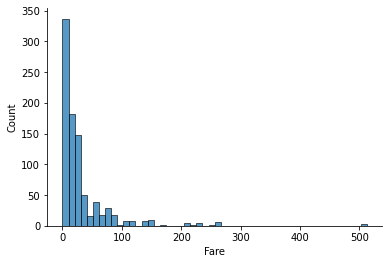

In [34]:
hplot = sns.histplot(x='Fare', data=train, bins=50)
sns.despine()
plt.show()


*3.5.2. Discretize by manually-selected bin sizes which seem suitable (based loosely on kde plot and histograms):*

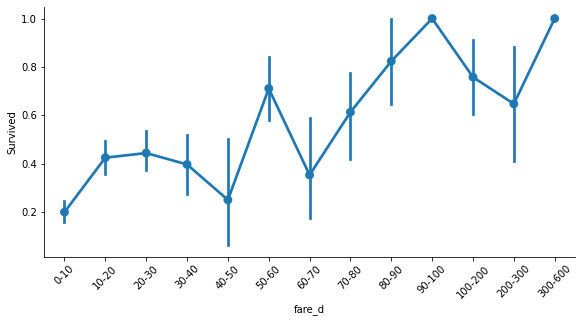

`train` has 18 columns. 
They are: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked', 'title', 'ticket_num', 'ticket_num_d', 'fam_size', 'fam_size_d', 'name_len', 'name_len_d', 'fare_d']


In [35]:
def discretize_fare_and_plot(df: pdf) -> pdf:
    fare_bins = [-0.1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 600]
    fare_bin_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100-200', '200-300', '300-600']
    return _discretize_and_plot(df, col_to_bin='Fare', bins=fare_bins, labels=fare_bin_labels)

train = discretize_fare_and_plot(train)

print(f'`train` has {len(train.columns)} columns. \nThey are: {list(train.columns)}')
# NOTE: those bins with larger error bars seem to atleast partly to be caused by smaller sample sizes.

In [36]:
# Or without plotting anything
def discretize_fare(df: pdf) -> pdf:
    fare_bins = [-0.1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 600]
    fare_bin_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100-200', '200-300', '300-600']
    return _discretize(df, col_to_bin='Fare', bins=fare_bins, labels=fare_bin_labels)

#### *...going back to 2.2. (armed with additional features)...*

***2.2. Impute missing `Age` records:***

*2.2.1. Selecting variables I will use:*

### *2.2.2. **Encoding** - Convert any ordinal and categorical variables to a valid numeric form:*

*2.2.2.1. Generate the one-hot encoder using train dataset, to be used for performing the one-hot-encoding on both train and test datasets (the latter at the end of notebook):*

In [37]:
from sklearn.preprocessing import OneHotEncoder

# NB: This is hard-coded to train the encoder using `train` dataset. 
# This same trained encoder should then be used to transform the `test` dataset, 
# (which is done in part#7).
def generate_one_hot_encoder_for_sex_title_embarked_name_len_d_fare_d_ticket_num_d(train: pdf): 
    encoder222 = OneHotEncoder(handle_unknown="ignore", sparse=False)
#   encoder = OneHotEncoder(handle_unknown="ignore", drop='first', sparse=False)
    encoder222.fit(train[['Sex', 'title', 'Embarked', 'name_len_d', 'fare_d', 'ticket_num_d']])
    return encoder222

encoder222 = generate_one_hot_encoder_for_sex_title_embarked_name_len_d_fare_d_ticket_num_d(train)

*2.2.2.2. Manually encode `fam_size_d` and apply one-hot-encoder on `Sex`, `title`, `Embarked`, `name_len_d`, `fare_d` & `ticket_num_d` (on train dataset):*

In [38]:
# The engineered feature fam_size_d is ordinal but the order cannot be inferred by the sklearn encoders because
# they are strings, therefore I'm hard-coding the encoding:
def _hard_encode_fam_size_d(df: pdf) -> pdf:
    df['fam_size_d'] = df['fam_size_d'].map({'alone': 0, '2-4': 1, '>4': 2})
    return df

def _apply_one_hot_encoder_on_sex_title_embarked_name_len_d_fare_d_ticket_num_d(df: pdf, encdr) -> pdf:
    return encdr.transform(df[['Sex', 'title', 'Embarked', 'name_len_d', 'fare_d', 'ticket_num_d']])

def encode_non_numeric_features(df: pdf, encdr) -> pdf:
    df1 = _hard_encode_fam_size_d(df)
    onehot_ndarray = _apply_one_hot_encoder_on_sex_title_embarked_name_len_d_fare_d_ticket_num_d(df1, encdr)
    df2 = pd.DataFrame(onehot_ndarray, columns=encdr.get_feature_names(['Sex', 'title', 'Embarked', 'name_len_d', 'fare_d', 'ticket_num_d']))
    return pd.concat([df1, df2], axis=1)

train_encoded = encode_non_numeric_features(train, encdr=encoder222)

print(f'`train_encoded` has {len(train_encoded.columns)} columns. \nThey are: {list(train_encoded.columns)}')
train_encoded.iloc[:2,9:].head()

`train_encoded` has 48 columns. 
They are: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked', 'title', 'ticket_num', 'ticket_num_d', 'fam_size', 'fam_size_d', 'name_len', 'name_len_d', 'fare_d', 'Sex_female', 'Sex_male', 'title_Master', 'title_Miss', 'title_Mr', 'title_Mrs', 'title_snazzy', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'name_len_d_0-20', 'name_len_d_21-40', 'name_len_d_41-57', 'name_len_d_58-85', 'fare_d_0-10', 'fare_d_10-20', 'fare_d_100-200', 'fare_d_20-30', 'fare_d_200-300', 'fare_d_30-40', 'fare_d_300-600', 'fare_d_40-50', 'fare_d_50-60', 'fare_d_60-70', 'fare_d_70-80', 'fare_d_80-90', 'fare_d_90-100', 'ticket_num_d_0-25e4', 'ticket_num_d_25e4-50e4', 'ticket_num_d_>50e4']


,Embarked,title,ticket_num,ticket_num_d,fam_size,fam_size_d,name_len,name_len_d,fare_d,Sex_female,...,fare_d_300-600,fare_d_40-50,fare_d_50-60,fare_d_60-70,fare_d_70-80,fare_d_80-90,fare_d_90-100,ticket_num_d_0-25e4,ticket_num_d_25e4-50e4,ticket_num_d_>50e4
0,S,Mr,5.0,0-25e4,2,1,23,21-40,0-10,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,C,Mrs,17599.0,0-25e4,2,1,51,41-57,70-80,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


*2.2.3. Double-check there are no more missing values in any non-Age variables, otherwise Random Forest Regressor will fail (if any NaNs):*

In [39]:
def check_for_nans_in_non_age_variables(df: pdf) -> None:
    df = df.loc[:, df.columns != 'Age']
    print(f'NaNs = {df[df.isnull().any(axis=1)]}')
    
check_for_nans_in_non_age_variables(train_encoded)

NaNs = Empty DataFrame
Columns: [Survived, Pclass, Name, Sex, SibSp, Parch, Ticket, Fare, Embarked, title, ticket_num, ticket_num_d, fam_size, fam_size_d, name_len, name_len_d, fare_d, Sex_female, Sex_male, title_Master, title_Miss, title_Mr, title_Mrs, title_snazzy, Embarked_C, Embarked_Q, Embarked_S, name_len_d_0-20, name_len_d_21-40, name_len_d_41-57, name_len_d_58-85, fare_d_0-10, fare_d_10-20, fare_d_100-200, fare_d_20-30, fare_d_200-300, fare_d_30-40, fare_d_300-600, fare_d_40-50, fare_d_50-60, fare_d_60-70, fare_d_70-80, fare_d_80-90, fare_d_90-100, ticket_num_d_0-25e4, ticket_num_d_25e4-50e4, ticket_num_d_>50e4]
Index: []

[0 rows x 47 columns]


In [40]:
print(f'`train_encoded` has {len(train_encoded.columns)} columns. \nThey are: {list(train_encoded.columns)}')

`train_encoded` has 48 columns. 
They are: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked', 'title', 'ticket_num', 'ticket_num_d', 'fam_size', 'fam_size_d', 'name_len', 'name_len_d', 'fare_d', 'Sex_female', 'Sex_male', 'title_Master', 'title_Miss', 'title_Mr', 'title_Mrs', 'title_snazzy', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'name_len_d_0-20', 'name_len_d_21-40', 'name_len_d_41-57', 'name_len_d_58-85', 'fare_d_0-10', 'fare_d_10-20', 'fare_d_100-200', 'fare_d_20-30', 'fare_d_200-300', 'fare_d_30-40', 'fare_d_300-600', 'fare_d_40-50', 'fare_d_50-60', 'fare_d_60-70', 'fare_d_70-80', 'fare_d_80-90', 'fare_d_90-100', 'ticket_num_d_0-25e4', 'ticket_num_d_25e4-50e4', 'ticket_num_d_>50e4']


*2.2.4. Having encoded the non-numerical variables into numerical ones, remove the original non-numerical variables otherwise Random Forest Regressor will fail:*

In [41]:
def drop_non_numerical_variables(df: pdf) -> pdf:
    non_numeric_cols = list(df.select_dtypes(exclude=['int64', 'float64']).columns)
    print(f'Non-numeric columns being dropped: {non_numeric_cols}')
    return df.drop(non_numeric_cols, axis=1, inplace=False)

train_for_rfr = drop_non_numerical_variables(train_encoded)
print(f'\nResulting dataframe has columns: {list(train_for_rfr.columns)}')

Non-numeric columns being dropped: ['Name', 'Sex', 'Ticket', 'Embarked', 'title', 'ticket_num_d', 'fam_size_d', 'name_len_d', 'fare_d']

Resulting dataframe has columns: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'ticket_num', 'fam_size', 'name_len', 'Sex_female', 'Sex_male', 'title_Master', 'title_Miss', 'title_Mr', 'title_Mrs', 'title_snazzy', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'name_len_d_0-20', 'name_len_d_21-40', 'name_len_d_41-57', 'name_len_d_58-85', 'fare_d_0-10', 'fare_d_10-20', 'fare_d_100-200', 'fare_d_20-30', 'fare_d_200-300', 'fare_d_30-40', 'fare_d_300-600', 'fare_d_40-50', 'fare_d_50-60', 'fare_d_60-70', 'fare_d_70-80', 'fare_d_80-90', 'fare_d_90-100', 'ticket_num_d_0-25e4', 'ticket_num_d_25e4-50e4', 'ticket_num_d_>50e4']


***2.2.5. Train Random Forest Regressor model and predict missing `Age` values:***

In [42]:
from sklearn.ensemble import RandomForestRegressor

def impute_missing_age_using_rfr(df: pdf) -> pdf:
    for_training = df.loc[df.Age.notnull()]
    for_predicting = df.loc[df.Age.isnull()]
    y = for_training['Age'].to_numpy()
    X = for_training.loc[:, for_training.columns != 'Age'].to_numpy()
    trained_rfr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    trained_rfr.fit(X, y)
    Xpred = for_predicting.loc[:, for_training.columns != 'Age'].to_numpy()
    predicted_values = trained_rfr.predict(Xpred)
    df.loc[df['Age'].isnull(), 'Age'] = predicted_values
    return df

# Make copy before imputation for sanity-check comparison with the dataset after data imputation. 
train_for_rfr_b4 = train_for_rfr.copy()
train_with_imputed_age = impute_missing_age_using_rfr(train_for_rfr)

train['Age'] = train_encoded['Age'] = train_with_imputed_age['Age']

print(f'`train_encoded` has {len(train_encoded.columns)} columns. \nThey are: {list(train_encoded.columns)}')

`train_encoded` has 48 columns. 
They are: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked', 'title', 'ticket_num', 'ticket_num_d', 'fam_size', 'fam_size_d', 'name_len', 'name_len_d', 'fare_d', 'Sex_female', 'Sex_male', 'title_Master', 'title_Miss', 'title_Mr', 'title_Mrs', 'title_snazzy', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'name_len_d_0-20', 'name_len_d_21-40', 'name_len_d_41-57', 'name_len_d_58-85', 'fare_d_0-10', 'fare_d_10-20', 'fare_d_100-200', 'fare_d_20-30', 'fare_d_200-300', 'fare_d_30-40', 'fare_d_300-600', 'fare_d_40-50', 'fare_d_50-60', 'fare_d_60-70', 'fare_d_70-80', 'fare_d_80-90', 'fare_d_90-100', 'ticket_num_d_0-25e4', 'ticket_num_d_25e4-50e4', 'ticket_num_d_>50e4']


In [43]:
print(f'`train_encoded` has {len(train_encoded.columns)} columns. \nThey are: {list(train_encoded.columns)}')

`train_encoded` has 48 columns. 
They are: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked', 'title', 'ticket_num', 'ticket_num_d', 'fam_size', 'fam_size_d', 'name_len', 'name_len_d', 'fare_d', 'Sex_female', 'Sex_male', 'title_Master', 'title_Miss', 'title_Mr', 'title_Mrs', 'title_snazzy', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'name_len_d_0-20', 'name_len_d_21-40', 'name_len_d_41-57', 'name_len_d_58-85', 'fare_d_0-10', 'fare_d_10-20', 'fare_d_100-200', 'fare_d_20-30', 'fare_d_200-300', 'fare_d_30-40', 'fare_d_300-600', 'fare_d_40-50', 'fare_d_50-60', 'fare_d_60-70', 'fare_d_70-80', 'fare_d_80-90', 'fare_d_90-100', 'ticket_num_d_0-25e4', 'ticket_num_d_25e4-50e4', 'ticket_num_d_>50e4']


*2.2.6. Confirm no missing `Age` records remain (with heatmap):*

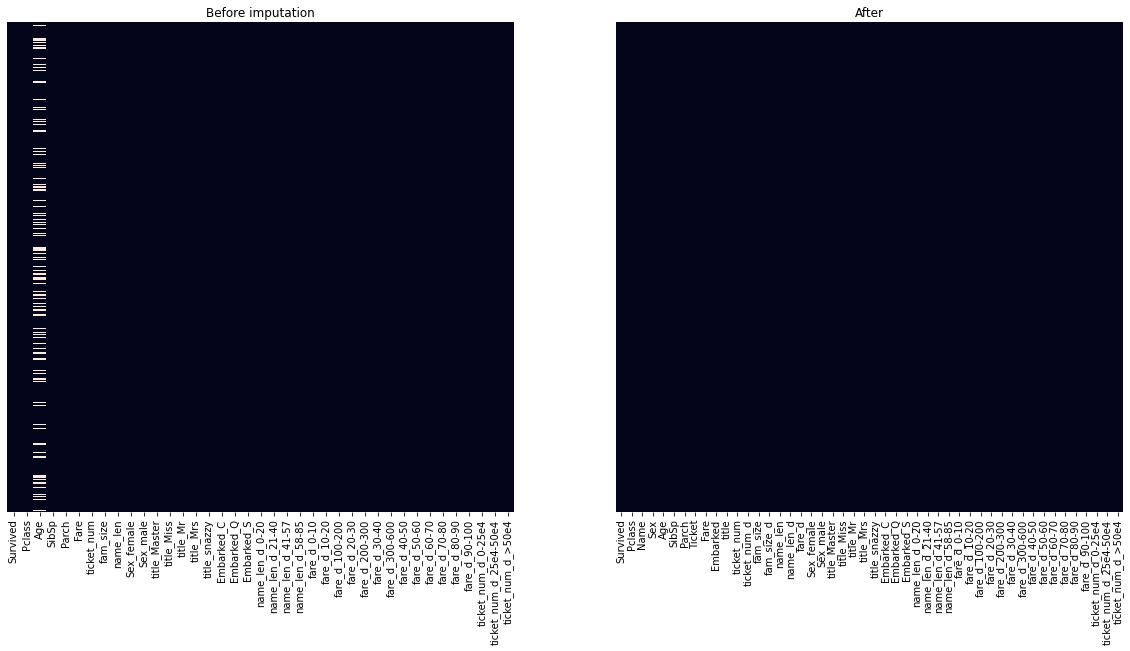

In [44]:
def visualise_missing_values_before_after_imputation(before_df: pdf, after_df: pdf) -> None:
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20,9))
    sns.heatmap(before_df.isnull(), ax=ax1, cbar=False)
    sns.heatmap(after_df.isnull(), ax=ax2, cbar=False, yticklabels=0)
    ax1.set_title('Before imputation')
    ax2.set_title('After')
    plt.show()

visualise_missing_values_before_after_imputation(train_for_rfr_b4, train_encoded)

*2.2.7. Pre- vs post-imputation sanity-checks by visualisations of `Age` distributions before and after imputation:*

*2.2.7.1. `Age` distribution is not drastically altered by the data imputation:*

kdeplot, with default bandwidth of 1.0:


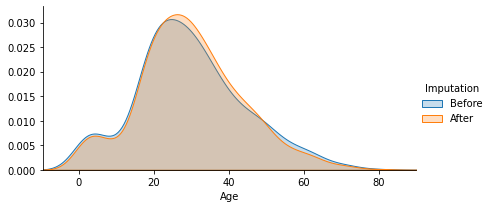

kdeplot, using lower bandwidth of 0.2:


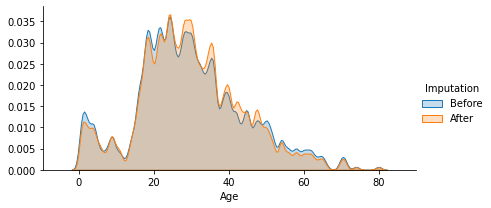

In [45]:
def visualise_age_kdeplot_before_after_imputation(before_df: pdf, after_df: pdf) -> None:
    # make copies to prevent additional column being added to train_encoded
    before_copy = before_df.copy()
    after_copy = after_df.copy()
    before_copy['Imputation'] = 'Before'
    after_copy['Imputation'] = 'After'
    before_after = pd.concat([before_copy, after_copy])
    print('kdeplot, with default bandwidth of 1.0:')
    visualise_distributions_kdeplot(df=before_after, var_of_interest='Age', hue='Imputation')
    print('kdeplot, using lower bandwidth of 0.2:')
    visualise_distributions_kdeplot(df=before_after, var_of_interest='Age', hue='Imputation', bw_adjust=0.2)
    
visualise_age_kdeplot_before_after_imputation(train_for_rfr_b4, train_encoded)

*2.2.7.2. ..viewed per `Pclass`, `Age` distribution is not drastically altered by the data imputation:*

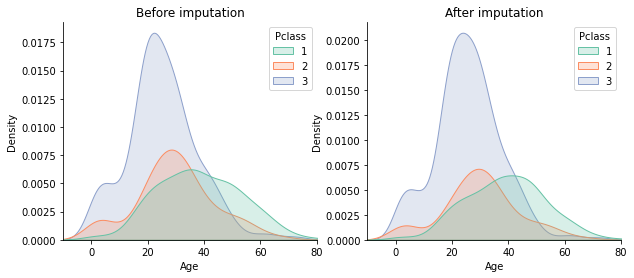

In [46]:
def visualise_age_per_class_kdeplot_before_after_imputation(before_df: pdf, after_df: pdf) -> None:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    sns.kdeplot(x='Age',data=before_df, hue='Pclass', shade=True, ax=ax1, palette="Set2")
    sns.kdeplot(x='Age',data=after_df, hue='Pclass', shade=True, ax=ax2, palette="Set2")
    ax1.set_title('Before imputation')
    ax2.set_title('After imputation')
    oldest = before_df['Age'].max()
    ax1.set(xlim=(-10, oldest))
    oldest = after_df['Age'].max()
    ax2.set(xlim=(-10, oldest))
    sns.despine()
    plt.show()
    
visualise_age_per_class_kdeplot_before_after_imputation(train_for_rfr_b4, train_encoded)

(returning to feature engineering)

***3.6. Discretize `Age`:***

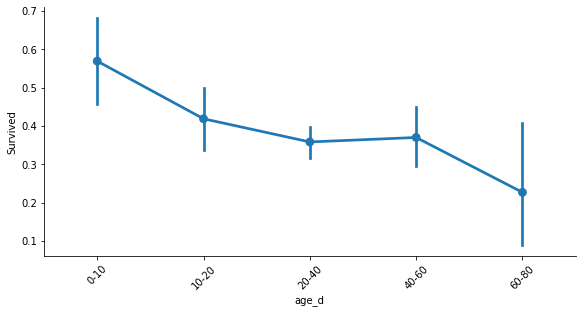

`train_encoded` has 49 columns. 
They are: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked', 'title', 'ticket_num', 'ticket_num_d', 'fam_size', 'fam_size_d', 'name_len', 'name_len_d', 'fare_d', 'Sex_female', 'Sex_male', 'title_Master', 'title_Miss', 'title_Mr', 'title_Mrs', 'title_snazzy', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'name_len_d_0-20', 'name_len_d_21-40', 'name_len_d_41-57', 'name_len_d_58-85', 'fare_d_0-10', 'fare_d_10-20', 'fare_d_100-200', 'fare_d_20-30', 'fare_d_200-300', 'fare_d_30-40', 'fare_d_300-600', 'fare_d_40-50', 'fare_d_50-60', 'fare_d_60-70', 'fare_d_70-80', 'fare_d_80-90', 'fare_d_90-100', 'ticket_num_d_0-25e4', 'ticket_num_d_25e4-50e4', 'ticket_num_d_>50e4', 'age_d']


In [47]:
def discretize_age_and_plot(df: pdf) -> pdf:
    max_age = train_encoded.Age.max()
    age_bins = [0, 10, 20, 40, 60, max_age]
    age_bin_labels = ['0-10', '10-20', '20-40', '40-60', '60-80']
    return _discretize_and_plot(df, col_to_bin='Age', bins=age_bins, labels=age_bin_labels)

train = discretize_age_and_plot(train)
train_encoded['age_d'] = train['age_d']
print(f'`train_encoded` has {len(train_encoded.columns)} columns. \nThey are: {list(train_encoded.columns)}')

In [48]:
# or without plotting anything:
def discretize_age(df: pdf) -> pdf:
    max_age = df.Age.max()
    age_bins = [0, 10, 20, 40, 60, max_age]
    age_bin_labels = ['0-10', '10-20', '20-40', '40-60', '60-80']
    return _discretize(df, col_to_bin='Age', bins=age_bins, labels=age_bin_labels)

train_encoded = discretize_age(train_encoded)
print(f'`train_encoded` has {len(train_encoded.columns)} columns. \nThey are: {list(train_encoded.columns)}')

`train_encoded` has 49 columns. 
They are: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked', 'title', 'ticket_num', 'ticket_num_d', 'fam_size', 'fam_size_d', 'name_len', 'name_len_d', 'fare_d', 'Sex_female', 'Sex_male', 'title_Master', 'title_Miss', 'title_Mr', 'title_Mrs', 'title_snazzy', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'name_len_d_0-20', 'name_len_d_21-40', 'name_len_d_41-57', 'name_len_d_58-85', 'fare_d_0-10', 'fare_d_10-20', 'fare_d_100-200', 'fare_d_20-30', 'fare_d_200-300', 'fare_d_30-40', 'fare_d_300-600', 'fare_d_40-50', 'fare_d_50-60', 'fare_d_60-70', 'fare_d_70-80', 'fare_d_80-90', 'fare_d_90-100', 'ticket_num_d_0-25e4', 'ticket_num_d_25e4-50e4', 'ticket_num_d_>50e4', 'age_d']


In [49]:
def generate_one_hot_encoder_for_age_d(df: pdf) -> pdf:
    encoder_age_d = OneHotEncoder(handle_unknown="ignore", sparse=False)
#   encoder = OneHotEncoder(handle_unknown="ignore", drop='first', sparse=False)
    encoder_age_d.fit(df[['age_d']])
    return encoder_age_d

encoder_age_d = generate_one_hot_encoder_for_age_d(train_encoded)

In [50]:
def apply_one_hot_encoder_age_d(df: pdf, encdr) -> pdf:
    onehot_ndarray = encdr.transform(df[['age_d']])
    df2 = pd.DataFrame(onehot_ndarray, columns=encdr.get_feature_names(['age_d']))
    return pd.concat([df, df2], axis=1)

train_encoded = apply_one_hot_encoder_age_d(df=train_encoded, encdr=encoder_age_d)
 
print(f'`train_encoded` has {len(train_encoded.columns)} columns. \nThey are: {list(train_encoded.columns)}')

`train_encoded` has 54 columns. 
They are: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked', 'title', 'ticket_num', 'ticket_num_d', 'fam_size', 'fam_size_d', 'name_len', 'name_len_d', 'fare_d', 'Sex_female', 'Sex_male', 'title_Master', 'title_Miss', 'title_Mr', 'title_Mrs', 'title_snazzy', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'name_len_d_0-20', 'name_len_d_21-40', 'name_len_d_41-57', 'name_len_d_58-85', 'fare_d_0-10', 'fare_d_10-20', 'fare_d_100-200', 'fare_d_20-30', 'fare_d_200-300', 'fare_d_30-40', 'fare_d_300-600', 'fare_d_40-50', 'fare_d_50-60', 'fare_d_60-70', 'fare_d_70-80', 'fare_d_80-90', 'fare_d_90-100', 'ticket_num_d_0-25e4', 'ticket_num_d_25e4-50e4', 'ticket_num_d_>50e4', 'age_d', 'age_d_0-10', 'age_d_10-20', 'age_d_20-40', 'age_d_40-60', 'age_d_60-80']


### ***4. EXPLORE CORRELATIONS WITH SURVIVAL***

***This part doesn't alter or even really inform the subsequent ML strategy. It's just for me to compare with what the machine learning algorithms find in section#6) and to demonstrate some nice visualisations with seaborn and some useful statistical tests with scipy:***

*4.1. Looking at correlations between features using 3 different statistical tests (`Spearman's rank correlation coefficient`, `Pearson correlation coefficient` & `Kendall's rank correlation coefficient`) as well as their combination. These python implementations are taken from `dython` https://github.com/shakedzy/dython. (I did this instead of installing and importing `dython` as Kaggle does not currently appear to permit installing libraries):*

In [51]:
train_encoded_part4 = drop_non_numerical_variables(train_encoded)

Non-numeric columns being dropped: ['Name', 'Sex', 'Ticket', 'Embarked', 'title', 'ticket_num_d', 'fam_size_d', 'name_len_d', 'fare_d', 'age_d']


In [52]:
# Apply statistical correlation calculations to all numerical attributes for numerical indicators:
spearmans = []; pearsons = []; kendalls = [];  means = []

params = list(train_encoded_part4.columns)
params.remove('Survived')
for param in params:
    sp_param, _ = stats.spearmanr(train_encoded_part4[param], train_encoded_part4['Survived'])
    pe_param, _ = stats.pearsonr(train_encoded_part4[param], train_encoded_part4['Survived'])
    ke_param, _ = stats.kendalltau(train_encoded_part4[param], train_encoded_part4['Survived'])
    mean = pystats.mean([sp_param, pe_param, ke_param])
    spearmans.append(abs(round(sp_param, 3) * 100))
    pearsons.append(abs(round(pe_param, 3) * 100))
    kendalls.append(abs(round(ke_param, 3) * 100))
    means.append(abs(round(mean, 3) * 100))

df = pd.DataFrame(data= {'Spearman':spearmans, 'Pearson': pearsons, 'Kendall': kendalls, 'mean': means}, index=params)
df.sort_values(by='Spearman', inplace=True, ascending=False)
df

,Spearman,Pearson,Kendall,mean
title_Mr,54.9,54.9,54.9,54.9
Sex_female,54.3,54.3,54.3,54.3
Sex_male,54.3,54.3,54.3,54.3
title_Mrs,34.2,34.2,34.2,34.2
Pclass,34.0,33.8,32.4,33.4
title_Miss,33.6,33.6,33.6,33.6
Fare,32.4,25.7,26.6,28.2
name_len,30.6,33.2,25.5,29.8
fare_d_0-10,29.5,29.5,29.5,29.5
name_len_d_41-57,27.3,27.3,27.3,27.3


*4.2. Exploring correlations which can meaningfully include categorical variables (i.e. they have not been encoded to numerical formats) by using the more suited calculations of either `Cramer's V`, `Theil's U` or `Correlation Ratio`:*

*4.2.1. Using **`Cramer's V`** to explore correlations where some variables are categorical (but is not capable of detecting asymmetric correlations):*

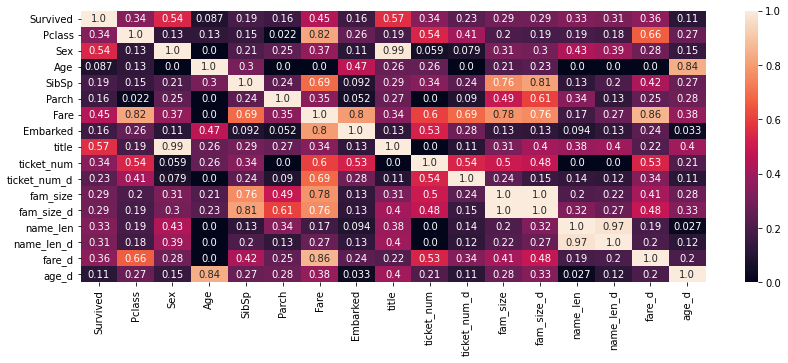

In [53]:
train_copy = train.copy()
train_copy.drop(['Name', 'Ticket'], axis=1, inplace=True)

def calculate_cramers_v(df: pdf) -> pdf:    
    result = np.zeros((len(df.columns), len(df.columns)))
    for i in range(len(df.columns)):
        for j in range(i, len(df.columns)):
            result[j,i] = result[i,j] = cramers_v(x=df.iloc[:, i], y=df.iloc[:, j])
    return pd.DataFrame(result, index=(df.columns), columns=(df.columns))

cramers = calculate_cramers_v(train_copy)
    
fig, ax = plt.subplots(figsize=(14, 5)) 
sns.heatmap(cramers, annot=True, fmt=".2", ax=ax)
plt.show()

*4.2.2. Using **Theil's U** to explore correlations that are not necessarily symmetric:*

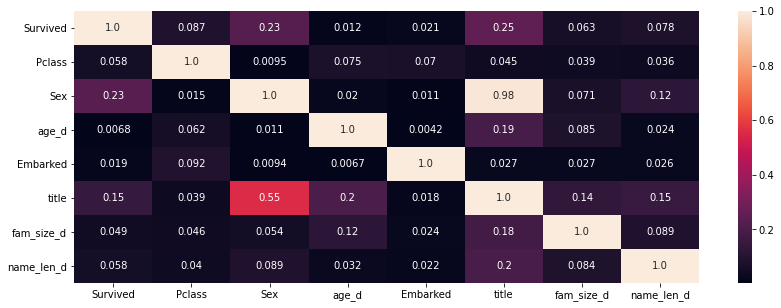

In [54]:
train_copy = train.copy()
train_copy = train_copy[['Survived', 'Pclass', 'Sex', 'age_d', 'Embarked', 'title', 'fam_size_d', 'name_len_d']]

def calculate_theils_u(df: pdf) -> pdf:
    result = np.zeros((len(df.columns), len(df.columns)))
    for i in range(len(df.columns)):
        for j in range(i, len(df.columns)):
            result[i,j] = theils_u(df.iloc[:, i], df.iloc[:, j])
            result[j,i] = theils_u(df.iloc[:, j], df.iloc[:, i])
    return pd.DataFrame(result, index=(df.columns), columns=(df.columns))

theils = calculate_theils_u(train_copy)

fig, ax = plt.subplots(figsize=(14, 5)) 
sns.heatmap(theils, annot=True, fmt=".2", ax=ax)
plt.show()

In [55]:
# sns.heatmap(cor, annot=True, cmap=plt.cm.PuBu)

*4.3. Using **Correlation ratio** to directly explore correlations between categorical and continuous variables ("Given a continuous number, how well can you know to which category it belongs to?"):*

In [56]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked', 'title', 'ticket_num', 'ticket_num_d', 'fam_size',
       'fam_size_d', 'name_len', 'name_len_d', 'fare_d', 'age_d'],
      dtype='object')

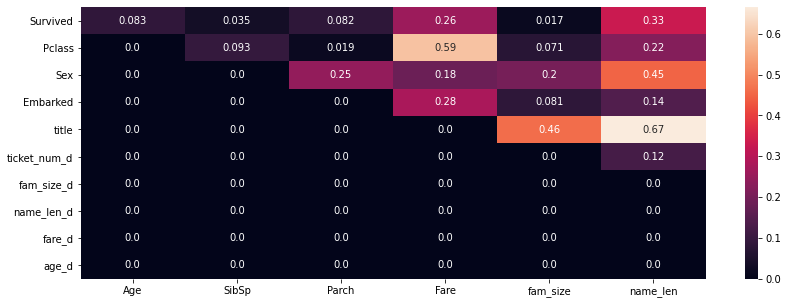

In [57]:
def calculate_correlation_ratio(df: pdf) -> pdf:
    categories = df[['Survived', 'Pclass', 'Sex', 'Embarked', 'title',
                     'ticket_num_d', 'fam_size_d', 'name_len_d','fare_d', 'age_d' ]]
    measurements = df[['Age', 'SibSp', 'Parch', 'Fare', 'fam_size', 'name_len']]
    result = np.zeros((len(categories.columns), len(measurements.columns)))
    for i in range(len(categories.columns)):
        for j in range(i, len(measurements.columns)):
            result[i][j] = correlation_ratio(categories=categories.iloc[:, i], measurements=measurements.iloc[:, j])

    return pd.DataFrame(data=result, index=(categories.columns), columns=(measurements.columns))

corr_ratio_df = calculate_correlation_ratio(train)

fig, ax = plt.subplots(figsize=(14, 5)) 
sns.heatmap(corr_ratio_df, annot=True, fmt=".2", ax=ax)
plt.show()

*4.3. Various seaborn visualisations of variables against survival outcomes:*

*4.3.1. `Pclass` is shown against `Survived` in catplot():*

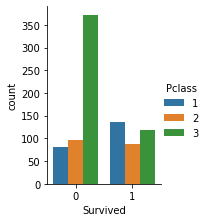

In [58]:
sns.catplot(x='Survived', data=train, hue='Pclass', kind='count', hue_order=range(1,4), height=3, aspect=0.75)
plt.show()

*4.3.2. A tabulated view to highlight patterns of survival for combinations of `Pclass`, `Embarked` and `Sex` using a multi-indexed format, displaying all 6 permutations of `Survived` with `Pclass` on the row-index against all 6 permutations of `Sex` and `Embarked` on the column-index. This can be viewed accordingly in a 6x6 heatmap grid:*

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: inplace is deprecated and will be removed in a future version.
  


Sex                female                             male             \
Embarked        Cherbourg Queenstown Southampton Cherbourg Queenstown   
Survived Pclass                                                         
0        1              1          0           2        25          1   
         2              0          0           6         8          1   
         3              8          9          55        33         36   
1        1             42          1          48        17          0   
         2              7          2          61         2          0   
         3             15         24          33        10          3   

Sex                          
Embarked        Southampton  
Survived Pclass              
0        1               51  
         2               82  
         3              231  
1        1               28  
         2               15  
         3               34

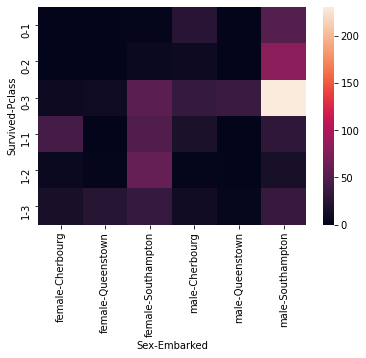

In [59]:
table = pd.crosstab(index=[train.Survived, train.Pclass], columns=[train.Sex, train.Embarked])
table.columns.set_levels(['Cherbourg','Queenstown','Southampton'], level=1, inplace=True)
sns.heatmap(table)
table

*4.3.3. Plot linear regression to visualise trends with the binary categorical dependent variable of ``Survived`:*

*4.3.3.1. Linear Regression for survival trend by `Age`:*

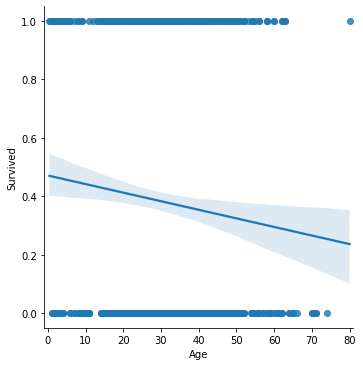

In [60]:
sns.lmplot(x='Age', y='Survived', data=train)
plt.gca().set_xlim(left=-1, right=81)
plt.show()

*4.3.3.2. Linear Regression for survival trend by `Age` and `Sex`:*

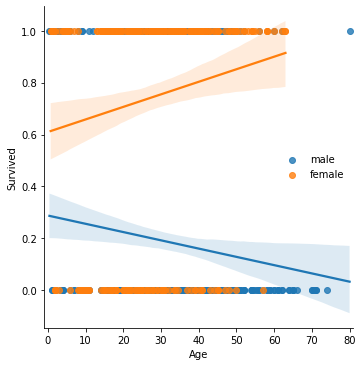

In [61]:
sns.lmplot(x='Age', y='Survived', hue='Sex', data=train, legend=False)
plt.gca().legend().set_title('')
plt.gca().legend().set_frame_on(False)
plt.gca().set_xlim(left=-1, right=81)
plt.show()

*4.3.3.3. Linear Regression for survival trend by `Age` and `Pclass`:*

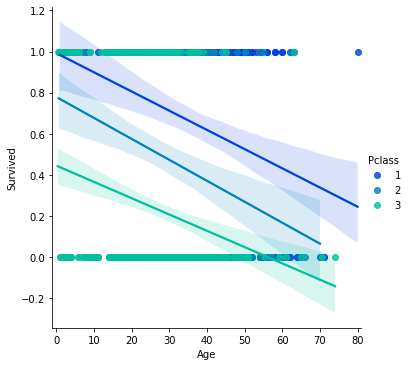

In [62]:
sns.lmplot(x='Age', y='Survived', hue='Pclass', data=train, palette='winter', hue_order=range(1,4))
plt.gca().set_xlim(left=-1, right=81)
plt.show()

*4.3.3.4. Linear Regression for survival trend by `Pclass` and binned `Age`:*

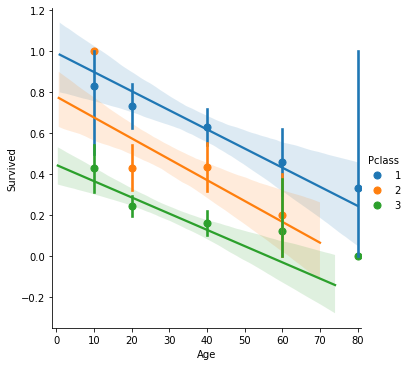

In [63]:
sns.lmplot(x='Age', y='Survived', hue='Pclass', data=train, x_bins=[10, 20, 40, 60, 80], hue_order=[1,2,3])
plt.gca().set_xlim(left=-1, right=81)
plt.show()

*4.3.3.5. Linear Regression for survival trend by `Pclass` and an additionally engineered feature `Person` (which combines information about sex and age):*


#### *Note: I have NOT included this additional feature in any subsequent stages*

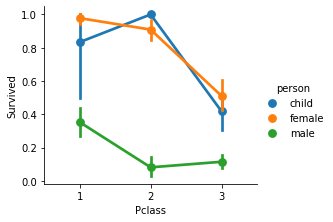

In [64]:
def child_or_gender(person: pds) -> str:
    age, gender = person
    return 'child' if age < 16 else gender

train['person'] = train[['Age', 'Sex']].apply(child_or_gender, axis=1)

sns.catplot(x='Pclass', y='Survived', hue='person', data=train, order=range(1,4), 
            hue_order = ['child','female','male'], kind='point', aspect=1.2, height=3)
plt.show()

### ***5. Consider further feature engineering in terms of using polynomials, aka `feature crosses`:***

*5.1. Generate polynomial features*

In [65]:
# from sklearn.preprocessing import PolynomialFeatures

In [66]:
# poly = PolynomialFeatures(degree=3, interaction_only=True)
# polynomials = pd.DataFrame(poly\
#                            .fit_transform(X), 
#                            columns=['0','1','2','3', 
#                                     'p1', 'p2', 'p3', 'p4'])\
#                                         [['p1', 'p2', 'p3', 'p4']]
# X = pd.concat([X, polynomials], axis=1)

In [67]:
train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Survived                891 non-null    int64   
 1   Pclass                  891 non-null    int64   
 2   Name                    891 non-null    object  
 3   Sex                     891 non-null    object  
 4   Age                     891 non-null    float64 
 5   SibSp                   891 non-null    int64   
 6   Parch                   891 non-null    int64   
 7   Ticket                  891 non-null    object  
 8   Fare                    891 non-null    float64 
 9   Embarked                891 non-null    object  
 10  title                   891 non-null    object  
 11  ticket_num              891 non-null    float64 
 12  ticket_num_d            891 non-null    category
 13  fam_size                891 non-null    int64   
 14  fam_size_d              89

### ***6. Train & tune machine learning models for predicting survival:***

In [68]:
from sklearn.linear_model import SGDClassifier, LinearRegression, LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier # K-nearest neighbours
from sklearn.naive_bayes import GaussianNB # Gaussian naïve Bayes
from sklearn.svm import SVC, LinearSVC # Support vector classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
# from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel, chi2, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, MaxAbsScaler, Normalizer

*6.1. Prepare train dataset for machine learning*

*6.1.1. Split `train` dataset to input features (`X_train`) and label (`Y_train`):*

In [69]:
X_train = train_encoded.drop('Survived', axis=1, inplace=False)
Y_train = train_encoded['Survived']

print(f'`X_train` has {len(X_train.columns)} columns. \nThey are: {list(X_train.columns)}')
print(f'`Y_train` is a pd.Series. \nIt is from the pd.DataFrame column called: {(Y_train.name)}')
X_train.info()

`X_train` has 53 columns. 
They are: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked', 'title', 'ticket_num', 'ticket_num_d', 'fam_size', 'fam_size_d', 'name_len', 'name_len_d', 'fare_d', 'Sex_female', 'Sex_male', 'title_Master', 'title_Miss', 'title_Mr', 'title_Mrs', 'title_snazzy', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'name_len_d_0-20', 'name_len_d_21-40', 'name_len_d_41-57', 'name_len_d_58-85', 'fare_d_0-10', 'fare_d_10-20', 'fare_d_100-200', 'fare_d_20-30', 'fare_d_200-300', 'fare_d_30-40', 'fare_d_300-600', 'fare_d_40-50', 'fare_d_50-60', 'fare_d_60-70', 'fare_d_70-80', 'fare_d_80-90', 'fare_d_90-100', 'ticket_num_d_0-25e4', 'ticket_num_d_25e4-50e4', 'ticket_num_d_>50e4', 'age_d', 'age_d_0-10', 'age_d_10-20', 'age_d_20-40', 'age_d_40-60', 'age_d_60-80']
`Y_train` is a pd.Series. 
It is from the pd.DataFrame column called: Survived
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 53 columns):
 #   Column

*6.1.2. Remove non-numeric variables:*

In [70]:
X_train = drop_non_numerical_variables(X_train)
print(f'\nResulting dataframe has columns: {list(X_train.columns)}')
X_train.info()

Non-numeric columns being dropped: ['Name', 'Sex', 'Ticket', 'Embarked', 'title', 'ticket_num_d', 'fam_size_d', 'name_len_d', 'fare_d', 'age_d']

Resulting dataframe has columns: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'ticket_num', 'fam_size', 'name_len', 'Sex_female', 'Sex_male', 'title_Master', 'title_Miss', 'title_Mr', 'title_Mrs', 'title_snazzy', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'name_len_d_0-20', 'name_len_d_21-40', 'name_len_d_41-57', 'name_len_d_58-85', 'fare_d_0-10', 'fare_d_10-20', 'fare_d_100-200', 'fare_d_20-30', 'fare_d_200-300', 'fare_d_30-40', 'fare_d_300-600', 'fare_d_40-50', 'fare_d_50-60', 'fare_d_60-70', 'fare_d_70-80', 'fare_d_80-90', 'fare_d_90-100', 'ticket_num_d_0-25e4', 'ticket_num_d_25e4-50e4', 'ticket_num_d_>50e4', 'age_d_0-10', 'age_d_10-20', 'age_d_20-40', 'age_d_40-60', 'age_d_60-80']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
--- 

*6.1.4. Scale/Normalize:*

*6.1.4.1. Visualise numerical variables to emphasise the point that several of them are on very different scales from one another, hence certain ML algorithms should perform better (in terms of accuracy and speed) on these datasets after rescaling/normalizing.
(This is also an opportunity to showcase Plotly. Note that these plots are interactive).*

*6.1.4.1.1. Allowing axes to set accoring to actual values. (Very large `ticket_num` maximum makes the rest of the data unviewable):*

In [71]:
import plotly.figure_factory as ff
hist_data = [X_train['Fare'], X_train['Age'], X_train['SibSp'],  X_train['fam_size'], 
             X_train['Parch'], X_train['name_len'], X_train['ticket_num']]
group_labels = ['Fare', 'Age', 'SibSp', 'fam_size', 'Parch', 'name_len', 'ticket_num']
# colors = ['#333F44', '#37AA9C', '#94F3E4']
# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, show_hist=False)
# Add title
fig.update_layout(title_text='Unrestricted abscissa')
fig.show()

*6.1.4.1.2. Restrict the abscissa to make other data viewable:*

In [72]:
fig.update_layout(title_text='Abscissa limited to 100')
fig.update_layout(xaxis_range=[0,100])
fig.show()

# SHORTCUT TO READ & TRANSFORM TRAIN DATASET IN TWO CELLS: 

In [73]:
# This super cell is designed to be a shortcut, all-in-one, cell containing all imports and transformations and functions needed to prepare 
# for and perform all of the subsequent learning algorithms (both with and without scaling). 

# LEARNING ALGORITHMS
from sklearn.linear_model import SGDClassifier, LinearRegression, LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier # K-nearest neighbours
from sklearn.naive_bayes import GaussianNB # Gaussian naïve Bayes
from sklearn.svm import SVC, LinearSVC # Support vector classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
import xgboost as xgb

# HYPERPARAMETER OPTIMIZATION
# "using brute force"
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV
# "using Bayesian optimization"
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# METRICS
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, learning_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
# from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel, chi2, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, MaxAbsScaler, Normalizer
from sklearn.preprocessing import OneHotEncoder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import namedtuple
import re
from pandas.core.frame import DataFrame as pdf
from pandas.core.series import Series as pds
from typing import Tuple, List
import copy
import time
import warnings
warnings.filterwarnings('ignore')

def read_ds(train_or_test: str) -> pdf: # 1
    return pd.read_csv(f'/kaggle/input/titanic/{train_or_test}.csv')

def impute_train_embarked_with_mode(ds: pdf) -> pdf: # 2
    print(f"Before imputation: Number of missing values in Embarked is {ds['Embarked'].isnull().sum()}")
    most_common = ds['Embarked'].mode()[0]
    print(f'Average value to be used for imputation is {most_common}')
    ds['Embarked'].fillna(most_common, inplace=True)
    print(f"After imputation: Number of missing values in Embarked is {ds['Embarked'].isnull().sum()}")
    return ds

def drop_col(df: pdf, colname: str) -> pdf:    
    return df.drop(colname, axis=1, inplace=False) if colname in df.columns else df

def _get_title(name: str) -> str:
    title_search = re.search(' ([A-Za-z]+)\.', name)
    return title_search.group(1) if title_search else ''

def _combine_special_titles(df: pdf) -> pdf:
    special_titles = ['Dr', 'Rev', 'Major', 'Col', 'Don', 'Lady', 'Countess', 'Capt', 'Jonkheer', 'Sir', 'Dona']
    miss = ['Mlle', 'Ms']
    mrs = ['Mme']
    # Titles signifying special social status changed to one label: 'special titles'
    df.loc[df['title'].isin(miss), 'title'] = 'Miss'
    df.loc[df['title'].isin(mrs), 'title'] = 'Mrs'
    df.loc[df['title'].isin(special_titles), 'title'] = 'snazzy'
    return df

def extract_title(df: pdf) -> pdf: # 5
    titles = df.Name.apply(_get_title)
    print(pd.value_counts(titles))
    df['title'] = titles
    return _combine_special_titles(df)

def extract_ticket_number(df: pdf) -> pdf: # 6
    df['ticket_num'] = df.Ticket.str.extract('(\d{1,})', expand=True)
    df['ticket_num'] = pd.to_numeric(df['ticket_num'], errors='coerce')
    return df

def impute_ticket_num_with_mode_per_pclass(df: pdf) -> pdf:
    tick_num_mode_pclass = df.groupby('Pclass')['ticket_num'].agg(lambda x: pd.Series.mode(x).iat[0]).to_frame()
    tick_num_mode_pclass.reset_index(level=0, inplace=True)
    for pclass in [1,2,3]:
        df.loc[(df.Pclass == pclass) & (df.ticket_num.isna()), 'ticket_num'] = int(tick_num_mode_pclass.loc[tick_num_mode_pclass.Pclass == pclass]['ticket_num'])
    return df

def _discretize(df: pdf, col_to_bin: str, bins: list, labels: list) -> pdf:
    new_col = col_to_bin.lower() + '_d'
    df[new_col] = pd.cut(df[col_to_bin], bins=bins, labels=labels)
    return df

def discretize_ticket_nums(df: pdf) -> pdf: # 8
    tckt_num_bins = [-0.1,250000,500000,4000000]
    tckt_num_bin_labels = ['0-25e4', '25e4-50e4', '>50e4']
    return _discretize(df, col_to_bin='ticket_num', bins=tckt_num_bins, labels=tckt_num_bin_labels)

def extract_fam_size_and_discretize(df: pdf) -> pdf: # 9
    df['fam_size'] = df['SibSp'] + df['Parch'] + 1
    fam_size_bins = [-0.1,1,4,20]
    fam_size_bin_labels = ['alone', '2-4', '>4']
    return _discretize(df, col_to_bin='fam_size', bins=fam_size_bins, labels=fam_size_bin_labels)

def extract_name_length_and_discretize(df: pdf) -> pdf: # 10
    df['name_len'] = df.Name.str.len()
    name_len_bins = [-0.1, 20, 40, 57, 85]
    name_len_bin_labels = ['0-20', '21-40', '41-57', '58-85']
    return _discretize(df, col_to_bin='name_len', bins=name_len_bins, labels=name_len_bin_labels)

def discretize_fare(df: pdf) -> pdf: # 11
    fare_bins = [-0.1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 600]
    fare_bin_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100-200', '200-300', '300-600']
    return _discretize(df, col_to_bin='Fare', bins=fare_bins, labels=fare_bin_labels)

def generate_one_hot_encoder_for_sex_title_embarked_name_len_d_fare_d_ticket_num_d(train: pdf): # 12
    encoder222 = OneHotEncoder(handle_unknown="ignore", sparse=False)
    encoder222.fit(train[['Sex', 'title', 'Embarked', 'name_len_d', 'fare_d', 'ticket_num_d']])
    return encoder222

def _hard_encode_fam_size_d(df: pdf) -> pdf:
    df['fam_size_d'] = df['fam_size_d'].map({'alone': 0, '2-4': 1, '>4': 2})
    return df

def _apply_one_hot_encoder_on_sex_title_embarked_name_len_d_fare_d_ticket_num_d(df: pdf, encdr) -> pdf:
    return encdr.transform(df[['Sex', 'title', 'Embarked', 'name_len_d', 'fare_d', 'ticket_num_d']])

def encode_non_numeric_features(df: pdf, encdr) -> pdf: # 13
    df1 = _hard_encode_fam_size_d(df)
    onehot_ndarray = _apply_one_hot_encoder_on_sex_title_embarked_name_len_d_fare_d_ticket_num_d(df1, encdr)
    df2 = pd.DataFrame(onehot_ndarray, columns=encdr.get_feature_names(['Sex', 'title', 'Embarked', 
                                                                        'name_len_d', 'fare_d', 'ticket_num_d']))
    return pd.concat([df1, df2], axis=1)

def drop_non_numerical_variables(df: pdf) -> pdf: # 14
    non_numeric_cols = list(df.select_dtypes(exclude=['int64', 'float64']).columns)
    print(f'Non-numeric columns being dropped: {non_numeric_cols}')
    return df.drop(non_numeric_cols, axis=1, inplace=False)

def impute_missing_age_using_rfr(df: pdf) -> pdf: # 15
    for_training = df.loc[df.Age.notnull()]
    for_predicting = df.loc[df.Age.isnull()]
    y = for_training['Age'].to_numpy()
    X = for_training.loc[:, for_training.columns != 'Age'].to_numpy()
    trained_rfr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    trained_rfr.fit(X, y)
    Xpred = for_predicting.loc[:, for_training.columns != 'Age'].to_numpy()
    predicted_values = trained_rfr.predict(Xpred)
    df.loc[df['Age'].isnull(), 'Age'] = predicted_values
    return df

def _discretize_age(df: pdf) -> pdf:
    max_age = df.Age.max()
    age_bins = [0, 10, 20, 40, 60, max_age]
    age_bin_labels = ['0-10', '10-20', '20-40', '40-60', '60-80']
    return _discretize(df, col_to_bin='Age', bins=age_bins, labels=age_bin_labels)

def generate_one_hot_encoder_for_age_d(df: pdf): # 16
    df = _discretize_age(df)
    encoder_age_d = OneHotEncoder(handle_unknown="ignore", sparse=False)
    encoder_age_d.fit(df[['age_d']])
    return encoder_age_d

def apply_one_hot_encoder_age_d(df: pdf, encdr) -> pdf: # 17
    onehot_ndarray = encdr.transform(df[['age_d']])
    df2 = pd.DataFrame(onehot_ndarray, columns=encdr.get_feature_names(['age_d']))
    return pd.concat([df, df2], axis=1)

def move_survived_from_x_to_y(df: pdf) -> Tuple[pdf, pds]: # 18
    x_train = df.drop('Survived', inplace=False, axis=1) if 'Survived' in df.columns else df
    y_train = df['Survived'] if 'Survived' in df.columns else None
    return x_train, y_train

# For speed (and after restarting the kernel) I have pasted into this cell all transformations done which are otherwise scattered across many notebook cells above:

def transform_ds(df: pdf) -> pdf:
    df = drop_col(df, 'Cabin') # 3
    df = drop_col(df, 'PassengerId') # 4
    df = extract_title(df) # 5
    df = extract_ticket_number(df) # 6
    df = impute_ticket_num_with_mode_per_pclass(df) # 7
    df = discretize_ticket_nums(df) # 8
    df = extract_fam_size_and_discretize(df) # 9
    df = extract_name_length_and_discretize(df) # 10
    df = discretize_fare(df) # 11
    encdr = generate_one_hot_encoder_for_sex_title_embarked_name_len_d_fare_d_ticket_num_d(df) # 12
    df_encoded = encode_non_numeric_features(df, encdr) # 13
    df_for_rfr = drop_non_numerical_variables(df_encoded) # 14
    df_encoded = impute_missing_age_using_rfr(df_for_rfr) # 15
    encdr_age = generate_one_hot_encoder_for_age_d(df_encoded) # 16
    df_encoded = apply_one_hot_encoder_age_d(df_encoded, encdr_age) # 17
    df_encoded = drop_non_numerical_variables(df_encoded) # 18
    x_train, y_train = move_survived_from_x_to_y(df_encoded) # 19
    return x_train, y_train

train = read_ds('train') # 1
train = impute_train_embarked_with_mode(train) # 2
X_train, Y_train = transform_ds(train) # 3-19

Before imputation: Number of missing values in Embarked is 2
Average value to be used for imputation is S
After imputation: Number of missing values in Embarked is 0
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Jonkheer      1
Don           1
Sir           1
Ms            1
Capt          1
Mme           1
Lady          1
Countess      1
Name: Name, dtype: int64
Non-numeric columns being dropped: ['Name', 'Sex', 'Ticket', 'Embarked', 'title', 'ticket_num_d', 'fam_size_d', 'name_len_d', 'fare_d']
Non-numeric columns being dropped: ['age_d']


In [74]:
# Comparing 9 different predictive models using scikit-learn - using only default parameters - and comparing 
# their accuracy metrics to predictions using scaled numerical inputs, for different scalers:
def compute_model_stats_unscaled(x: pdf, y: pds, name_model_pairs: dict=None) -> pdf:
    model_names, train_times, accuracies = [], [], []
    if name_model_pairs is None:
        name_model_pairs = {'KNNC': KNeighborsClassifier(), 'LgRgn': LogisticRegression(), 'LSVMC': LinearSVC(), 
                            'Ptrn': Perceptron(), 'SGDC': SGDClassifier(), 'XGBC': xgb.XGBClassifier(verbosity=0), 
                            'RFC': RandomForestClassifier(),  'GNB': GaussianNB(), 'DTC': DecisionTreeClassifier()}
    for model_name, model in name_model_pairs.items():
        for i in range(6): # multiple times in order to see how consistent the performances are. 
            clf = model
            start = time.time()
            clf.fit(x, y)
            train_times.append(1000*(time.time() - start))
            preds = clf.predict(x)
            accuracies.append(round(accuracy_score(y, preds)*100, 1))
            model_names.append(model_name)

    stats_unscaled = pd.DataFrame({
        'model': model_names,
        'acc': accuracies, 
        'millisec': train_times})
    stats_unscaled = stats_unscaled.sort_values(by=['acc'], ascending=False)
    stats_unscaled = stats_unscaled.set_index('model')
    agg_func_math = {'acc': ['mean', 'std'], 'millisec': ['mean', 'std']}
    return stats_unscaled.groupby(['model']).agg(agg_func_math).round(1)

def compute_model_stats_all_scalers(x: pdf, y: pds, name_scaler_pairs: dict=None, name_model_pairs: dict=None) -> pdf:
    numerical_features = ['Fare', 'Age', 'SibSp', 'fam_size', 'Parch', 'name_len', 'ticket_num']
    model_names2, scaler_names, scaled_accuracies, scaled_train_times = [], [], [], []
    if name_model_pairs is None:
        name_model_pairs = {'KNNC': KNeighborsClassifier(), 'LgRgn': LogisticRegression(), 'LSVMC': LinearSVC(), 
                    'Ptrn': Perceptron(), 'SGDC': SGDClassifier(), 'XGBC': xgb.XGBClassifier(verbosity=0), 
                    'RFC': RandomForestClassifier(),  'GNB': GaussianNB(), 'DTC': DecisionTreeClassifier()}
    if name_scaler_pairs is None:
        name_scaler_pairs = {'StdSc': StandardScaler(), 'MnMxSc': MinMaxScaler(), 'RbstSc': RobustScaler(), 
                     'QnTrnsfr': QuantileTransformer(), 'MxAbsSc': MaxAbsScaler(), 'Nrmlzr': Normalizer()}
    
    for model_name, model in name_model_pairs.items():
        for scaler_name, scaler in name_scaler_pairs.items():
            X_scaled = x.copy()
            train_scaler = scaler.fit(X_scaled[numerical_features]) 
            X_scaled[numerical_features] = train_scaler.transform(X_scaled[numerical_features])

            for i in range(6):         
                clf = model
                start = time.time()
                clf.fit(X_scaled, y) 
                scaled_train_times.append(1000*(time.time() - start))
                preds_scaled = clf.predict(X_scaled)
                scaled_accuracies.append(round(accuracy_score(y, preds_scaled)*100, 1))
                scaler_names.append(scaler_name)
                model_names2.append(model_name)

    stats_scaled = pd.DataFrame({
        'model': model_names2,
        'scaler': scaler_names,
        'acc': scaled_accuracies,
        'millisec': scaled_train_times})
    stats_scaled = stats_scaled.sort_values(by=['scaler', 'acc'], ascending=False)
    stats_scaled = stats_scaled.set_index('model')
    agg_func_math = {'acc': ['mean', 'std'], 'millisec': ['mean', 'std']}
    return stats_scaled.groupby(['model', 'scaler']).agg(agg_func_math).round(1)

name_model_pairs = {'KNNC': KNeighborsClassifier(), 'LgRgn': LogisticRegression(), 'LSVMC': LinearSVC(), 
                    'Ptrn': Perceptron(), 'SGDC': SGDClassifier(), 'XGBC': xgb.XGBClassifier(verbosity=0), 
                    'RFC': RandomForestClassifier(),  'GNB': GaussianNB(), 'DTC': DecisionTreeClassifier()}

def compute_acc_for_unscaled_and_different_scalers(x: pdf, y: pds, name_model_pairs: dict=None, name_scaler_pairs: dict=None) -> Tuple[pdf, pdf]:
    stats_unscaled = compute_model_stats_unscaled(x=x, y=y, name_model_pairs=name_model_pairs)
    stats_scaled = compute_model_stats_all_scalers(x=x, y=y, name_model_pairs=name_model_pairs, 
                                                   name_scaler_pairs=name_scaler_pairs)
    return stats_unscaled, stats_scaled

# Re-used functionality for grid search and related computations is encapsulated in 
# the following 9 functions to reduce repetition as much as possible:
def run_HGSCV(estmtr, param_grid: dict, x: pdf, y: pds) -> Tuple[dict, float]:
    start_time = time.time()
    hgscv = HalvingGridSearchCV(estimator=estmtr, scoring='accuracy', param_grid=param_grid, n_jobs=-1)
    hgscv.fit(x, y)
    end_time = time.time()
    bp = hgscv.best_params_
    return bp, round(end_time - start_time, 1)

def run_RSCV(estmtr, param_grid: dict, x: pdf, y: pds) -> Tuple[dict, float]:
    start_time = time.time()
    rscv = RandomizedSearchCV(estimator=estmtr, scoring='accuracy', param_distributions=param_grid, n_jobs=-1)
    rscv.fit(x, y)
    end_time = time.time()
    bp = rscv.best_params_
    # print(f'rscv.best_score_ {round(rscv.best_score_ *100, 1)}')
    return bp, round(end_time - start_time, 1)

def train_predict_acc_bp(estmtr_bp, x: pdf, y: pds) -> float:
    estmtr_bp.fit(x, y) 
    preds = estmtr_bp.predict(x)
    return round(accuracy_score(y, preds)*100, 1)

def train_predict_acc(estmtr, x: pdf, y: pds) -> Tuple[dict, float]:
    estmtr.fit(x, y) 
    preds = estmtr.predict(x)
    params = estmtr.get_params()
    params.pop('n_jobs', None)
    return params, round(accuracy_score(y, preds)*100, 1)

def calc_best_model_scaler_pairings(modelnames: List[str]) -> dict:
    results_scaled_stats = compute_accuracies_training_times_all_scalers()
    results_scaled_stats['max'] = results_scaled_stats[('acc', 'mean')].groupby('model').transform('max')
    rss_max = results_scaled_stats.loc[results_scaled_stats[('acc', 'mean')] == results_scaled_stats['max']]
    name_scaler_pairs = {'QnTrnsfr': scalers['QnTrnsfr'], 'MnMxSc': scalers['MnMxSc'], 
                         'MxAbsSc': scalers['MxAbsSc'], 'StdSc': scalers['StdSc'], 
                         'Nrmlzr': scalers['Nrmlzr'], 'RbstSc': scalers['RbstSc']}
    for modelname in modelnames:
        name_of_best_scaler = rss_max.loc[str.split(modelname, '_')[0]].index.values[0]
        modelname_bestscaler_pair[modelname] = name_scaler_pairs[name_of_best_scaler]
    return modelname_bestscaler_pair

name_scaler_pairs = {'StdSc': StandardScaler(), 'MnMxSc': MinMaxScaler(), 'RbstSc': RobustScaler(), 
                     'QnTrnsfr': QuantileTransformer(), 'MxAbsSc': MaxAbsScaler(), 'Nrmlzr': Normalizer()}
Scaler = namedtuple('Scaler', 'name object')
scaler_qt = Scaler('QnTrnsfr', name_scaler_pairs['QnTrnsfr'])
scaler_mnmx = Scaler('MnMxSc', name_scaler_pairs['MnMxSc'])
scaler_mxab = Scaler('MxAbsSc', name_scaler_pairs['MxAbsSc'])
scaler_std = Scaler('StdSc', name_scaler_pairs['StdSc'])
scaler_nmz = Scaler('Nrmlzr', name_scaler_pairs['Nrmlzr'])
scaler_rbs = Scaler('RbstSc', name_scaler_pairs['RbstSc'])

def _scale_numerical_features(scaler, x_train: pdf, x_test: pdf=None) -> Tuple[pdf, pdf]:
    x_train_scaled = x_train.copy()
    numerical_features = ['Fare', 'Age', 'SibSp', 'fam_size', 'Parch', 'name_len', 'ticket_num']
    train_scaler = scaler.fit(x_train_scaled[numerical_features]) 
    x_train_scaled[numerical_features] = train_scaler.transform(x_train_scaled[numerical_features])
    if x_test is not None:
        x_test_scaled = x_test.copy()
        x_test_scaled[numerical_features] = train_scaler.transform(x_test_scaled[numerical_features])
    else:
        x_test_scaled = None
    return x_train_scaled, x_test_scaled

# `modelname_bestscaler_pair` manually set here. 
# Note GNB seems to consistently give worse results with scaled inputs.
# However, if you want to reset it programmatically, call `calc_best_model_scaler_pairings()`, defined below:
modelname_bestscaler_pair = {'KNNC': scaler_qt.object, 'LgRgn': scaler_mnmx.object, 'Ptrn': scaler_mxab.object, 
                             'LSVMC': scaler_std.object, 'SGDC': scaler_mnmx.object, 'GNB': scaler_nmz.object, 
                             'RFC': scaler_std.object, 'XGBC': scaler_std.object, 'DTC': scaler_std.object}

# modelname_bestscaler_pair = calc_best_model_scaler_pairings(modelnames=['KNNC', 'KNNC_pof', 'LgRgn', 'LgRgn_l1', 'LgRgn_l2', 
#                                                                   'Ptrn_en', 'Ptrn_l1', 'Ptrn_l2', 'SGDC_l2', 'SGDC_l1', 
#                                                                   'LSVMC_l2', 'LSVMC_l1'])

def scale(model_name, x_train: pdf, x_test: pdf=None) -> Tuple[pdf, pdf]:
    scaler = modelname_bestscaler_pair[str.split(model_name, '_')[0]]
    if model_name == 'GNB':
        print(f'GNB performs better without scaled inputs, so X remains unscaled for this model.')
        return x_train, x_test 
    scaled_X_train, scaled_X_test = _scale_numerical_features(scaler, x_train=x_train, x_test=x_test)
    return scaled_X_train.copy(), scaled_X_test.copy() if scaled_X_test is not None else None

def build_df(bps: list, col_names: list) -> pdf:
    bp_df = pd.DataFrame.from_dict(bps[0], orient='index')
    for i, bp in enumerate(bps):
        if i == 0:
            continue
        bp_df[i] = pd.Series(bp)
    bp_df.columns = col_names
    return bp_df

def tabulate_all_results(results: pdf, scaler_name: str, modelname: str, time1: float, time3: float, 
                         acc1: float, acc_dflt: float, acc3: float, acc_sdflt: float) -> pdf:
    new_results = pd.DataFrame({'scaler': [np.NaN, np.NaN, scaler_name, scaler_name], 
                                'hyparam_tune': ['RSCV',  'default', 'RSCV', 'default'],
                                'search secs': [time1, np.NaN, time3, np.NaN],
                                'acc': [acc1, acc_dflt, acc3, acc_sdflt]})
    new_results['modelname'] = 4 * [modelname]
    new_results = new_results.set_index(['modelname', 'scaler'])
    new_results = new_results.pivot(columns='hyparam_tune')
    return new_results if results is None else pd.concat([results, new_results])

In [75]:
stats_unscaled, stats_scaled = compute_acc_for_unscaled_and_different_scalers(X_train, Y_train)
stats_unscaled.head(10)

acc       millisec      
        mean   std     mean   std
model                            
DTC    100.0   0.0      6.9   0.0
GNB     68.1   0.0      3.2   0.2
KNNC    80.8   0.0      4.5   0.5
LSVMC   42.5   0.9    109.4   0.7
LgRgn   68.2   0.0     37.2   1.6
Ptrn    38.4   0.0      9.0   0.7
RFC    100.0   0.0    265.4  18.4
SGDC    51.4  10.1     11.8   2.7
XGBC    99.9   0.0    161.3  46.2

In [76]:
stats_scaled.head(100)

acc      millisec      
                 mean  std     mean   std
model scaler                             
DTC   MnMxSc    100.0  0.0      7.2   0.3
      MxAbsSc   100.0  0.0      7.2   0.3
      Nrmlzr    100.0  0.0      8.4   0.3
      QnTrnsfr  100.0  0.0      7.2   0.3
      RbstSc    100.0  0.0      7.2   0.3
      StdSc     100.0  0.0      7.2   0.2
GNB   MnMxSc     70.4  0.0      3.2   0.4
      MxAbsSc    70.4  0.0      3.1   0.2
      Nrmlzr     71.6  0.0      3.4   0.3
      QnTrnsfr   71.4  0.0      3.2   0.4
      RbstSc     71.3  0.0      3.1   0.3
      StdSc      70.7  0.0      3.3   0.5
KNNC  MnMxSc     85.7  0.0      4.7   0.2
      MxAbsSc    86.0  0.0      5.0   0.3
      Nrmlzr     85.9  0.0      4.8   0.3
      QnTrnsfr   86.2  0.0      4.9   0.2
      RbstSc     85.3  0.0      5.1   0.3
      StdSc      85.0  0.0      4.3   0.7
LSVMC MnMxSc     83.4  0.0     52.5  12.8
      MxAbsSc    83.4  0.0     58.4   9.0
      Nrmlzr     82.0  0.0     58.5  12.0
      QnTrnsfr   82.4  0.0     60.0  12.5
      RbstSc     83.6  0.0     96.4   1.2
      StdSc      83.6  0.0     98.5   2.2
LgRgn MnMxSc     83.4  0.0     58.3   1.4
      MxAbsSc    83.4  0.0     48.6   0.8
      Nrmlzr     82.0  0.0     51.9   0.7
      QnTrnsfr   82.6  0.0     56.4   0.6
      RbstSc     83.2  0.0     68.4   1.8
      StdSc      83.2  0.0     82.6  43.6
Ptrn  MnMxSc     71.3  0.0      7.9   0.5
      MxAbsSc    75.6  0.0      8.7   0.6
      Nrmlzr     72.8  0.0      8.2   0.5
      QnTrnsfr   71.5  0.0      7.8   0.4
      RbstSc     80.6  0.0      7.7   0.7
      StdSc      80.1  0.0      7.5   0.5
RFC   MnMxSc    100.0  0.0    256.4   4.7
      MxAbsSc   100.0  0.0    254.3   3.4
      Nrmlzr    100.0  0.0    266.1   4.9
      QnTrnsfr  100.0  0.0    256.8   5.0
      RbstSc    100.0  0.0    255.9   3.6
      StdSc     100.0  0.0    260.6   6.1
SGDC  MnMxSc     81.1  1.0     16.9   3.7
      MxAbsSc    81.0  2.0     17.0   2.0
      Nrmlzr     75.2  9.3     17.7   3.5
      QnTrnsfr   79.1  4.4     18.9   1.7
      RbstSc     78.2  2.6     15.6   3.8
      StdSc      78.6  3.1     18.5   4.3
XGBC  MnMxSc     99.9  0.0    143.6   1.9
      MxAbsSc    99.9  0.0    147.2  10.2
      Nrmlzr    100.0  0.0    173.0  14.4
      QnTrnsfr   99.9  0.0    144.9   1.9
      RbstSc     99.9  0.0    144.9   3.3
      StdSc      99.9  0.0    158.1  40.4

#### Scaling and normalization are pertinent for certain learning algorithms like:

- K-Nearest Neighbors
- K-means clustering
- Logistic Regression
- Linear Regression
- SVM
- Perceptron
- PCA & LDA (these two algorithms are typically for dimensionality reduction)


#### There is no benefit to scaling/normalization inputs to rules-based learning algorithms like:

- Naive Bayes
- Decision Tree
- Random Forest 
- XGBoost & LightGBM*??

#### *Comparison of accuracies & performance is made with the different scalers/normalizer available in sklearn.*

#### *Comparison of accuracies & performance is made with different (hyper)parameters for the learning algorithms as determined via grid search.*

#### *Comparison of 9 predictive algorithms (which includes 3 tree based ones):*

*6.1.4.2. Compare the performance of the different scalers available in scikit-learn, using a number of scaling-sensitive models including Logistic Regression, KNN, LinearSVC, Perceptron, SGDC:*

##### *CONCLUSIONS ON PERFORMANCE OF THE 5 DIFFERENT SCIKIT LEARNING MODELS (WITH DEFAULT PARAMETERS) AND WITH UNSCALED VS SCALED NUMERICAL FEATURES:*

* ##### K-Nearest Neighbours Classifier (KNNC): 

Training with scaled numbers had little impact on KNC accuracy. In fact only StandardScaler and RobustScaler improved the accuracy, by 1% to 82%. The other 4 scalers actually slightly reduced it, (by 1%). 
KNC was the fastest of the 5 models, training in less than 4 ms. Training with scaled numbers was very slightly slower. 

This is weird. If you set n_neighbours to 1, you get 100% accuracy. ??
If you leave to default (i.e. 5), you get 76.4%, but scaling results in lower (74.4% with StandardScaler). ?? 

* ##### Logistic Regression (LgRgn):

Training with scaled numbers had the largest impact on this model, accuracy increasing from ~67% to over 80%. The best were MinMaxScaler, MaxAbsScaler, StandardScaler & RobustScaler all over 83%.
Training with unscaled took 12ms and was slightly slower with scaled numbers.

* ##### Perceptron (Ptrn):

Training with scaled numbers had a dramatic effect on accuracy which was ~58% unscaled. MaxAbsScaler & Normalizer improved it to 72%, while QuantileTransformer & MinMaxScaler reduced it to below 40%.
Training took 9ms. For the two that improved the accuracy, training time was a little faster to under 8ms. 

* ##### Stochastic Gradient Descent Classifier (SGDC):

Training with scaled numbers improved the accuracy from ~55% (+/-8%). Using MinMaxScaler improved it to 60% but with +/-15%. 
The improved performance of scaling was quite inconsistent.
<!-- Training was relatively slow, taking almost 52 ms, marginally improved to 50 ms with MaxAbsScaler.  -->
Training took 9ms +/-2.5ms, scaling slowed it down to 23ms +/- 5ms.

* ##### Linear Support Vector Machine Classifier (LSVMC):

Training with unscaled numbers showed a lot of inconsistency. This inconsistency was reduced when training was performed using scaled numbers, but the performance improvements of the scalers is also inconsistent. 
Training with scaled numbers improved the accuracy from 59% (+/-12%). Using MinMAxScaler improved it to 75.9% (+/-2.2%), while MaxAbsScaler improved it to 75.2% (+/-2.2 %).
SVM was the slowest of the 5 models, training taking about 110ms. This was very marginally faster with scaled numbers, training in about 105ms.

* ##### XGBoost Classifier (XGBC):

As a tree-based algorithm, it is not expected that scaling inputs will improve the predictive accuracy. However, based on other people's experience of improved speed, I tried it to see if it speeds up the learning algorithm here. It did so with unscaled data on one occasion but on all other occasions there was only a marginal if any speed up observed.
It is impossible to assess any improvement to accuracy (which would be unexpected) as this algorithm is already reaching 99.9% with unscaled. 

* ##### Random Forest Classifier (RFC):

As a tree-base algorithm, it is not expected that scaling inputs will improve the predictive accuracy. However, based on the marginal improvement to the speed of the XGBoost classifier, I thought I'd try it for Random Forest too. The difference was again very small, if at all.

(Simply for completeness, I included two further classifiers that are not expected to be improved by scaling the inputs).

* ##### Gaussian Naïve Bayes (GNB):

No improvement to accuracy with scaled inputs, as expected, and some very small increase in speed of grid search.

* ##### Decision Tree Classifier (DTC):

No improvement to accuracy with scaled inputs, as expected, and some very small increase in speed of grid search.

It's worth noting that grid search always 


#### SUMMARY:

| model | speed (ms) | acc->scaled (%) | stddev (%) | scaler |
| --- | --- | --- | --- | --- |
| KNNC | 4->4.5 | 76->74 | 0 | StdSc |
| LgRgn | 31->66 | 66->83.7 | 0 | StdSc |
| Ptrn | 9->8 | 58->72.2 | 0 | MxAbsSc & Nrmlzr|
| SGDC | 10->26 | 55->66.4 | 8->6 | MxAbsSc |
| LSVMC | 117->109 | 60->76 | 14->2 | MnMxSc|
| XGBC | 145->142 | 99.9->100 | 0 | Nrmlzr |
| RFC | 199->187 | 100 | 0 | Nrmlzr |
| GNB | 3 | 68->73 | 4 | Nrmlzr |
| DTC | 6.6 | 100 | 0 | all | 

*6.1.5. Perform grid search to identify best hyperparameters for the learning algorithms.*

*6.1.5.1. Hyperparameter optimization for K-Nearest Neighbors Classifier with unscaled and scaled numerical features (using best-performing scaler as determined in preceding section).* 

##### *Compare performance of hyperparameter search with HalvingGridSearchCV vs RandomizedSearchCV:*

In [77]:
# # K-NEAREST NEIGHBOURS CLASSIFIER (KNNC)
# modelname = 'KNNC'
# # Using a smaller selection of parameters (manually done after numerous iterations):
# param_grid = {'n_neighbors': [3, 4, 5], 
#               'weights':['uniform', 'distance'], # NB: `uniform` is sometimes selected but gives 86% vs 100% accuracy c.w. `distance`
#               'algorithm': ['auto', 'ball_tree'], 'leaf_size': [25, 30, 35],  'p': [1, 2, 3],  
#               'metric': ['minkowski', 'hamming']}

# X = X_train.copy()
# Y = Y_train.copy()

# # # HALVING GRID SEARCH - KNNC:
# # bp, time0 = run_HGSCV(KNeighborsClassifier(), param_grid, X, Y)
# # bp0 = bp
# # clf_bp = KNeighborsClassifier(leaf_size=bp['leaf_size'], metric=bp['metric'], n_neighbors=bp['n_neighbors'], 
# #                               p=bp['p'], weights=bp['weights'], algorithm=bp['algorithm'])
# # acc0 = train_predict_acc_bp(clf_bp, X, Y)

# # RANDOMIZED SEARCH - KNNC:
# bp, time1 = run_RSCV(KNeighborsClassifier(), param_grid, X, Y)
# bp1 = bp
# clf_bp = KNeighborsClassifier(leaf_size=bp['leaf_size'], metric=bp['metric'], n_neighbors=bp['n_neighbors'], 
#                               p=bp['p'], weights=bp['weights'], algorithm=bp['algorithm'])
# acc1 = train_predict_acc_bp(clf_bp, X, Y)

# # DEFAULT PARAMETERS - KNNC:
# dflt, acc_dflt = train_predict_acc(KNeighborsClassifier(), X, Y)
# # DEFAULT PARAMETERS WITH WEIGHTS SET TO `DISTANCE` - KNNC:
# # dflt, acc_dflt = train_predict_acc(KNeighborsClassifier(weights='distance'), X, Y)

# # SCALED NUMERICAL FEATURES: ----------------------------------------------------------------------------------------------------------
# X, _ = scale(modelname, X_train)

# # # HALVING GRID SEARCH (SCALED) - KNNC:
# # bp, time2 = run_HGSCV(KNeighborsClassifier(), param_grid, X, Y)
# # bp2 = bp
# # clf_bp = KNeighborsClassifier(leaf_size=bp['leaf_size'], metric=bp['metric'], n_neighbors=bp['n_neighbors'], 
# #                               p=bp['p'], weights=bp['weights'], algorithm=bp['algorithm'])
# # acc2 = train_predict_acc_bp(clf_bp, X, Y)

# # RANDOMIZED SEARCH (SCALED) - KNNC:
# bp, time3 = run_RSCV(KNeighborsClassifier(), param_grid, X, Y)
# bp3 = bp
# clf_bp = KNeighborsClassifier(leaf_size=bp['leaf_size'], metric=bp['metric'], n_neighbors=bp['n_neighbors'], 
#                               p=bp['p'], weights=bp['weights'], algorithm=bp['algorithm'])
# acc3 = train_predict_acc_bp(clf_bp, X, Y)

# # DEFAULT PARAMETERS (SCALED) - KNNC:
# sdflt, acc_sdflt = train_predict_acc(KNeighborsClassifier(), X, Y)

# # DEFAULT PARAMETERS WITH WEIGHTS SET TO `DISTANCE` (SCALED)- KNNC:
# # sdflt, acc_sdflt, time_sdflt = train_predict_acc(KNeighborsClassifier(weights='distance'), X, Y)

# # bp_df = build_df([bp0, bp1, dflt, bp2, bp3, sdflt], ['HSCV', 'RSCV', 'default', 'sHSCV', 'sRSCV', 'sdefault'])
# bp_df = build_df([bp1, dflt, bp3, sdflt], ['RSCV', 'default', 'sRSCV', 'sdefault'])
# # bp_df
# print(f'{modelname} results:\nacc1: {acc1}% bp1: {bp1}\nacc3: {acc3}% bp3: {bp3}\nacc_dflt: {acc_dflt}% dflt: {dflt}\nacc_sdflt: {acc_sdflt}% sdflt: {sdflt}')
# results = tabulate_all_results(results=None, scaler_name=scaler_qt.name, modelname=modelname, time1=time1, time3=time3, 
#                                acc1=acc1, acc_dflt=acc_dflt, acc3=acc3, acc_sdflt=acc_sdflt)
# results_all = None
# results_all = pd.concat([results_all, results]) if results_all is not None else results
# results

# # With weights='distance' all 4 are 100%. 
# # So, scaling improves the default or grid searched bps improves on unscaled default by ~5%. Scaling and grid searched bps improves this by a further ~1%.

*6.1.5.2. Hyperparameter optimization for Logistic Regression classifier with unscaled and scaled numerical features (using best-performing scaler as determined in preceding section).* 

*Compare performance of hyperparameter search with HalvingGridSearchCV vs RandomizedSearchCV:*

In [78]:
# # LOGISTIC REGRESSION (LgRgn)
# modelname = 'LgRgn'
# # only saga supports 'elasticnet'
# # Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.
# # Solver liblinear does not support a multinomial backend.
# # param_grid = {'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'], 'penalty': ['l1', 'l2', 'elasticnet', 'none'],
# #               'C': [0.25, 0.5, 1, 4, 8], 'max_iter': [50, 80, 400, train.shape[0]],  'tol': [1e-6, 1e-4, 6e-05],
# #               'fit_intercept': [True, False], 'intercept_scaling': [0.5, 1, 2],  'class_weight': ['balanced', None],
# #               'multi_class': ['auto', 'ovr', 'multinomial'], 'warm_start': [False, True]}

# # Using a smaller selection of parameters (manually done after numerous iterations):
# param_grid = {'solver': [ 'newton-cg', 'saga'], 'penalty': [ 'l2', 'none'], 'C': [7, 8, 9], 
#               'max_iter': [70, 80, train.shape[0], 1000],  'tol': [1e-6, 6e-05, 4e-05], 'fit_intercept': [True, False], 
#               'intercept_scaling': [0.2, 0.25, 0.3],  'class_weight': ['balanced', None],
#               'multi_class': ['auto', 'ovr', 'multinomial'], 'warm_start': [False, True]}

# X = X_train.copy()
# Y = Y_train.copy()

# # # HALVING GRID SEARCH - LgRgn: 
# # bp, time0 = run_HGSCV(LogisticRegression(), param_grid, X, Y)
# # bp0 = bp
# # clf_bp = LogisticRegression(solver=bp['solver'], penalty=bp['penalty'], C=bp['C'], max_iter=bp['max_iter'], tol=bp['tol'], 
# #                          fit_intercept=bp['fit_intercept'], intercept_scaling=bp['intercept_scaling'], class_weight=bp['class_weight'], 
# #                          multi_class=bp['multi_class'], warm_start=bp['warm_start'])
# # acc0 = train_predict_acc_bp(clf_bp, X, Y)

# # RANDOMIZED SEARCH - LgRgn:
# bp, time1 = run_RSCV(LogisticRegression(), param_grid, X, Y)
# bp1 = bp
# clf_bp = LogisticRegression(solver=bp['solver'], penalty=bp['penalty'], C=bp['C'], max_iter=bp['max_iter'], tol=bp['tol'], 
#                          fit_intercept=bp['fit_intercept'], intercept_scaling=bp['intercept_scaling'], class_weight=bp['class_weight'], 
#                          multi_class=bp['multi_class'], warm_start=bp['warm_start'])
# acc1 = train_predict_acc_bp(clf_bp, X, Y)

# # DEFAULT PARAMETERS - LgRgn
# dflt, acc_dflt = train_predict_acc(LogisticRegression(), X, Y)

# # SCALED NUMERICAL FEATURES: ----------------------------------------------------------------------------------------------------------
# X, _ = scale(modelname, X_train)

# # # HALVING GRID SEARCH (SCALED) - LgRgn: 
# # bp, time2 = run_HGSCV(LogisticRegression(), param_grid, X, Y)
# # bp2 = bp
# # clf_bp = LogisticRegression(solver=bp['solver'], penalty=bp['penalty'], C=bp['C'], max_iter=bp['max_iter'], tol=bp['tol'], 
# #                          fit_intercept=bp['fit_intercept'], intercept_scaling=bp['intercept_scaling'], class_weight=bp['class_weight'], 
# #                          multi_class=bp['multi_class'], warm_start=bp['warm_start'])
# # acc2 = train_predict_acc_bp(clf_bp, X, Y)

# # RANDOMIZED SEARCH (SCALED) - LgRgn:
# bp, time3 = run_RSCV(LogisticRegression(), param_grid, X, Y)
# bp3 = bp
# clf_bp = LogisticRegression(solver=bp['solver'], penalty=bp['penalty'], C=bp['C'], max_iter=bp['max_iter'], tol=bp['tol'], 
#                          fit_intercept=bp['fit_intercept'], intercept_scaling=bp['intercept_scaling'], class_weight=bp['class_weight'], 
#                          multi_class=bp['multi_class'], warm_start=bp['warm_start'])
# acc3 = train_predict_acc_bp(clf_bp, X, Y)

# # DEFAULT PARAMETERS (SCALED) - LgRgn:
# sdflt, acc_sdflt = train_predict_acc(LogisticRegression(), X, Y)

# # bp_df = build_df([bp0, bp1, dflt, bp2, bp3, sdflt], ['HSCV', 'RSCV', 'default', 'sHSCV', 'sRSCV', 'sdefault'])
# bp_df = build_df([bp1, dflt, bp3, sdflt], ['RSCV', 'default', 'sRSCV', 'sdefault'])
# # bp_df
# print(f'{modelname} results:\nacc1: {acc1}% bp1: {bp1}\nacc3: {acc3}% bp3: {bp3}\nacc_dflt: {acc_dflt}% dflt: {dflt}\nacc_sdflt: {acc_sdflt}% sdflt: {sdflt}')
# results = tabulate_all_results(results=None, scaler_name=scaler_mnmx.name, modelname=modelname, time1=time1, time3=time3, 
#                                acc1=acc1, acc_dflt=acc_dflt, acc3=acc3, acc_sdflt=acc_sdflt)
# results_all = pd.concat([results_all, results]) if results_all is not None else results
# results
# # RSCV 60-65%, def 65-69%, sRSCV ~83%, sdef ~83% - performances of unscaled could go up to ~84% for unscaled 
# # but did not appear to be down to any specific parameters.
# # hence, it may be that with scaled inputs, RSCV more consistently achieves >80%, rather than 68%.

*6.1.5.3. Hyperparameter optimization for Perceptron classifier with unscaled and scaled numerical features (using best-performing scaler as determined in preceding section).* 

*Compare performance of hyperparameter search with HalvingGridSearchCV vs RandomizedSearchCV:*

In [79]:
# # PERCEPTRON (Ptrn)
# modelname = 'Ptrn'
# param_grid = {'penalty': ['l2','l1', None, 'elasticnet'], 'alpha':[0.005, 0.01, 0.05], 'l1_ratio': [0.15], 
# # The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1. l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1. Only used if penalty='elasticnet'.
#               'fit_intercept': [True, False], 'max_iter': [100, 1000, 5000], 'tol': [1e-2, 1e-3, 1e-4],
#               'shuffle': [True, False], 'eta0': [0.1, 1, 10], 'early_stopping': [False, True],
#               'validation_fraction': [0.1], 'n_iter_no_change': [5], 'class_weight': ['balanced', None],
#               'warm_start': [False, True]}

# X = X_train.copy()
# Y = Y_train.copy()

# # # HALVING GRID SEARCH - Ptrn: 
# # bp, time0 = run_HGSCV(Perceptron(), param_grid, X, Y)
# # bp0 = bp
# # clf_bp = Perceptron(penalty=bp['penalty'], alpha=bp['alpha'], fit_intercept=bp['fit_intercept'], max_iter=bp['max_iter'], 
# #                     tol=bp['tol'], shuffle=bp['shuffle'], eta0=bp['eta0'], early_stopping=bp['early_stopping'], 
# #                     validation_fraction=bp['validation_fraction'], n_iter_no_change=bp['n_iter_no_change'], 
# #                     class_weight=bp['class_weight'], warm_start=bp['warm_start'])
# # acc0 = train_predict_acc_bp(clf_bp, X, Y)

# # RANDOMIZED SEARCH - Ptrn:
# bp, time1 = run_RSCV(Perceptron(), param_grid, X, Y)
# bp1 = bp
# clf_bp = Perceptron(penalty=bp['penalty'], alpha=bp['alpha'], fit_intercept=bp['fit_intercept'], max_iter=bp['max_iter'], 
#                     tol=bp['tol'], shuffle=bp['shuffle'], eta0=bp['eta0'], early_stopping=bp['early_stopping'], 
#                     validation_fraction=bp['validation_fraction'], n_iter_no_change=bp['n_iter_no_change'], 
#                     class_weight=bp['class_weight'], warm_start=bp['warm_start'])
# acc1 = train_predict_acc_bp(clf_bp, X, Y)

# # DEFAULT PARAMETERS - Ptrn
# dflt, acc_dflt = train_predict_acc(Perceptron(), X, Y)

# # SCALED NUMERICAL FEATURES: ----------------------------------------------------------------------------------------------------------
# X, _ = scale(modelname, X_train)

# # # HALVING GRID SEARCH (SCALED) - Ptrn: 
# # bp, time2 = run_HGSCV(Perceptron(), param_grid, X, Y)
# # bp2 = bp
# # clf_bp = Perceptron(penalty=bp['penalty'], alpha=bp['alpha'], fit_intercept=bp['fit_intercept'], max_iter=bp['max_iter'], 
# #                     tol=bp['tol'], shuffle=bp['shuffle'], eta0=bp['eta0'], early_stopping=bp['early_stopping'], 
# #                     validation_fraction=bp['validation_fraction'], n_iter_no_change=bp['n_iter_no_change'], 
# #                     class_weight=bp['class_weight'], warm_start=bp['warm_start'])
# # acc2 = train_predict_acc_bp(clf_bp, X, Y)

# # RANDOMIZED SEARCH (SCALED) - Ptrn:
# bp, time3 = run_RSCV(Perceptron(), param_grid, X, Y)
# bp3 = bp
# clf_bp = Perceptron(penalty=bp['penalty'], alpha=bp['alpha'], fit_intercept=bp['fit_intercept'], max_iter=bp['max_iter'], 
#                     tol=bp['tol'], shuffle=bp['shuffle'], eta0=bp['eta0'], early_stopping=bp['early_stopping'], 
#                     validation_fraction=bp['validation_fraction'], n_iter_no_change=bp['n_iter_no_change'], 
#                     class_weight=bp['class_weight'], warm_start=bp['warm_start'])
# acc3 = train_predict_acc_bp(clf_bp, X, Y)

# # DEFAULT PARAMETERS (SCALED) - Ptrn:
# sdflt, acc_sdflt = train_predict_acc(Perceptron(), X, Y)

# # bp_df = build_df([bp0, bp1, dflt, bp2, bp3, sdflt], ['HSCV', 'RSCV', 'default', 'sHSCV', 'sRSCV', 'sdefault'])
# bp_df = build_df([bp1, dflt, bp3, sdflt], ['RSCV', 'default', 'sRSCV', 'sdefault'])
# # bp_df
# print(f'{modelname} results:\nacc1: {acc1}% bp1: {bp1}\nacc3: {acc3}% bp3: {bp3}\nacc_dflt: {acc_dflt}% dflt: {dflt}\nacc_sdflt: {acc_sdflt}% sdflt: {sdflt}')
# results = tabulate_all_results(results=None, scaler_name=scaler_mxab.name, modelname=modelname, time1=time1, time3=time3, 
#                                acc1=acc1, acc_dflt=acc_dflt, acc3=acc3, acc_sdflt=acc_sdflt)
# results_all = pd.concat([results_all, results]) if results_all is not None else results
# results
# # RSCV 61.6%, def 38.4%, sRSCV 48-78.5%, sdef 79.2% Note: sRSCV (as is quite possible with RandomizedSearch) was observed to sometimes end as low as 48%
# # It seems quite clear that scaled inputs has a dramatic effect on accuracy of Perceptron here, with grid search only improving the accuracy of unscaled
# # Dramatically reduced accuracy (< 40%) was observed in a sporadic fashion that did not appear to be associated grid search vs default, nor scaled vs unscaled inputs.

*6.1.5.4. Hyperparameter optimization for Stochastic Gradient Descent classifier with unscaled and scaled numerical features (using best-performing scaler as determined in preceding section).* 

*Compare performance of hyperparameter search with HalvingGridSearchCV vs RandomizedSearchCV:*

In [80]:
# # STOCHASTIC GRADIENT DESCENT CLASSIFIER (SGDC)
# modelname = 'SGDC'
# # param_grid = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 
# #                        'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
# #               'penalty': ['l2', 'l1', 'elasticnet'], 'alpha': [0.0001, 0.0003, 0.001], 'l1_ratio': [0.15, 0.08, 0.3],
# #               'fit_intercept': [True, False], 'tol': [None, 0.0005, 0.001, 0.01, 0.1], 'max_iter': [1000, 100, 400], 
# #               'shuffle': [True, False], 'epsilon': [0.1, 0.01, 1],'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
# #               'learning_rate': ['optimal', 'invscaling', 'adaptive'], 'eta0': [0.1, 1.0], 'power_t': [0.5, 0.1, 0.9],
# #               'early_stopping': [False, True], 'validation_fraction': [0.1, 0.01, 0.9], 'n_iter_no_change': [5, 1, 10],
# #               'class_weight': [None, 'balanced'], 'warm_start': [False, True], 'average': [False, True]}
# # note: eta0 must be > 0
# # param_grid with fewer candidates to address problem with compute of Grid Search:
# param_grid = {'loss': ['hinge', 'squared_loss', 'huber'],
#               'penalty': ['l2', 'elasticnet'], 'alpha': [0.0001, 0.00003], 'l1_ratio': [1, 0.1],
#               'fit_intercept': [False, True], 'tol': [0.001, 0.01], 'max_iter': [100, 400], 
#               'shuffle': [True, False], 'epsilon': [0.1, 0.01], 'learning_rate': ['constant', 'adaptive'],
#               'eta0': [0.1, 1.0], 'power_t': [0.5, 0.1], 'early_stopping': [False, True], 'validation_fraction': [0.1, 0.01], 
#               'n_iter_no_change': [5, 1], 'class_weight': [None, 'balanced'], 'warm_start': [False, True], 'average': [False, True]}

# X = X_train.copy()
# Y = Y_train.copy()

# # # HALVING GRID SEARCH - SGDC: 
# # bp, time0 = run_HGSCV(SGDClassifier(), param_grid, X, Y)
# # bp0 = bp
# # clf_bp = SGDClassifier(loss=bp['loss'], penalty=bp['penalty'], alpha=bp['alpha'], l1_ratio=bp['l1_ratio'], 
# #                     fit_intercept=bp['fit_intercept'], tol=bp['tol'], max_iter=bp['max_iter'], 
# #                     shuffle=bp['shuffle'], epsilon=bp['epsilon'], learning_rate=bp['learning_rate'], 
# #                     eta0=bp['eta0'], power_t=bp['power_t'], early_stopping=bp['early_stopping'], 
# #                     validation_fraction=bp['validation_fraction'], n_iter_no_change=bp['n_iter_no_change'], 
# #                     class_weight=bp['class_weight'], warm_start=bp['warm_start'], average=bp['average'])
# # acc0 = train_predict_acc_bp(clf_bp, X, Y)

# # RANDOMIZED SEARCH - SGDC:
# bp, time1 = run_RSCV(SGDClassifier(), param_grid, X, Y)
# bp1 = bp
# clf_bp = SGDClassifier(loss=bp['loss'], penalty=bp['penalty'], alpha=bp['alpha'], l1_ratio=bp['l1_ratio'], 
#                        fit_intercept=bp['fit_intercept'], tol=bp['tol'], max_iter=bp['max_iter'], 
#                        shuffle=bp['shuffle'], epsilon=bp['epsilon'], learning_rate=bp['learning_rate'], 
#                        eta0=bp['eta0'], power_t=bp['power_t'], early_stopping=bp['early_stopping'], 
#                        validation_fraction=bp['validation_fraction'], n_iter_no_change=bp['n_iter_no_change'], 
#                        class_weight=bp['class_weight'], warm_start=bp['warm_start'], average=bp['average'])
# acc1 = train_predict_acc_bp(clf_bp, X, Y)

# # DEFAULT PARAMETERS - SGDC
# dflt, acc_dflt = train_predict_acc(SGDClassifier(), X, Y)

# # SCALED NUMERICAL FEATURES: ----------------------------------------------------------------------------------------------------------
# X, _ = scale(modelname, X_train)

# # # HALVING GRID SEARCH (SCALED) - SGDC: 
# # bp, time2 = run_HGSCV(SGDClassifier(), param_grid, X, Y)
# # bp2 = bp
# # clf_bp = SGDClassifier(loss=bp['loss'], penalty=bp['penalty'], alpha=bp['alpha'], l1_ratio=bp['l1_ratio'], 
# #                     fit_intercept=bp['fit_intercept'], tol=bp['tol'], max_iter=bp['max_iter'], 
# #                     shuffle=bp['shuffle'], epsilon=bp['epsilon'], learning_rate=bp['learning_rate'], 
# #                     eta0=bp['eta0'], power_t=bp['power_t'], early_stopping=bp['early_stopping'], 
# #                     validation_fraction=bp['validation_fraction'], n_iter_no_change=bp['n_iter_no_change'], 
# #                     class_weight=bp['class_weight'], warm_start=bp['warm_start'], average=bp['average'])
# # acc2 = train_predict_acc_bp(clf_bp, X, Y)

# # RANDOMIZED SEARCH (SCALED) - SGDC:
# bp, time3 = run_RSCV(SGDClassifier(), param_grid, X, Y)
# bp3 = bp
# clf_bp = SGDClassifier(loss=bp['loss'], penalty=bp['penalty'], alpha=bp['alpha'], l1_ratio=bp['l1_ratio'], 
#                        fit_intercept=bp['fit_intercept'], tol=bp['tol'], max_iter=bp['max_iter'], 
#                        shuffle=bp['shuffle'], epsilon=bp['epsilon'], learning_rate=bp['learning_rate'], 
#                        eta0=bp['eta0'], power_t=bp['power_t'], early_stopping=bp['early_stopping'], 
#                        validation_fraction=bp['validation_fraction'], n_iter_no_change=bp['n_iter_no_change'], 
#                        class_weight=bp['class_weight'], warm_start=bp['warm_start'], average=bp['average'])
# acc3 = train_predict_acc_bp(clf_bp, X, Y)

# # DEFAULT PARAMETERS (SCALED) - SGDC:
# sdflt, acc_sdflt = train_predict_acc(SGDClassifier(), X, Y)

# # bp_df = build_df([bp0, bp1, dflt, bp2, bp3, sdflt], ['HSCV', 'RSCV', 'default', 'sHSCV', 'sRSCV', 'sdefault'])
# bp_df = build_df([bp1, dflt, bp3, sdflt], ['RSCV', 'default', 'sRSCV', 'sdefault'])
# # bp_df
# print(f'{modelname} results:\nacc1: {acc1}% bp1: {bp1}\nacc3: {acc3}% bp3: {bp3}\nacc_dflt: {acc_dflt}% dflt: {dflt}\nacc_sdflt: {acc_sdflt}% sdflt: {sdflt}')
# results = tabulate_all_results(results=None, scaler_name=scaler_mnmx.name, modelname=modelname, time1=time1, time3=time3, 
#                                acc1=acc1, acc_dflt=acc_dflt, acc3=acc3, acc_sdflt=acc_sdflt)
# results_all = pd.concat([results_all, results]) if results_all is not None else results
# results

*6.1.5.5. Hyperparameter optimization for Support Vector Machine classifier with unscaled and scaled numerical features (using best-performing scaler as determined in preceding section).* 

*Compare performance of hyperparameter search with HalvingGridSearchCV vs RandomizedSearchCV:*

In [81]:
# # LINEAR SUPPORT VECTOR MACHINE CLASSIFIER (LSVMC)
# modelname = 'LSVMC'
# # Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when 
# # dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

# param_grid = {'penalty': ['l2', 'l1'], 'loss': ['squared_hinge', 'hinge'], 'dual': [True], 'tol': [1e-4, 1e-5],
#               'C': [1.0, 0.5], 'multi_class': ['ovr', 'crammer_singer'], # note: 'crammer_singer' seems to slow training down a lot.
#               'fit_intercept': [True], 'intercept_scaling': [1.0, 0.5], 'class_weight': ['balanced', None], 'max_iter': [1000, 300]}

# X = X_train.copy()
# Y = Y_train.copy()

# # # HALVING GRID SEARCH - LSVMC: 
# # bp, time0 = run_HGSCV(LinearSVC(), param_grid, X, Y)
# # bp0 = bp
# # clf_bp = LinearSVC(loss=bp['loss'], penalty=bp['penalty'], dual=bp['dual'], tol=bp['tol'], C=bp['C'], multi_class=bp['multi_class'], 
# #                    fit_intercept=bp['fit_intercept'], intercept_scaling=bp['intercept_scaling'], class_weight=bp['class_weight'],  
# #                    max_iter=bp['max_iter'])
# # acc0 = train_predict_acc_bp(clf_bp, X, Y)

# # RANDOMIZED SEARCH - LSVMC:
# bp, time1 = run_RSCV(LinearSVC(), param_grid, X, Y)
# bp1 = bp
# clf_bp = LinearSVC(loss=bp['loss'], penalty=bp['penalty'], dual=bp['dual'], tol=bp['tol'], C=bp['C'], multi_class=bp['multi_class'], 
#                    fit_intercept=bp['fit_intercept'], intercept_scaling=bp['intercept_scaling'], class_weight=bp['class_weight'],  
#                    max_iter=bp['max_iter'])
# acc1 = train_predict_acc_bp(clf_bp, X, Y)

# # DEFAULT PARAMETERS - LSVMC
# dflt, acc_dflt = train_predict_acc(LinearSVC(), X, Y)

# # SCALED NUMERICAL FEATURES: ----------------------------------------------------------------------------------------------------------
# X, _ = scale(modelname, X_train)

# # # HALVING GRID SEARCH (SCALED) - LSVMC: 
# # bp, time2 = run_HGSCV(LinearSVC(), param_grid, X, Y)
# # bp2 = bp
# # clf_bp = LinearSVC(loss=bp['loss'], penalty=bp['penalty'], dual=bp['dual'], tol=bp['tol'], C=bp['C'], multi_class=bp['multi_class'], 
# #                    fit_intercept=bp['fit_intercept'], intercept_scaling=bp['intercept_scaling'], class_weight=bp['class_weight'],  
# #                    max_iter=bp['max_iter'])
# # acc2 = train_predict_acc_bp(clf_bp, X, Y)

# # RANDOMIZED SEARCH (SCALED) - LSVMC:
# bp, time3 = run_RSCV(LinearSVC(), param_grid, X, Y)
# bp3 = bp
# clf_bp = LinearSVC(loss=bp['loss'], penalty=bp['penalty'], dual=bp['dual'], tol=bp['tol'], C=bp['C'], multi_class=bp['multi_class'], 
#                    fit_intercept=bp['fit_intercept'], intercept_scaling=bp['intercept_scaling'], class_weight=bp['class_weight'],  
#                    max_iter=bp['max_iter'])
# acc3 = train_predict_acc_bp(clf_bp, X, Y)

# # DEFAULT PARAMETERS (SCALED) - LSVMC:
# sdflt, acc_sdflt = train_predict_acc(LinearSVC(), X, Y)

# # bp_df = build_df([bp0, bp1, dflt, bp2, bp3, sdflt], ['HSCV', 'RSCV', 'default', 'sHSCV', 'sRSCV', 'sdefault'])
# bp_df = build_df([bp1, dflt, bp3, sdflt], ['RSCV', 'default', 'sRSCV', 'sdefault'])
# # bp_df
# print(f'{modelname} results:\nacc1: {acc1}% bp1: {bp1}\nacc3: {acc3}% bp3: {bp3}\nacc_dflt: {acc_dflt}% dflt: {dflt}\nacc_sdflt: {acc_sdflt}% sdflt: {sdflt}')
# results = tabulate_all_results(results=None, scaler_name=scaler_std.name, modelname=modelname, time1=time1, time3=time3, 
#                                acc1=acc1, acc_dflt=acc_dflt, acc3=acc3, acc_sdflt=acc_sdflt)
# results_all = pd.concat([results_al, results]) if results_all is not None else results
# results
# # Scaling makes a significant different to grid searched bps' performance as well as default. RSCV 67-70%, def 42-60%, sRSCV 82-83.4%, sdef 83.6%

#### SUMMARY OF HYPERPARAMETER GRID SEARCH, (BOTH WITH UNSCALED AND SCALED NUMERICAL FEATURES):
Notable improvements in accuracies are achieved after optimal hyperparameters are found by grid search.
Unfortunately, this was not without significant manual intervention. Sometimes because including all possible
hyperparameters required too much compute and because sometimes the grid search seemed to failed to always
find the optimal hyperparameters.

* ##### K-Nearest Neighbours Classifier: 

While it was previously observed that training with scaled numbers had little impact on KNN accuracy. 
Grid search identified hyperparameters that resulted in very significant improvement in accuracy, 
in fact the prediction accuracy reached 100%!
This enhanced accuracy was the same with both unscaled and scaled numerical features.
I found that the `weights` hyperparameter needed to be `distance`. Grid search often returned `uniform` instead, 
even though this resulted in much worse accuracy than `distance` (86% instead of 100%). 
I don't see why it does this - could this be a bug in sklearn code?

* ##### Logistic Regression:

With a very large search space, I found LogisticRegression VERY time-consuming to search for optimal hyperparameters.
After substantial manual effort and repetitions, I arrived at certain hyperparameters which seem to be amoung many 
other possible permutations that can raise the accuracy of unscaled from 67% to 84%. Scaled was also improved to 84%, 
but this is only 0.7% improvement on what simply training with scaling

* ##### Perceptron:


* ##### Stochastic Gradient Descent Classifier:


* ##### Linear Support Vector Machine Classifier:


#### SUMMARY:

| model | default (%) | scaled (%) | grd srch (%) | gs_scaled (%) |
| --- | --- | --- | --- | --- |
| KNNC | 76 | 74 | 100 | 100 | 
| LgRgn | 66 | 84 | 83.4 | 84 |
| Ptron | 58 | 72 | 58 | 78.8 |
| SGDC | 55 | 66 | 51.2 | 78.3 |
| LSVMC | 60 | 76 | 83.7 | 83.7 |

*6.1.5.6. Hyperparameter optimization for Gaussian Naïve Bayes (including scaled vs unscaled to see if any effect on speed of grid search).* 

*Compare performance of hyperparameter search with HalvingGridSearchCV vs RandomizedSearchCV:*

In [82]:
# # GAUSSIAN NAÏVE BAYES (GNB)
# modelname = 'GNB'
# # Has only two parameters.
# param_grid = {'var_smoothing':[0.000000001, 0.000001, 0.000000000001, 0.0000000000001, 0.00000000000001, 0.000000000000001]}

# X = X_train.copy()
# Y = Y_train.copy()

# # # HALVING GRID SEARCH - GNB: 
# # bp, time0 = run_HGSCV(GaussianNB(), param_grid, X, Y)
# # bp0 = bp
# # clf_bp = GaussianNB(var_smoothing=bp['var_smoothing'])
# # acc0 = train_predict_acc_bp(clf_bp, X, Y)

# # RANDOMIZED SEARCH - GNB:
# bp, time1 = run_RSCV(GaussianNB(), param_grid, X, Y)
# bp1 = bp
# clf_bp = GaussianNB(var_smoothing=bp['var_smoothing'])
# acc1 = train_predict_acc_bp(clf_bp, X, Y)

# # DEFAULT PARAMETERS - GNB:
# dflt, acc_dflt = train_predict_acc(GaussianNB(), X, Y)

# # SCALED NUMERICAL FEATURES: ----------------------------------------------------------------------------------------------------------
# X, _ = scale(modelname, X_train)

# # # HALVING GRID SEARCH (SCALED) - GNB: 
# # bp, time2 = run_HGSCV(GaussianNB(), param_grid, X, Y)
# # bp2 = bp
# # clf_bp = GaussianNB(var_smoothing=bp['var_smoothing'])
# # acc2 = train_predict_acc_bp(clf_bp, X, Y)

# # RANDOMIZED SEARCH (SCALED) - GNB:
# bp, time3 = run_RSCV(GaussianNB(), param_grid, X, Y)
# bp3 = bp
# clf_bp = GaussianNB(var_smoothing=bp['var_smoothing'])
# acc3 = train_predict_acc_bp(clf_bp, X, Y)

# # DEFAULT PARAMETERS (SCALED) - GNB:
# sdflt, acc_sdflt = train_predict_acc(GaussianNB(), X, Y)

# # bp_df = build_df([bp0, bp1, dflt, bp2, bp3, sdflt], ['HSCV', 'RSCV', 'default', 'sHSCV', 'sRSCV', 'sdefault'])
# bp_df = build_df([bp1, dflt, bp3, sdflt], ['RSCV', 'default', 'sRSCV', 'sdefault'])
# # bp_df
# print(f'{modelname} results:\nacc1: {acc1}% bp1: {bp1}\nacc3: {acc3}% bp3: {bp3}\nacc_dflt: {acc_dflt}% dflt: {dflt}\nacc_sdflt: {acc_sdflt}% sdflt: {sdflt}')
# results = tabulate_all_results(results=None, scaler_name=scaler_nmz.name, modelname=modelname, time1=time1, time3=time3, 
#                                acc1=acc1, acc_dflt=acc_dflt, acc3=acc3, acc_sdflt=acc_sdflt)
# # results_all = pd.concat([results_all, results]) if results_all is not None else results
# results

*6.1.5.7. Hyperparameter tuning for Random Forest classifier (including scaled vs unscaled to see if any effect on speed of grid search).* 

*Compare performance of hyperparameter search with HalvingGridSearchCV vs RandomizedSearchCV:*

In [83]:
# # RANDOM FOREST CLASSIFIER (RFC)
# modelname = 'RFC'
# # Note: Random Forest tends to over-fit. Hence, I am keeping best_params_ (which score worse than the default params to test on the test set later.)
# param_grid = {
#     'n_estimators': [25, 80, 100, 200], 'criterion' : ['gini', 'entropy'], 'max_depth': [None, 5], 'min_samples_split': [3, 2, 0.9],
#     'min_samples_leaf': [1, 5], 'min_weight_fraction_leaf': [0.0, 0.1, 0.4], 'max_features': ['auto', 'sqrt'],
#     'max_leaf_nodes': [None, 1], 'min_impurity_decrease': [0.0, 1.0], 'bootstrap': [True],
#     'random_state': [None, 2], 'warm_start': [False, True], 'class_weight': [None, 'balanced'],
#     'ccp_alpha': [0.0, 1.0], 'max_samples': [None, 0.5] }
# # Note: if you include numbers or combinations that are out of the expected range, the grid searches will just run 
# # indefinitely rather than fail with an error.
# # min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1
# # max_leaf_nodes 1 must be either None or larger than 1
# # min_weight_fraction_leaf must in [0, 0.5]
# # Out of bag estimation only available if bootstrap=True

# X = X_train.copy()
# Y = Y_train.copy()

# # # HALVING GRID SEARCH - RFC: 
# # bp, time0 = run_HGSCV(RandomForestClassifier(), param_grid, X, Y)
# # bp0 = bp
# # clf_bp = RandomForestClassifier(n_estimators=bp['n_estimators'], criterion=bp['criterion'], max_depth=bp['max_depth'], 
# #                              min_samples_split=bp['min_samples_split'], min_samples_leaf=bp['min_samples_leaf'],
# #                              min_weight_fraction_leaf=bp['min_weight_fraction_leaf'], max_features=bp['max_features'], 
# #                              max_leaf_nodes=bp['max_leaf_nodes'], min_impurity_decrease=bp['min_impurity_decrease'], 
# #                              bootstrap=bp['bootstrap'], random_state=bp['random_state'],
# #                              warm_start=bp['warm_start'], class_weight=bp['class_weight'], ccp_alpha=bp['ccp_alpha'],
# #                              max_samples=bp['max_samples'])
# # acc0 = train_predict_acc_bp(clf_bp, X, Y)

# # RANDOMIZED SEARCH - RFC:
# bp, time1 = run_RSCV(RandomForestClassifier(), param_grid, X, Y)
# bp1 = bp
# clf_bp = RandomForestClassifier(n_estimators=bp['n_estimators'], criterion=bp['criterion'], max_depth=bp['max_depth'], 
#                                 min_samples_split=bp['min_samples_split'], min_samples_leaf=bp['min_samples_leaf'],
#                                 min_weight_fraction_leaf=bp['min_weight_fraction_leaf'], max_features=bp['max_features'], 
#                                 max_leaf_nodes=bp['max_leaf_nodes'], min_impurity_decrease=bp['min_impurity_decrease'], 
#                                 bootstrap=bp['bootstrap'], random_state=bp['random_state'],
#                                 warm_start=bp['warm_start'], class_weight=bp['class_weight'], ccp_alpha=bp['ccp_alpha'],
#                                 max_samples=bp['max_samples'])
# acc1 = train_predict_acc_bp(clf_bp, X, Y)

# # DEFAULT PARAMETERS - RFC:
# dflt, acc_dflt = train_predict_acc(RandomForestClassifier(), X, Y)

# # SCALED NUMERICAL FEATURES: ----------------------------------------------------------------------------------------------------------
# X, _ = scale(modelname, X_train)

# # # HALVING GRID SEARCH (SCALED) - RFC: 
# # bp, time2 = run_HGSCV(RandomForestClassifier(), param_grid, X, Y)
# # bp2 = bp
# # clf_bp = RandomForestClassifier(n_estimators=bp['n_estimators'], criterion=bp['criterion'], max_depth=bp['max_depth'], 
# #                                 min_samples_split=bp['min_samples_split'], min_samples_leaf=bp['min_samples_leaf'],
# #                              min_weight_fraction_leaf=bp['min_weight_fraction_leaf'], max_features=bp['max_features'], 
# #                              max_leaf_nodes=bp['max_leaf_nodes'], min_impurity_decrease=bp['min_impurity_decrease'], 
# #                              bootstrap=bp['bootstrap'], random_state=bp['random_state'],
# #                              warm_start=bp['warm_start'], class_weight=bp['class_weight'], ccp_alpha=bp['ccp_alpha'],
# #                              max_samples=bp['max_samples'])
# # acc2 = train_predict_acc_bp(clf_bp, X, Y)

# # RANDOMIZED SEARCH (SCALED) - RFC:
# bp, time3 = run_RSCV(RandomForestClassifier(), param_grid, X, Y)
# bp3 = bp
# clf_bp = RandomForestClassifier(n_estimators=bp['n_estimators'], criterion=bp['criterion'], max_depth=bp['max_depth'], 
#                              min_samples_split=bp['min_samples_split'], min_samples_leaf=bp['min_samples_leaf'],
#                              min_weight_fraction_leaf=bp['min_weight_fraction_leaf'], max_features=bp['max_features'], 
#                              max_leaf_nodes=bp['max_leaf_nodes'], min_impurity_decrease=bp['min_impurity_decrease'], 
#                              bootstrap=bp['bootstrap'], random_state=bp['random_state'],
#                              warm_start=bp['warm_start'], class_weight=bp['class_weight'], ccp_alpha=bp['ccp_alpha'],
#                              max_samples=bp['max_samples'])
# acc3 = train_predict_acc_bp(clf_bp, X, Y)

# # DEFAULT PARAMETERS (SCALED) - RFC:
# sdflt, acc_sdflt = train_predict_acc(RandomForestClassifier(), X, Y)

# # bp_df = build_df([bp0, bp1, dflt, bp2, bp3, sdflt], ['HSCV', 'RSCV', 'default', 'sHSCV', 'sRSCV', 'sdefault'])
# bp_df = build_df([bp1, dflt, bp3, sdflt], ['RSCV', 'default', 'sRSCV', 'sdefault'])
# # bp_df
# print(f'{modelname} results:\nacc1: {acc1}% bp1: {bp1}\nacc3: {acc3}% bp3: {bp3}\nacc_dflt: {acc_dflt}% dflt: {dflt}\nacc_sdflt: {acc_sdflt}% sdflt: {sdflt}')
# results = tabulate_all_results(results=None, scaler_name=scaler_std.name, modelname=modelname, time1=time1, time3=time3, 
#                                acc1=acc1, acc_dflt=acc_dflt, acc3=acc3, acc_sdflt=acc_sdflt)
# results_all = pd.concat([results_all, results]) if results_all is not None else results
# results
# # RSCV 38-80%, dflt 100%, sRSCV 62-80%, sdflt 100%

*6.1.5.8. Hyperparameter tuning for X-Gradient Boost classifier (including scaled vs unscaled to see if any effect on speed of grid search).* 

*Compare performance of hyperparameter search with HalvingGridSearchCV vs RandomizedSearchCV:*

In [84]:
# # X-GRADIENT BOOST CLASSIFIER (XGBC)
# modelname = 'XGBC'
# # Note: XGBoost is known for over-fitting. Hence, I am keeping best_params_ (which score worse than the default params to test on the test set later.)
# import warnings
# warnings.filterwarnings('ignore')

# # (There are many more parameters that can be set than those in the param_grid dict below, including 'Learning Task parameters',
# # as well as additional Booster-specific parameters: https://xgboost.readthedocs.io/en/latest/parameter.html). 
# # I am using the following list of parameters, as this is the list returned by running `xgb.XGBClassifier().get_params()`.  
# # If I tried to use more, the computation load of grid search training would run into hours to days and beyond the resources
# # available with Kaggle.
# # "no need to set `colsample_bylevel` as `subsample` and `colsample_bytree` will do the job for you"
# # where subsample is < 1.0, it will use stochastic gradient boosting
# param_grid = {
#     'objective': ['binary:logistic'],'booster': ['gbtree', 'dart'], 'colsample_bylevel': [1], 
#     'colsample_bynode': [1, 0.5], 'colsample_bytree': [1, 0.5], 'subsample': [1, 0.5],  'gamma': [0, 4],  
#     'learning_rate': [0.3, 0.1, 0.03], 'max_delta_step': [0, 3],  'max_depth': [6, 2], 
#     'min_child_weight': [1, 2], 'n_estimators': [100, 180], 'num_parallel_tree': [1, 3], 'reg_alpha': [1, 2], 
#     'reg_lambda': [1, 2], 'scale_pos_weight': [1, 2], 'tree_method': ['auto', 'exact'], 
#     'validate_parameters': [1, 0], 'verbosity': [0]}

# X = X_train.copy()
# Y = Y_train.copy()

# # # HALVING GRID SEARCH - XGBC: 
# # bp, time0 = run_HGSCV(xgb.XGBClassifier(), param_grid, X, Y)
# # bp0 = bp
# # clf_bp = xgb.XGBClassifier(objective=bp['objective'], booster=bp['booster'], colsample_bylevel=bp['colsample_bylevel'], 
# #                            colsample_bynode=bp['colsample_bynode'], colsample_bytree=bp['colsample_bytree'], subsample=bp['subsample'], 
# #                            gamma=bp['gamma'], learning_rate=bp['learning_rate'], max_delta_step=bp['max_delta_step'], 
# #                            max_depth=bp['max_depth'], min_child_weight=bp['min_child_weight'], n_estimators=bp['n_estimators'], 
# #                            num_parallel_tree=bp['num_parallel_tree'], reg_alpha=bp['reg_alpha'], reg_lambda=bp['reg_lambda'],
# #                            scale_pos_weight=bp['scale_pos_weight'], tree_method=bp['tree_method'], 
# #                            validate_parameters=bp['validate_parameters'], verbosity=bp['verbosity'])
# # acc0 = train_predict_acc_bp(clf_bp, X, Y)

# # RANDOMIZED SEARCH - XGBC:
# bp, time1 = run_RSCV(xgb.XGBClassifier(), param_grid, X, Y)
# bp1 = bp
# clf_bp = xgb.XGBClassifier(objective=bp['objective'], booster=bp['booster'], colsample_bylevel=bp['colsample_bylevel'], 
#                            colsample_bynode=bp['colsample_bynode'], colsample_bytree=bp['colsample_bytree'], subsample=bp['subsample'], 
#                            gamma=bp['gamma'], learning_rate=bp['learning_rate'], max_delta_step=bp['max_delta_step'], 
#                            max_depth=bp['max_depth'], min_child_weight=bp['min_child_weight'], n_estimators=bp['n_estimators'], 
#                            num_parallel_tree=bp['num_parallel_tree'], reg_alpha=bp['reg_alpha'], reg_lambda=bp['reg_lambda'],
#                            scale_pos_weight=bp['scale_pos_weight'], tree_method=bp['tree_method'], 
#                            validate_parameters=bp['validate_parameters'], verbosity=bp['verbosity'])
# acc1 = train_predict_acc_bp(clf_bp, X, Y)

# # DEFAULT PARAMETERS - XGBC:
# dflt, acc_dflt = train_predict_acc(xgb.XGBClassifier(), X, Y)

# # SCALED NUMERICAL FEATURES: ----------------------------------------------------------------------------------------------------------
# X, _ = scale(modelname, X_train)

# # # HALVING GRID SEARCH (SCALED) - XGBC: 
# # bp, time2 = run_HGSCV(xgb.XGBClassifier(), param_grid, X, Y)
# # bp2 = bp
# # clf_bp = xgb.XGBClassifier(objective=bp['objective'], booster=bp['booster'], colsample_bylevel=bp['colsample_bylevel'], 
# #                            colsample_bynode=bp['colsample_bynode'], colsample_bytree=bp['colsample_bytree'], subsample=bp['subsample'], 
# #                            gamma=bp['gamma'], learning_rate=bp['learning_rate'], max_delta_step=bp['max_delta_step'], 
# #                            max_depth=bp['max_depth'], min_child_weight=bp['min_child_weight'], n_estimators=bp['n_estimators'], 
# #                            num_parallel_tree=bp['num_parallel_tree'], reg_alpha=bp['reg_alpha'], reg_lambda=bp['reg_lambda'],
# #                            scale_pos_weight=bp['scale_pos_weight'], tree_method=bp['tree_method'], 
# #                            validate_parameters=bp['validate_parameters'], verbosity=bp['verbosity'])
# # acc2 = train_predict_acc_bp(clf_bp, X, Y)

# # RANDOMIZED SEARCH (SCALED) - XGBC:
# bp, time3 = run_RSCV(xgb.XGBClassifier(), param_grid, X, Y)
# bp3 = bp
# clf_bp = xgb.XGBClassifier(objective=bp['objective'], booster=bp['booster'], colsample_bylevel=bp['colsample_bylevel'], 
#                            colsample_bynode=bp['colsample_bynode'], colsample_bytree=bp['colsample_bytree'], subsample=bp['subsample'], 
#                            gamma=bp['gamma'], learning_rate=bp['learning_rate'], max_delta_step=bp['max_delta_step'], 
#                            max_depth=bp['max_depth'], min_child_weight=bp['min_child_weight'], n_estimators=bp['n_estimators'], 
#                            num_parallel_tree=bp['num_parallel_tree'], reg_alpha=bp['reg_alpha'], reg_lambda=bp['reg_lambda'],
#                            scale_pos_weight=bp['scale_pos_weight'], tree_method=bp['tree_method'], 
#                            validate_parameters=bp['validate_parameters'], verbosity=bp['verbosity'])
# acc3 = train_predict_acc_bp(clf_bp, X, Y)

# # DEFAULT PARAMETERS (SCALED) - XGBC:
# sdflt, acc_sdflt = train_predict_acc(xgb.XGBClassifier(), X, Y)

# # bp_df = build_df([bp0, bp1, dflt, bp2, bp3, sdflt], ['HSCV', 'RSCV', 'default', 'sHSCV', 'sRSCV', 'sdefault'])
# bp_df = build_df([ bp1, dflt, bp3, sdflt], ['RSCV', 'default', 'sRSCV', 'sdefault'])
# # bp_df
# print(f'{modelname} results:\nacc1: {acc1}% bp1: {bp1}\nacc3: {acc3}% bp3: {bp3}\nacc_dflt: {acc_dflt}% dflt: {dflt}\nacc_sdflt: {acc_sdflt}% sdflt: {sdflt}')
# results = tabulate_all_results(results=None, scaler_name=scaler_std.name, modelname=modelname, time1=time1, time3=time3, 
#                                acc1=acc1, acc_dflt=acc_dflt, acc3=acc3, acc_sdflt=acc_sdflt)
# results_all = pd.concat([results_all, results]) if results_all is not None else results
# results

*6.1.5.9. Hyperparameter tuning for Decision Tree classifier (includng scaled vs unscaled to see if any effect on speed of grid search).* 

*Compare performance of hyperparameter search with HalvingGridSearchCV vs RandomizedSearchCV:*

In [85]:
# # DECISION TREE CLASSIFIER (DTC)
# modelname = 'DTC'
# # Note: like Random Forest and XGBoost, Decision Tree can tend to overfit the model (especially where there is a large number of features). This can be countered by trying 
# # different values for the hyperparameters, e.g. a higher value of `min_samples_leaf`.
# param_grid = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [None, 6, 2],
#               'min_samples_split': [2, 0.1, 6], # min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]
#               'min_samples_leaf': [1, 0.1, 5], # min_samples_leaf must be at least 1 or in (0, 0.5], got 0
#               'min_weight_fraction_leaf': [0, 0.2, 0.4], # min_weight_fraction_leaf must in [0, 0.5]
#               'max_features': [None, 'auto', 'sqrt', 'log2', 2], 'random_state': [None], 
#               'max_leaf_nodes': [None, 2], 'min_impurity_decrease': [0, 2], 'min_impurity_split': [0], 
#               'class_weight': [None, 'balanced'], 'ccp_alpha': [0, 2]}

# X = X_train.copy()
# Y = Y_train.copy()

# # # HALVING GRID SEARCH - DTC: 
# # bp, time0 = run_HGSCV(DecisionTreeClassifier(), param_grid, X, Y)
# # bp0 = bp
# # clf_bp = DecisionTreeClassifier(criterion=bp['criterion'], splitter=bp['splitter'], max_depth=bp['max_depth'], 
# #                                 min_samples_split=bp['min_samples_split'], min_samples_leaf=bp['min_samples_leaf'],
# #                                 min_weight_fraction_leaf=bp['min_weight_fraction_leaf'], 
# #                                 max_features=bp['max_features'], random_state=bp['random_state'], 
# #                                 max_leaf_nodes=bp['max_leaf_nodes'], 
# #                                 min_impurity_decrease=bp['min_impurity_decrease'], 
# #                                 min_impurity_split=bp['min_impurity_split'], class_weight=bp['class_weight'], 
# #                                 ccp_alpha=bp['ccp_alpha'])
# # acc0 = train_predict_acc_bp(clf_bp, X, Y)

# # RANDOMIZED SEARCH - DTC:
# bp, time1 = run_RSCV(DecisionTreeClassifier(), param_grid, X, Y)
# bp1 = bp
# clf_bp = DecisionTreeClassifier(criterion=bp['criterion'], splitter=bp['splitter'], max_depth=bp['max_depth'], 
#                                 min_samples_split=bp['min_samples_split'], min_samples_leaf=bp['min_samples_leaf'],
#                                 min_weight_fraction_leaf=bp['min_weight_fraction_leaf'], 
#                                 max_features=bp['max_features'], random_state=bp['random_state'], 
#                                 max_leaf_nodes=bp['max_leaf_nodes'], 
#                                 min_impurity_decrease=bp['min_impurity_decrease'], 
#                                 min_impurity_split=bp['min_impurity_split'], class_weight=bp['class_weight'], 
#                                 ccp_alpha=bp['ccp_alpha'])
# acc1 = train_predict_acc_bp(clf_bp, X, Y)

# # DEFAULT PARAMETERS - DTC:
# dflt, acc_dflt = train_predict_acc(DecisionTreeClassifier(), X, Y)

# # SCALED NUMERICAL FEATURES: ----------------------------------------------------------------------------------------------------------
# X, _ = scale(modelname, X_train)

# # # HALVING GRID SEARCH (SCALED) - DTC: 
# # bp, time2 = run_HGSCV(DecisionTreeClassifier(), param_grid, X, Y)
# # bp2 = bp
# # clf_bp = DecisionTreeClassifier(criterion=bp[DTC:criterion'], splitter=bp['splitter'], max_depth=bp['max_depth'], 
# #                                 min_samples_split=bp['min_samples_split'], min_samples_leaf=bp['min_samples_leaf'],
# #                                 min_weight_fraction_leaf=bp['min_weight_fraction_leaf'], 
# #                                 max_features=bp['max_features'], random_state=bp['random_state'], 
# #                                 max_leaf_nodes=bp['max_leaf_nodes'], 
# #                                 min_impurity_decrease=bp['min_impurity_decrease'], 
# #                                 min_impurity_split=bp['min_impurity_split'], class_weight=bp['class_weight'], 
# #                                 ccp_alpha=bp['ccp_alpha'])
# # acc2 = train_predict_acc_bp(clf_bp, X, Y)

# # RANDOMIZED SEARCH (SCALED) - DTC:
# bp, time3 = run_RSCV(DecisionTreeClassifier(), param_grid, X, Y)
# bp3 = bp
# clf_bp = DecisionTreeClassifier(criterion=bp['criterion'], splitter=bp['splitter'], max_depth=bp['max_depth'], 
#                                 min_samples_split=bp['min_samples_split'], min_samples_leaf=bp['min_samples_leaf'],
#                                 min_weight_fraction_leaf=bp['min_weight_fraction_leaf'], 
#                                 max_features=bp['max_features'], random_state=bp['random_state'], 
#                                 max_leaf_nodes=bp['max_leaf_nodes'], 
#                                 min_impurity_decrease=bp['min_impurity_decrease'], 
#                                 min_impurity_split=bp['min_impurity_split'], class_weight=bp['class_weight'], 
#                                 ccp_alpha=bp['ccp_alpha'])
# acc3 = train_predict_acc_bp(clf_bp, X, Y)

# # DEFAULT PARAMETERS (SCALED) - DTC:
# sdflt, acc_sdflt = train_predict_acc(DecisionTreeClassifier(), X, Y)

# # bp_df = build_df([bp0, bp1, dflt, bp2, bp3, sdflt], ['HSCV', 'RSCV', 'default', 'sHSCV', 'sRSCV', 'sdefault'])
# bp_df = build_df([bp1, dflt, bp3, sdflt], ['RSCV', 'default', 'sRSCV', 'sdefault'])
# # bp_df
# print(f'{modelname} results:\nacc1: {acc1}% bp1: {bp1}\nacc3: {acc3}% bp3: {bp3}\nacc_dflt: {acc_dflt}% dflt: {dflt}\nacc_sdflt: {acc_sdflt}% sdflt: {sdflt}')
# results = tabulate_all_results(results=None, scaler_name=scaler_std.name, modelname=modelname, time1=time1, time3=time3, 
#                                acc1=acc1, acc_dflt=acc_dflt, acc3=acc3, acc_sdflt=acc_sdflt)
# results_all = pd.concat([results_all, results]) if results_all is not None else results
# results
# # As with RandomForest & XGBoost, the default does substantially better than 'best parameters' produced by grid search. It remains to be seen if this is symptomatic of overfitting.

In [86]:
# results_all.to_csv('results_all.csv')
# results_all_accs = results_all.drop([('search secs', 'RSCV'), ('search secs', 'default')], axis=1, inplace=False)
# results_all_accs.sort_values(by=([('acc', 'RSCV'), ('acc', 'default')]), ascending=False, axis=0, inplace=True)
# fig, ax = plt.subplots(figsize=(2, 5)) 
# sns.heatmap(results_all_accs, fmt=".2", ax=ax)
# plt.show()

In [87]:
# TODO perform bayesian optimization for hyperparameter tuning for the 9 models.

In [88]:
# # Using Bayesian Optimization instead of GridSearch

# search_space = {
#     'bootstrap': Categorical([True, False]), # values for boostrap can be either True or False
#     'max_depth': Integer(6, 20), # values of max_depth are integers from 6 to 20
#     'max_features': Categorical(['auto', 'sqrt','log2']), 'min_samples_leaf': Integer(1, 10),
#     'min_samples_split': Integer(1, 10), 'n_estimators': Integer(80, 200),
#     'criterion' : Categorical(['gini', 'entropy']), 'min_weight_fraction_leaf': Real([0.1, 0.4]),
#     'max_leaf_nodes': [None, 1], 'min_impurity_decrease': Real([0.0, 1.0]),
#     # 'oob_score': [False, True] only when bootstrap is True,
#     'random_state': [None, 2], 'warm_start': [False, True], 'class_weight': [None, 'balanced'],
#     'ccp_alpha': Real([0.0, 1.0]),  'max_samples': [None, 0.5]}

# def on_step(optim_result):
#     """
#     Callback meant to view scores after
#     each iteration while performing Bayesian
#     Optimization in Skopt"""
#     score = forest_bayes_search.best_score_
#     print("best score: %s" % score)
#     if score >= 0.98:
#         print('Interrupting!')
#         return True

# forest_bayes_search = BayesSearchCV(forest_clf, search_space, n_iter=32, # specify how many iterations
#                                     scoring="accuracy", n_jobs=-1, cv=5)

# forest_bayes_search.fit(X_train, y_train, callback=on_step) # callback=on_step will print score after each iteration

# forest_bayes_search.best_params_

##### Best parameters according to `sklearn.preprocessing.accuracy_score` and accuracy score within the grid search functions.
* KNNC

RSCV 86.2% {'weights': 'uniform', 'p': 3, 'n_neighbors': 5, 'metric': 'hamming', 'leaf_size': 25, 'algorithm': 'ball_tree'}
acc3: 100.0% bp3: {'weights': 'distance', 'p': 3, 'n_neighbors': 5, 'metric': 'hamming', 'leaf_size': 35, 'algorithm': 'auto'}

* LgRgn

sRSCV 84.0% {'warm_start': False, 'tol': 4e-05, 'solver': 'newton-cg', 'penalty': 'none', 'multi_class': 'ovr', 'max_iter': 80, 'intercept_scaling': 0.25, 'fit_intercept': True, 'class_weight': 'balanced', 'C': 8}

* Pctrn

sRSCV 80.2% {'warm_start': False, 'validation_fraction': 0.1, 'tol': 0.001, 'shuffle': False, 'penalty': 'elasticnet', 'n_iter_no_change': 5, 'max_iter': 5000, 'l1_ratio': 0.15, 'fit_intercept': False, 'eta0': 0.1, 'early_stopping': True, 'class_weight': 'balanced', 'alpha': 0.005}

* SGDC

sdflt 82.2% {'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter_no_change': 5, 'penalty': 'l2', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

* LSVMC

sdflt 83.6% {'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}

* GNB

RSCV 81.3% {'var_smoothing': 1e-13}

* RFC

sRSCV 79.0% {'warm_start': True, 'random_state': None, 'oob_score': True, 'n_estimators': 80, 'min_weight_fraction_leaf': 0.1, 'min_samples_split': 2, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0, 'max_samples': None, 'max_leaf_nodes': None, 'max_features': 'auto', 'max_depth': None, 'criterion': 'entropy', 'class_weight': None, 'ccp_alpha': 0.0, 'bootstrap': True}

(overfitting?)
dflt 100.0% {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

* XGBC

RSCV 90.7% {'verbosity': 1, 'validate_parameters': 0, 'tree_method': 'exact', 'subsample': 0.5, 'scale_pos_weight': 2, 'reg_lambda': 1, 'reg_alpha': 2, 'objective': 'binary:logistic', 'num_parallel_tree': 1, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 6, 'max_delta_step': 0, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.5, 'colsample_bynode': 1, 'colsample_bylevel': 1, 'booster': 'dart'}

(overfitting?)
dflt 99.9% {'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}

* DTC

sRSCV 78.2% {'splitter': 'best', 'random_state': None, 'min_weight_fraction_leaf': 0.2, 'min_samples_split': 0.1, 'min_samples_leaf': 0.1, 'min_impurity_split': 0, 'min_impurity_decrease': 0, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 2, 'criterion': 'gini', 'class_weight': 'balanced', 'ccp_alpha': 0}

(overfitting?)
dflt 100.0% {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

***6.1. Use optimal hyperparameters (based on grid search or Bayesian optimization)***

Note: "pof" stands for "possible overfitting"

 Out-of-Bag (oob) score is a method that is only applicable to tree ensemble methods like Random Forest and XGBoost. However, the XGBoost library does not yet support it, so I only include it for Random Forest. It calculates a measure of generalisation accuracy. (Similar to cross validation but is useful for on-the-fly measurements (as retraining is not required. oob may also be preferable when you have small datasets).

In [89]:
# KNNC (86.2%)
params_knnc = {'weights': 'uniform', 'p': 3, 'n_neighbors': 5, 'metric': 'hamming', 'leaf_size': 25, 'algorithm': 'ball_tree'} 
# 100% possible overfitting (pof)
params_knnc_pof = {'weights': 'distance', 'p': 3, 'n_neighbors': 5, 'metric': 'hamming', 'leaf_size': 35, 'algorithm': 'auto'}
# LgRgn (84.0%)
params_lgrgn = {'warm_start': False, 'tol': 4e-05, 'solver': 'newton-cg', 'penalty': 'none', 'multi_class': 'ovr', 'max_iter': 80, 'intercept_scaling': 0.25, 'fit_intercept': True, 'class_weight': 'balanced', 'C': 8}
# LgRgn (%) same parameters as above but with Lasso Regularization instead of None. (Solver therefore needs to be linlinear or saga.)
params_lgrgn_l1 = {'warm_start': False, 'tol': 4e-05, 'solver': 'saga', 'penalty': 'l1', 'multi_class': 'ovr', 'max_iter': 80, 'intercept_scaling': 0.25, 'fit_intercept': True, 'class_weight': 'balanced', 'C': 8}
# LgRgn (%) same parameters as above but with Ridge Regularization. (Solver therefore needs to be linlinear or saga.)
params_lgrgn_l2 = {'warm_start': False, 'tol': 4e-05, 'solver': 'saga', 'penalty': 'l2', 'multi_class': 'ovr', 'max_iter': 80, 'intercept_scaling': 0.25, 'fit_intercept': True, 'class_weight': 'balanced', 'C': 8}
# Ptrn (80.2%)
params_ptrn_en = {'warm_start': False, 'validation_fraction': 0.1, 'tol': 0.001, 'shuffle': False, 'penalty': 'elasticnet', 'n_iter_no_change': 5, 'max_iter': 5000, 'l1_ratio': 0.15, 'fit_intercept': False, 'eta0': 0.1, 'early_stopping': True, 'class_weight': 'balanced', 'alpha': 0.005}
# Ptrn (%) same parameters as above but with with Lasso Regularization instead of elasticnet
params_ptrn_l1 = {'warm_start': False, 'validation_fraction': 0.1, 'tol': 0.001, 'shuffle': False, 'penalty': 'l1', 'n_iter_no_change': 5, 'max_iter': 5000, 'fit_intercept': False, 'eta0': 0.1, 'early_stopping': True, 'class_weight': 'balanced', 'alpha': 0.005}
# Ptrn (%) same parameters as above but with with Ridge Regularization
params_ptrn_l2 = {'warm_start': False, 'validation_fraction': 0.1, 'tol': 0.001, 'shuffle': False, 'penalty': 'l2', 'n_iter_no_change': 5, 'max_iter': 5000, 'fit_intercept': False, 'eta0': 0.1, 'early_stopping': True, 'class_weight': 'balanced', 'alpha': 0.005}
# SGDC (82.2%)
params_sgdc_l2 = {'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter_no_change': 5, 'penalty': 'l2', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
# SGDC (%) same parameters as above but with Lasso Regularization instead of Ridge Regularization
params_sgdc_l1 = {'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter_no_change': 5, 'penalty': 'l1', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
# LSVMC (83.6%)
params_lsvmc_l2 = {'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
# LSVMC (%) same parameters as above but with Lasso Regularization instead of Ridge Regularization. loss squared hinge and l1 not compatible unless dual=False.
params_lsvmc_l1 = {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l1', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
# GNB (81.3%)
params_gnb = {'var_smoothing': 1e-13}

# oob_score: Whether to use out-of-bag samples to estimate the generalization score. Only available if bootstrap=True.
# RFC (%) oob
params_rfc_oob = {'oob_score': True, 'warm_start': True, 'random_state': None, 'n_estimators': 80, 'min_weight_fraction_leaf': 0.1, 'min_samples_split': 2, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0, 'max_samples': None, 'max_leaf_nodes': None, 'max_features': 'auto', 'max_depth': None, 'criterion': 'entropy', 'class_weight': None, 'ccp_alpha': 0.0, 'bootstrap': True}
# RFC % pof oob 
params_rfc_pof_oob = {'oob_score': True, 'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'random_state': None, 'verbose': 0, 'warm_start': False}
# RFC (79.0%)
params_rfc = {'oob_score': False, 'warm_start': True, 'random_state': None, 'n_estimators': 80, 'min_weight_fraction_leaf': 0.1, 'min_samples_split': 2, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0, 'max_samples': None, 'max_leaf_nodes': None, 'max_features': 'auto', 'max_depth': None, 'criterion': 'entropy', 'class_weight': None, 'ccp_alpha': 0.0, 'bootstrap': True}
# RFC 100% pof 
params_rfc_pof = {'oob_score': False, 'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'random_state': None, 'verbose': 0, 'warm_start': False}
# XGBC (90.7%)
params_xgbc = {'verbosity': 0, 'validate_parameters': 0, 'tree_method': 'exact', 'subsample': 0.5, 'scale_pos_weight': 2, 'reg_lambda': 1, 'reg_alpha': 2, 'objective': 'binary:logistic', 'num_parallel_tree': 1, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 6, 'max_delta_step': 0, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.5, 'colsample_bynode': 1, 'colsample_bylevel': 1, 'booster': 'dart'}
# XGBC 99.9%
params_xgbc_pof = {'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': np.nan, 'monotone_constraints': '()', 'n_estimators': 100, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': 0}
# DTC (78.2%)
params_dtc = {'splitter': 'best', 'random_state': None, 'min_weight_fraction_leaf': 0.2, 'min_samples_split': 0.1, 'min_samples_leaf': 0.1, 'min_impurity_split': 0, 'min_impurity_decrease': 0, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 2, 'criterion': 'gini', 'class_weight': 'balanced', 'ccp_alpha': 0}
# DTC 100% pof
params_dtc_pof = {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

untrained_models = {'KNNC': KNeighborsClassifier(**params_knnc), 'KNNC_pof': KNeighborsClassifier(**params_knnc_pof),
                    'LgRgn': LogisticRegression(**params_lgrgn), 'LgRgn_l1': LogisticRegression(**params_lgrgn_l1),
                    'LgRgn_l2': LogisticRegression(**params_lgrgn_l2),
                    'Ptrn_en': Perceptron(**params_ptrn_en), 'Ptrn_l1': Perceptron(**params_ptrn_l1), 
                    'Ptrn_l2': Perceptron(**params_ptrn_l2), 
                    'SGDC_l2': SGDClassifier(**params_sgdc_l2), 'SGDC_l1': SGDClassifier(**params_sgdc_l1), 
                    'LSVMC_l2': LinearSVC(**params_lsvmc_l2), 'LSVMC_l1': LinearSVC(**params_lsvmc_l1), 
                    'GNB': GaussianNB(**params_gnb), 
                    'RFC_oob': RandomForestClassifier(**params_rfc_oob), 'RFC_pof_oob': RandomForestClassifier(**params_rfc_pof_oob), 
                    'RFC': RandomForestClassifier(**params_rfc), 'RFC_pof': RandomForestClassifier(**params_rfc_pof), 
                    'XGBC': xgb.XGBClassifier(**params_xgbc), 'XGBC_pof': xgb.XGBClassifier(**params_xgbc_pof), 
                    'DTC': DecisionTreeClassifier(**params_dtc), 'DTC_pof': DecisionTreeClassifier(**params_dtc_pof)}

***6.2. Train models with optimal hyperparameters and evaluate***

Train all machine learning algorithms in one for-loop & compute accuracies and K-fold cross-validation accuracies & variations in the same loop:

In [90]:
def generate_learning_curves(model_name, untrained_model, X_scaled, Y_train):
    train_sizes, train_scores, val_scores = learning_curve(untrained_model, X_scaled, Y_train, train_sizes=np.linspace(0.01, 1.0, 50), cv=5)
    train_scores_mean = train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    val_scores_mean = val_scores.mean(axis=1)
    val_scores_std = val_scores.std(axis=1)
    plt.subplots(1, figsize=(5, 5))
    plt.plot(train_sizes, train_scores_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, val_scores_mean, color="#111111", label="Cross-validation score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="#DDDDDD")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, color="#DDDDDD")
    plt.title(f'Learning Curve for {model_name}')
    plt.xlabel('Training Set Size'), plt.ylabel('Accuracy Score'), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


def train_models_evaluate(untrained_models: dict) -> dict:
    trained_models = {}
    model_names, accuracies, cv_accuracies, cv_variations = [], [], [], []
    for model_name, untrained_model in untrained_models.items():
        X_scaled, _ = scale(model_name, X_train)
        trained_models[model_name] = untrained_model.fit(X_scaled, Y_train)
        Y_preds = trained_models[model_name].predict(X_scaled)
        # accuracies.append(round(trained_models[model_name].score(X_scaled, Y_train) * 100, 1))
        # print(f'Manually calculated accuracy for {model_name} = {round((Y_preds == Y_train).mean() * 100, 1)} %')
        accuracies.append(round(accuracy_score(Y_train, Y_preds) * 100, 1)) # Gives exactly same results as the 2 lines above.
        # K-fold CV accuracy & variation of the models is calculated using 10 random splits of the training data:
        cv_scores = cross_val_score(trained_models[model_name], X_scaled, Y_train, cv=10, scoring="accuracy")
        cv_accuracies.append(round(cv_scores.mean() * 100, 1))
        cv_variations.append(round(cv_scores.std() * 100, 1))
        model_names.append(model_name)

        generate_learning_curves(model_name, untrained_model, X_scaled, Y_train)

    results = pd.DataFrame({
        'model': model_names,
        'acc': accuracies,
        'cv mean': cv_accuracies, 
        'cv stddev': cv_variations})

    # Tabulate the results:
    results = results.sort_values(by='acc', ascending=False)
    results = results.set_index('model')
    print(results.head())
    return trained_models

trained_models = train_models_evaluate(untrained_models)

GNB performs better without scaled inputs, so X remains unscaled for this model.
               acc  cv mean  cv stddev
model                                 
DTC_pof      100.0     75.4        3.8
KNNC_pof     100.0     82.3        2.6
RFC_pof      100.0     83.5        3.2
RFC_pof_oob  100.0     83.4        3.7
XGBC_pof      99.9     82.4        3.8


***6.3. Train models with optimal hyperparameters and evaluate with a variety of different metrics***

Train all machine learning algorithms in one for-loop & compute accuracies, cross-validation accuracies, ROC, Precision, Recall & F1 score, all in the same loop:

In [91]:
def _calculate_metrics(trained_model, Xtest: pdf, Ytest: pds) -> Tuple[float, float, float, float, float, float]:
    Ypreds = trained_model.predict(Xtest)    
    acc = accuracy_score(y_true=Ytest, y_pred=Ypreds)
    cv = cross_val_score(estimator=trained_model, X=Xtest, y=Ytest, cv=10, scoring='accuracy')
    roc_auc = roc_auc_score(y_true=Ytest, y_score=Ypreds)
    prec = precision_score(y_true=Ytest, y_pred=Ypreds)
    recall = recall_score(y_true=Ytest, y_pred=Ypreds)
    f1 = f1_score(y_true=Ytest, y_pred=Ypreds)
    return acc, cv, roc_auc, prec, recall, f1

def evaluate_model(X: pdf, Y: pds, untrained_model, model_name: str) -> pdf:
    untrained_model_dc = copy.deepcopy(untrained_model)
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=.2, stratify=Y, random_state=123)
    acc, cv, roc_auc, prec, recall, f1 = _calculate_metrics(untrained_model_dc.fit(Xtrain, Ytrain), Xtest, Ytest)
    acc = acc * 100
    cv_mean = cv.mean() * 100
    cv_std = cv.std() * 100
    roc_auc = roc_auc * 100
    prec = prec * 100
    recall = recall * 100
    f1 = f1 * 100
    metrics_ = pd.DataFrame([[model_name, X.shape[1], round(acc), round(cv_mean), round(cv_std), 
                              round(roc_auc), round(prec), round(recall), round(f1), 
                              round(np.mean([acc, cv_mean, roc_auc, prec, recall, f1]), 2), list(X.columns)]], 
                            columns=['model', 'feats', 'acc', 'cv acc', 'cv stdev',
                                     'roc_auc', 'prec', 'recall', 'f1', 'mean', 'cols'])
    metrics_.set_index('model', inplace=True)
    return metrics_

untrained_models = {'KNNC': KNeighborsClassifier(**params_knnc), 'KNNC_pof': KNeighborsClassifier(**params_knnc_pof),
                    'LgRgn': LogisticRegression(**params_lgrgn), 'LgRgn_l1': LogisticRegression(**params_lgrgn_l1),
                    'LgRgn_l2': LogisticRegression(**params_lgrgn_l2),
                    'Ptrn_en': Perceptron(**params_ptrn_en), 'Ptrn_l1': Perceptron(**params_ptrn_l1), 
                    'Ptrn_l2': Perceptron(**params_ptrn_l2), 
                    'SGDC_l2': SGDClassifier(**params_sgdc_l2), 'SGDC_l1': SGDClassifier(**params_sgdc_l1), 
                    'LSVMC_l2': LinearSVC(**params_lsvmc_l2), 'LSVMC_l1': LinearSVC(**params_lsvmc_l1), 
                    'GNB': GaussianNB(**params_gnb), 
                    'RFC_oob': RandomForestClassifier(**params_rfc_oob), 'RFC_pof_oob': RandomForestClassifier(**params_rfc_pof_oob), 
                    'RFC': RandomForestClassifier(**params_rfc), 'RFC_pof': RandomForestClassifier(**params_rfc_pof), 
                    'XGBC': xgb.XGBClassifier(**params_xgbc), 'XGBC_pof': xgb.XGBClassifier(**params_xgbc_pof), 
                    'DTC': DecisionTreeClassifier(**params_dtc), 'DTC_pof': DecisionTreeClassifier(**params_dtc_pof)}

all_feats = None

for model_name, untrained_model in untrained_models.items():
    X_scaled, _ = scale(model_name, X_train)
    metric = evaluate_model(X_scaled, Y_train, untrained_model, model_name)
    all_feats = pd.concat([all_feats, metric]) if all_feats is not None else metric

# metrics['mean'] = metrics.mean(axis=1)
all_feats = all_feats.sort_values(by='mean', ascending=False, inplace=False)
all_feats.head()

GNB performs better without scaled inputs, so X remains unscaled for this model.


,feats,acc,cv acc,cv stdev,roc_auc,prec,recall,f1,mean,cols
model,,,,,,,,,,
RFC_pof,43,82,77,7,81,78,75,76,78.26,"[Pclass, Age, SibSp, Parch, Fare, ticket_num, ..."
Ptrn_l2,43,80,79,5,80,71,81,76,77.76,"[Pclass, Age, SibSp, Parch, Fare, ticket_num, ..."
XGBC,43,80,78,8,80,72,80,76,77.74,"[Pclass, Age, SibSp, Parch, Fare, ticket_num, ..."
RFC_pof_oob,43,81,79,6,80,76,74,75,77.52,"[Pclass, Age, SibSp, Parch, Fare, ticket_num, ..."
XGBC_pof,43,81,78,6,79,78,71,74,76.82,"[Pclass, Age, SibSp, Parch, Fare, ticket_num, ..."


In [92]:
# metrics_hm = all_feats.drop(['feats', 'cv stdev', 'cols'], axis=1, inplace=False)
# fig, ax = plt.subplots(figsize=(3, 6))
# sns.heatmap(metrics_hm, ax=ax)
# plt.show()

***6.4. Feature importances***

Identifying which features can be dropped without significant loss of accuracies.
Using sklearn's `feature_importances_` attribute and/or L1 (aka `Lasso`) Regularization. 

In [93]:
def plot_feature_importances_from_tree_based_model(trained_model, X: pdf) -> None:
    # Plot feature importance
    plt.figure(figsize=(10, 12))
    feat_importances = pd.Series(trained_model.feature_importances_, index=X.columns)
    feat_importances.sort_values(ascending=False).plot(kind='barh')
    plt.show()

# for model_name in ['RFC_oob', 'RFC_pof_oob', 'RFC', 'RFC_pof', 'XGBC', 'XGBC_pof', 'DTC', 'DTC_pof']:
#     print(f'model: {model_name}')
#     plot_feature_importances_from_tree_based_model(trained_models[model_name], X_train)

For non-tree-based models, selecting most influential features cannot be done with the feature_importances_ tool used above. 
Instead one might apply `L1 Regularization` (aka `Lasso Regularization`). 

This method introduces a penalty term to the loss function which leads to the least important features being eliminated. 

Implementation in sklearn can be done for ML models that are linear. You use sklearn's `SelectFromModel` to select features based on the ML model’s output of L1 regularization.

In [94]:
def select_features_from_model(trained_model, df: pdf, threshold: float) -> list:
    model = SelectFromModel(estimator=trained_model, prefit=True, threshold=threshold)
    selected_features_mask = model.get_support()
    selected_features_sfm = list(df.columns[selected_features_mask])
    return selected_features_sfm

threshold=0.013
metrics_all, temp_metrics, sfm, rfe, skb_c2, skb_fc = None, None, None, None, None, None  

# Sklearn's KNNC and GNB do not support sklearn feature selection techniques. 
untrained_models_less_KNNC_GNB = {'LgRgn': LogisticRegression(**params_lgrgn), 'LgRgn_l1': LogisticRegression(**params_lgrgn_l1),
                                  'LgRgn_l2': LogisticRegression(**params_lgrgn_l2),
                                  'Ptrn_en': Perceptron(**params_ptrn_en), 'Ptrn_l1': Perceptron(**params_ptrn_l1), 
                                  'Ptrn_l2': Perceptron(**params_ptrn_l2), 
                                  'SGDC_l2': SGDClassifier(**params_sgdc_l2), 'SGDC_l1': SGDClassifier(**params_sgdc_l1), 
                                  'LSVMC_l2': LinearSVC(**params_lsvmc_l2), 'LSVMC_l1': LinearSVC(**params_lsvmc_l1), 
                                  'RFC_oob': RandomForestClassifier(**params_rfc_oob), 'RFC_pof_oob': RandomForestClassifier(**params_rfc_pof_oob), 
                                  'RFC': RandomForestClassifier(**params_rfc), 
                                  'RFC_pof': RandomForestClassifier(**params_rfc_pof), 
                                  'XGBC': xgb.XGBClassifier(**params_xgbc), 'XGBC_pof': xgb.XGBClassifier(**params_xgbc_pof), 
                                  'DTC': DecisionTreeClassifier(**params_dtc), 'DTC_pof': DecisionTreeClassifier(**params_dtc_pof)}

for model_name, untrained_model in untrained_models_less_KNNC_GNB.items():
    X_scaled, _ = scale(model_name, X_train)
    # SFM
    selected_features = select_features_from_model(trained_models[model_name], X_scaled, threshold)
    temp_metrics = evaluate_model(X=X_scaled[selected_features], Y=Y_train, 
                                  untrained_model=untrained_model, model_name=model_name)
    sfm = pd.concat([sfm, temp_metrics]) if sfm is not None else temp_metrics
    # RFE
    selector_rfe = RFE(estimator=untrained_model, n_features_to_select=15, step=1)
    selector_rfe = selector_rfe.fit(X_scaled, Y_train)
    selected_features_bool_mask = selector_rfe.support_
    temp_metrics = evaluate_model(X=X_scaled.loc[:, selected_features_bool_mask], Y=Y_train, 
                                  untrained_model=untrained_model, model_name=model_name)
    rfe = pd.concat([rfe, temp_metrics]) if rfe is not None else temp_metrics
    # SKB, chi2
    selector_skb_c2 = SelectKBest(f_classif, k=15)
    selector_skb_c2.fit(X_scaled, Y_train)
    # chi2_scores = pd.DataFrame(list(zip(X_train.columns, selector.scores_, selector.pvalues_)), columns=['ftr', 'score', 'pval'])
    selected_features_bool_mask = selector_skb_c2.get_support()
    temp_metrics = evaluate_model(X=X_scaled.loc[:, selected_features_bool_mask], Y=Y_train, 
                                  untrained_model=untrained_model, model_name=model_name)
    skb_c2 = pd.concat([skb_c2, temp_metrics]) if skb_c2 is not None else temp_metrics
    # SKB, f_classif
    selector_skb_fc = SelectKBest(f_classif, k=15)
    selector_skb_fc.fit(X_scaled, Y_train)
    # chi2_scores = pd.DataFrame(list(zip(X_train.columns, selector.scores_, selector.pvalues_)), columns=['ftr', 'score', 'pval'])
    selected_features_bool_mask = selector_skb_fc.get_support()
    temp_metrics = evaluate_model(X=X_scaled.loc[:, selected_features_bool_mask], Y=Y_train, 
                                  untrained_model=untrained_model, model_name=model_name)
    skb_fc = pd.concat([skb_fc, temp_metrics]) if skb_fc is not None else temp_metrics
    
# 'feature count'
sfm.sort_values(by='mean', ascending=False, inplace=True)
rfe.sort_values(by='mean', ascending=False, inplace=True)
skb_c2.sort_values(by='mean', ascending=False, inplace=True)
skb_fc.sort_values(by='mean', ascending=False, inplace=True)

combined = pd.concat([all_feats[['feats', 'mean', 'cols']], sfm[['feats', 'mean', 'cols']], 
                      rfe[['feats', 'mean', 'cols']], skb_c2[['feats', 'mean', 'cols']], 
                      skb_fc[['feats', 'mean', 'cols']]], axis=0, 
                     keys=['all_feats', 'sfm', 'rfe', 'skb_c2', 'skb_fc'], )
combined.sort_values(by='mean', ascending=False, inplace=True)
combined.head()

feats   mean  \
    model                       
rfe RFC_pof_oob     15  80.43   
sfm RFC_pof         15  80.22   
rfe XGBC_pof        15  80.03   
sfm Ptrn_l1          9  79.72   
    XGBC_pof        13  79.19   

                                                              cols  
    model                                                           
rfe RFC_pof_oob  [Pclass, Age, SibSp, Parch, Fare, ticket_num, ...  
sfm RFC_pof      [Pclass, Age, SibSp, Parch, Fare, ticket_num, ...  
rfe XGBC_pof     [Pclass, Age, Fare, ticket_num, fam_size, name...  
sfm Ptrn_l1      [Pclass, SibSp, Sex_female, title_Master, titl...  
    XGBC_pof     [Pclass, Fare, fam_size, title_Miss, title_Mr,...

In [95]:
combined_ = combined.reset_index(level=1, inplace=False).reset_index(inplace=False, drop=True)

def get_top_model_feats_combinations(df: pdf) -> list:
    top10_index_nums = []
    top10_models = []
    for index, row in df.iterrows():
        if str.split(row.model, '_')[0] not in top10_models:
            top10_index_nums.append(index)
            top10_models.append(str.split(row.model, '_')[0])
        if len(top10_index_nums) == 10:
            break
    return df[df.index.isin(top10_index_nums)]

top_model_feat_combos = get_top_model_feats_combinations(combined_)
top_model_feat_combos.to_csv('top_model_feat_combos.csv')
top_model_feat_combos.head(10)

,model,feats,mean,cols
0,RFC_pof_oob,15,80.43,"[Pclass, Age, SibSp, Parch, Fare, ticket_num, ..."
2,XGBC_pof,15,80.03,"[Pclass, Age, Fare, ticket_num, fam_size, name..."
3,Ptrn_l1,9,79.72,"[Pclass, SibSp, Sex_female, title_Master, titl..."
5,LgRgn,15,79.00,"[Fare, ticket_num, fam_size, Sex_female, Sex_m..."
10,DTC_pof,15,78.13,"[Pclass, Fare, name_len, Sex_female, Sex_male,..."
17,LSVMC_l2,15,77.17,"[Pclass, Fare, name_len, Sex_female, Sex_male,..."
25,KNNC,43,76.65,"[Pclass, Age, SibSp, Parch, Fare, ticket_num, ..."
37,GNB,43,76.00,"[Pclass, Age, SibSp, Parch, Fare, ticket_num, ..."
48,SGDC_l2,41,75.55,"[Pclass, Age, SibSp, Parch, Fare, ticket_num, ..."


In [96]:
print(list(top_model_feat_combos.model))

['RFC_pof_oob', 'XGBC_pof', 'Ptrn_l1', 'LgRgn', 'DTC_pof', 'LSVMC_l2', 'KNNC', 'GNB', 'SGDC_l2']


### ***7. TRAIN PREDICTION MODELS USING OPTIMAL HYPERPARAMETERS & FEATURE SUBSETS THAT GAVE THE HIGHEST ACCURACIES (ACCORDING TO THE AVERGAE OF SEVERAL DIFFERENT METRICS CALCULATIONS):***

In [97]:
# Running this second "supercell" performs all preprocessing, transformations, and model training using the best hyperparameters 
# and using the feature subsets that yield the optimal accuracy metrics.
# It is completely self-contained such that nothing from the notebook above this cell needs to be run. 
from sklearn.linear_model import SGDClassifier, LinearRegression, LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier # K-nearest neighbours
from sklearn.naive_bayes import GaussianNB # Gaussian naïve Bayes
from sklearn.svm import LinearSVC # Support vector classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split,  cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, MaxAbsScaler, Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel, chi2, f_classif
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import namedtuple
import re
from pandas.core.frame import DataFrame as pdf
from pandas.core.series import Series as pds
from typing import Tuple, List
import copy
import time
import warnings
warnings.filterwarnings('ignore')

def read_ds(train_or_test: str) -> pdf: # 1
    return pd.read_csv(f'/kaggle/input/titanic/{train_or_test}.csv')

def impute_train_embarked_with_mode(ds: pdf) -> pdf: # 2
    most_common = ds['Embarked'].mode()[0]
    ds['Embarked'].fillna(most_common, inplace=True)
    return ds

def drop_col(df: pdf, colname: str) -> pdf:    
    return df.drop(colname, axis=1, inplace=False) if colname in df.columns else df

def _get_title(name: str) -> str:
    title_search = re.search(' ([A-Za-z]+)\.', name)
    return title_search.group(1) if title_search else ''

def _combine_special_titles(df: pdf) -> pdf:
    special_titles = ['Dr', 'Rev', 'Major', 'Col', 'Don', 'Lady', 'Countess', 'Capt', 'Jonkheer', 'Sir', 'Dona']
    miss = ['Mlle', 'Ms']
    mrs = ['Mme']
    df.loc[df['title'].isin(miss), 'title'] = 'Miss'
    df.loc[df['title'].isin(mrs), 'title'] = 'Mrs'
    df.loc[df['title'].isin(special_titles), 'title'] = 'snazzy'
    return df

def extract_title(df: pdf) -> pdf: # 5
    titles = df.Name.apply(_get_title)
    df['title'] = titles
    return _combine_special_titles(df)

def extract_ticket_number(df: pdf) -> pdf: # 6
    df['ticket_num'] = df.Ticket.str.extract('(\d{1,})', expand=True)
    df['ticket_num'] = pd.to_numeric(df['ticket_num'], errors='coerce')
    return df

def impute_ticket_num_with_mode_per_pclass(df: pdf) -> pdf:
    tick_num_mode_pclass = df.groupby('Pclass')['ticket_num'].agg(lambda x: pd.Series.mode(x).iat[0]).to_frame()
    tick_num_mode_pclass.reset_index(level=0, inplace=True)
    for pclass in [1,2,3]:
        df.loc[(df.Pclass == pclass) & (df.ticket_num.isna()), 'ticket_num'] = int(tick_num_mode_pclass.loc[tick_num_mode_pclass.Pclass == pclass]['ticket_num'])
    return df

def _discretize(df: pdf, col_to_bin: str, bins: list, labels: list) -> pdf:
    new_col = col_to_bin.lower() + '_d'
    df[new_col] = pd.cut(df[col_to_bin], bins=bins, labels=labels)
    return df

def discretize_ticket_nums(df: pdf) -> pdf: # 8
    tckt_num_bins = [-0.1,250000,500000,4000000]
    tckt_num_bin_labels = ['0-25e4', '25e4-50e4', '>50e4']
    return _discretize(df, col_to_bin='ticket_num', bins=tckt_num_bins, labels=tckt_num_bin_labels)

def extract_fam_size_and_discretize(df: pdf) -> pdf: # 9
    df['fam_size'] = df['SibSp'] + df['Parch'] + 1
    fam_size_bins = [-0.1,1,4,20]
    fam_size_bin_labels = ['alone', '2-4', '>4']
    return _discretize(df, col_to_bin='fam_size', bins=fam_size_bins, labels=fam_size_bin_labels)

def extract_name_length_and_discretize(df: pdf) -> pdf: # 10
    df['name_len'] = df.Name.str.len()
    name_len_bins = [-0.1, 20, 40, 57, 85]
    name_len_bin_labels = ['0-20', '21-40', '41-57', '58-85']
    return _discretize(df, col_to_bin='name_len', bins=name_len_bins, labels=name_len_bin_labels)

def discretize_fare(df: pdf) -> pdf: # 11
    fare_bins = [-0.1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 600]
    fare_bin_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100-200', '200-300', '300-600']
    return _discretize(df, col_to_bin='Fare', bins=fare_bins, labels=fare_bin_labels)

def generate_one_hot_encoder_for_sex_title_embarked_name_len_d_fare_d_ticket_num_d(train: pdf): # 12
    encoder222 = OneHotEncoder(handle_unknown="ignore", sparse=False)
    encoder222.fit(train[['Sex', 'title', 'Embarked', 'name_len_d', 'fare_d', 'ticket_num_d']])
    return encoder222

def _hard_encode_fam_size_d(df: pdf) -> pdf:
    df['fam_size_d'] = df['fam_size_d'].map({'alone': 0, '2-4': 1, '>4': 2})
    return df

def _apply_one_hot_encoder_on_sex_title_embarked_name_len_d_fare_d_ticket_num_d(df: pdf, encdr) -> pdf:
    return encdr.transform(df[['Sex', 'title', 'Embarked', 'name_len_d', 'fare_d', 'ticket_num_d']])

def encode_non_numeric_features(df: pdf, encdr) -> pdf: # 13
    df1 = _hard_encode_fam_size_d(df)
    onehot_ndarray = _apply_one_hot_encoder_on_sex_title_embarked_name_len_d_fare_d_ticket_num_d(df1, encdr)
    df2 = pd.DataFrame(onehot_ndarray, columns=encdr.get_feature_names(['Sex', 'title', 'Embarked', 
                                                                        'name_len_d', 'fare_d', 'ticket_num_d']))
    return pd.concat([df1, df2], axis=1)

def drop_non_numerical_variables(df: pdf) -> pdf: # 14
    non_numeric_cols = list(df.select_dtypes(exclude=['int64', 'float64']).columns)
    return df.drop(non_numeric_cols, axis=1, inplace=False)

def impute_missing_age_using_rfr(df: pdf) -> pdf: # 15
    for_training = df.loc[df.Age.notnull()]
    for_predicting = df.loc[df.Age.isnull()]
    y = for_training['Age'].to_numpy()
    X = for_training.loc[:, for_training.columns != 'Age'].to_numpy()
    trained_rfr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    trained_rfr.fit(X, y)
    Xpred = for_predicting.loc[:, for_training.columns != 'Age'].to_numpy()
    predicted_values = trained_rfr.predict(Xpred)
    df.loc[df['Age'].isnull(), 'Age'] = predicted_values
    return df

def _discretize_age(df: pdf) -> pdf:
    max_age = df.Age.max()
    age_bins = [0, 10, 20, 40, 60, max_age]
    age_bin_labels = ['0-10', '10-20', '20-40', '40-60', '60-80']
    return _discretize(df, col_to_bin='Age', bins=age_bins, labels=age_bin_labels)

def generate_one_hot_encoder_for_age_d(df: pdf): # 16
    df = _discretize_age(df)
    encoder_age_d = OneHotEncoder(handle_unknown="ignore", sparse=False)
    encoder_age_d.fit(df[['age_d']])
    return encoder_age_d

def apply_one_hot_encoder_age_d(df: pdf, encdr) -> pdf: # 17
    onehot_ndarray = encdr.transform(df[['age_d']])
    df2 = pd.DataFrame(onehot_ndarray, columns=encdr.get_feature_names(['age_d']))
    return pd.concat([df, df2], axis=1)

def move_survived_from_x_to_y(df: pdf) -> Tuple[pdf, pds]: # 18
    x_train = df.drop('Survived', inplace=False, axis=1) if 'Survived' in df.columns else df
    y_train = df['Survived'] if 'Survived' in df.columns else None
    return x_train, y_train

# For speed (and after restarting the kernel) I have pasted into this cell all transformations done which are otherwise scattered across many notebook cells above:

def transform_ds(df: pdf) -> pdf:
    df = drop_col(df, 'Cabin') # 3
    df = drop_col(df, 'PassengerId') # 4
    df = extract_title(df) # 5
    df = extract_ticket_number(df) # 6
    df = impute_ticket_num_with_mode_per_pclass(df) # 7
    df = discretize_ticket_nums(df) # 8
    df = extract_fam_size_and_discretize(df) # 9
    df = extract_name_length_and_discretize(df) # 10
    df = discretize_fare(df) # 11
    encdr = generate_one_hot_encoder_for_sex_title_embarked_name_len_d_fare_d_ticket_num_d(df) # 12
    df_encoded = encode_non_numeric_features(df, encdr) # 13
    df_for_rfr = drop_non_numerical_variables(df_encoded) # 14
    df_encoded = impute_missing_age_using_rfr(df_for_rfr) # 15
    encdr_age = generate_one_hot_encoder_for_age_d(df_encoded) # 16
    df_encoded = apply_one_hot_encoder_age_d(df_encoded, encdr_age) # 17
    df_encoded = drop_non_numerical_variables(df_encoded) # 18
    x_train, y_train = move_survived_from_x_to_y(df_encoded) # 19
    return x_train, y_train

train = read_ds('train') # 1
train = impute_train_embarked_with_mode(train) # 2
X_train, Y_train = transform_ds(train) # 3-19

############################################

def _scale_numerical_features(scaler, x_train: pdf, x_test: pdf=None) -> Tuple[pdf, pdf]:
    x_train_scaled = x_train.copy()
    numerical_features = ['Fare', 'Age', 'SibSp', 'fam_size', 'Parch', 'name_len', 'ticket_num']
    train_scaler = scaler.fit(x_train_scaled[numerical_features]) 
    x_train_scaled[numerical_features] = train_scaler.transform(x_train_scaled[numerical_features])
    if x_test is not None:
        x_test_scaled = x_test.copy()
        x_test_scaled[numerical_features] = train_scaler.transform(x_test_scaled[numerical_features])
    else:
        x_test_scaled = None
    return x_train_scaled, x_test_scaled

def scale(model_name, x_train: pdf, x_test: pdf=None) -> Tuple[pdf, pdf]:
    name_scaler_pairs = {'StdSc': StandardScaler(), 'MnMxSc': MinMaxScaler(), 'RbstSc': RobustScaler(), 
                     'QnTrnsfr': QuantileTransformer(), 'MxAbsSc': MaxAbsScaler(), 'Nrmlzr': Normalizer()}
    Scaler = namedtuple('Scaler', 'name object')
    scaler_qt = Scaler('QnTrnsfr', name_scaler_pairs['QnTrnsfr'])
    scaler_mnmx = Scaler('MnMxSc', name_scaler_pairs['MnMxSc'])
    scaler_mxab = Scaler('MxAbsSc', name_scaler_pairs['MxAbsSc'])
    scaler_std = Scaler('StdSc', name_scaler_pairs['StdSc'])
    scaler_nmz = Scaler('Nrmlzr', name_scaler_pairs['Nrmlzr'])
    scaler_rbs = Scaler('RbstSc', name_scaler_pairs['RbstSc'])
    modelname_bestscaler_pair = {'KNNC': scaler_qt.object, 'LgRgn': scaler_mnmx.object, 'Ptrn': scaler_mxab.object, 
                             'LSVMC': scaler_std.object, 'SGDC': scaler_mnmx.object, 'GNB': scaler_nmz.object, 
                             'RFC': scaler_std.object, 'XGBC': scaler_std.object, 'DTC': scaler_std.object}
    scaler = modelname_bestscaler_pair[str.split(model_name, '_')[0]]
    if model_name == 'GNB':
        return x_train, x_test 
    scaled_X_train, scaled_X_test = _scale_numerical_features(scaler, x_train=x_train, x_test=x_test)
    return scaled_X_train.copy(), scaled_X_test.copy() if scaled_X_test is not None else None

In [98]:
class BestTrainedModelBuilder():
    
    params_knnc = {'weights': 'uniform', 'p': 3, 'n_neighbors': 5, 'metric': 'hamming', 'leaf_size': 25, 'algorithm': 'ball_tree'} 
    params_knnc_pof = {'weights': 'distance', 'p': 3, 'n_neighbors': 5, 'metric': 'hamming', 'leaf_size': 35, 'algorithm': 'auto'}
    params_lgrgn = {'warm_start': False, 'tol': 4e-05, 'solver': 'newton-cg', 'penalty': 'none', 'multi_class': 'ovr', 'max_iter': 80, 'intercept_scaling': 0.25, 'fit_intercept': True, 'class_weight': 'balanced', 'C': 8}
    params_lgrgn_l1 = {'warm_start': False, 'tol': 4e-05, 'solver': 'saga', 'penalty': 'l1', 'multi_class': 'ovr', 'max_iter': 80, 'intercept_scaling': 0.25, 'fit_intercept': True, 'class_weight': 'balanced', 'C': 8}
    params_lgrgn_l2 = {'warm_start': False, 'tol': 4e-05, 'solver': 'saga', 'penalty': 'l2', 'multi_class': 'ovr', 'max_iter': 80, 'intercept_scaling': 0.25, 'fit_intercept': True, 'class_weight': 'balanced', 'C': 8}
    params_ptrn_en = {'warm_start': False, 'validation_fraction': 0.1, 'tol': 0.001, 'shuffle': False, 'penalty': 'elasticnet', 'n_iter_no_change': 5, 'max_iter': 5000, 'l1_ratio': 0.15, 'fit_intercept': False, 'eta0': 0.1, 'early_stopping': True, 'class_weight': 'balanced', 'alpha': 0.005}
    params_ptrn_l1 = {'warm_start': False, 'validation_fraction': 0.1, 'tol': 0.001, 'shuffle': False, 'penalty': 'l1', 'n_iter_no_change': 5, 'max_iter': 5000, 'fit_intercept': False, 'eta0': 0.1, 'early_stopping': True, 'class_weight': 'balanced', 'alpha': 0.005}
    params_ptrn_l2 = {'warm_start': False, 'validation_fraction': 0.1, 'tol': 0.001, 'shuffle': False, 'penalty': 'l2', 'n_iter_no_change': 5, 'max_iter': 5000, 'fit_intercept': False, 'eta0': 0.1, 'early_stopping': True, 'class_weight': 'balanced', 'alpha': 0.005}
    params_sgdc_l2 = {'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter_no_change': 5, 'penalty': 'l2', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
    params_sgdc_l1 = {'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter_no_change': 5, 'penalty': 'l1', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
    params_lsvmc_l2 = {'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
    params_lsvmc_l1 = {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l1', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
    params_gnb = {'var_smoothing': 1e-13}
    params_rfc_oob = {'oob_score': True, 'warm_start': True, 'random_state': None, 'n_estimators': 80, 'min_weight_fraction_leaf': 0.1, 'min_samples_split': 2, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0, 'max_samples': None, 'max_leaf_nodes': None, 'max_features': 'auto', 'max_depth': None, 'criterion': 'entropy', 'class_weight': None, 'ccp_alpha': 0.0, 'bootstrap': True}
    params_rfc_pof_oob = {'oob_score': True, 'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'random_state': None, 'verbose': 0, 'warm_start': False}
    params_rfc = {'oob_score': False, 'warm_start': True, 'random_state': None, 'n_estimators': 80, 'min_weight_fraction_leaf': 0.1, 'min_samples_split': 2, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0, 'max_samples': None, 'max_leaf_nodes': None, 'max_features': 'auto', 'max_depth': None, 'criterion': 'entropy', 'class_weight': None, 'ccp_alpha': 0.0, 'bootstrap': True}
    params_rfc_pof = {'oob_score': False, 'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'random_state': None, 'verbose': 0, 'warm_start': False}
    params_xgbc = {'verbosity': 0, 'validate_parameters': 0, 'tree_method': 'exact', 'subsample': 0.5, 'scale_pos_weight': 2, 'reg_lambda': 1, 'reg_alpha': 2, 'objective': 'binary:logistic', 'num_parallel_tree': 1, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 6, 'max_delta_step': 0, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.5, 'colsample_bynode': 1, 'colsample_bylevel': 1, 'booster': 'dart'}
    params_xgbc_pof = {'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': np.nan, 'monotone_constraints': '()', 'n_estimators': 100, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': 0}
    params_dtc = {'splitter': 'best', 'random_state': None, 'min_weight_fraction_leaf': 0.2, 'min_samples_split': 0.1, 'min_samples_leaf': 0.1, 'min_impurity_split': 0, 'min_impurity_decrease': 0, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 2, 'criterion': 'gini', 'class_weight': 'balanced', 'ccp_alpha': 0}
    params_dtc_pof = {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
    untrained_models = {'KNNC': KNeighborsClassifier(**params_knnc), 'KNNC_pof': KNeighborsClassifier(**params_knnc_pof),
                    'LgRgn': LogisticRegression(**params_lgrgn), 'LgRgn_l1': LogisticRegression(**params_lgrgn_l1),
                    'LgRgn_l2': LogisticRegression(**params_lgrgn_l2),
                    'Ptrn_en': Perceptron(**params_ptrn_en), 'Ptrn_l1': Perceptron(**params_ptrn_l1), 
                    'Ptrn_l2': Perceptron(**params_ptrn_l2), 
                    'SGDC_l2': SGDClassifier(**params_sgdc_l2), 'SGDC_l1': SGDClassifier(**params_sgdc_l1), 
                    'LSVMC_l2': LinearSVC(**params_lsvmc_l2), 'LSVMC_l1': LinearSVC(**params_lsvmc_l1), 
                    'GNB': GaussianNB(**params_gnb), 
                    'RFC_oob': RandomForestClassifier(**params_rfc_oob), 'RFC_pof_oob': RandomForestClassifier(**params_rfc_pof_oob), 
                    'RFC': RandomForestClassifier(**params_rfc), 'RFC_pof': RandomForestClassifier(**params_rfc_pof), 
                    'XGBC': xgb.XGBClassifier(**params_xgbc), 'XGBC_pof': xgb.XGBClassifier(**params_xgbc_pof), 
                    'DTC': DecisionTreeClassifier(**params_dtc), 'DTC_pof': DecisionTreeClassifier(**params_dtc_pof)}


    def _calculate_metrics(self, trained_model, Xtest: pdf, Ytest: pds) -> Tuple[float, float, float, float, float, float]:
        Ypreds = trained_model.predict(Xtest)    
        acc = accuracy_score(y_true=Ytest, y_pred=Ypreds)
        cv = cross_val_score(estimator=trained_model, X=Xtest, y=Ytest, cv=10, scoring='accuracy')
        roc_auc = roc_auc_score(y_true=Ytest, y_score=Ypreds)
        prec = precision_score(y_true=Ytest, y_pred=Ypreds)
        recall = recall_score(y_true=Ytest, y_pred=Ypreds)
        f1 = f1_score(y_true=Ytest, y_pred=Ypreds)
        return acc, cv, roc_auc, prec, recall, f1

    def evaluate_model(self, X: pdf, Y: pds, untrained_model, model_name: str) -> pdf:
        untrained_model_dc = copy.deepcopy(untrained_model)
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=.2, stratify=Y, random_state=123)
        acc, cv, roc_auc, prec, recall, f1 = self._calculate_metrics(untrained_model_dc.fit(Xtrain, Ytrain), Xtest, Ytest)
        acc = acc * 100
        cv_mean = cv.mean() * 100
        cv_std = cv.std() * 100
        roc_auc = roc_auc * 100
        prec = prec * 100
        recall = recall * 100
        f1 = f1 * 100
        metrics_ = pd.DataFrame([[model_name, X.shape[1], round(acc), round(cv_mean), round(cv_std), 
                                  round(roc_auc), round(prec), round(recall), round(f1), 
                                  round(np.mean([acc, cv_mean, roc_auc, prec, recall, f1]), 2), list(X.columns)]], 
                                columns=['model_name', 'feat_num', 'acc', 'cv acc', 'cv stdev',
                                         'roc_auc', 'prec', 'recall', 'f1', 'mean_metrics', 'features'])
        metrics_.set_index('model_name', inplace=True)
        return metrics_

    def train_models_evaluate(self, X: pdf, Y: pdf, top_models_feats: pdf=None, print_evaluation_metrics: bool=False) -> dict:
        trained_models = {}
        model_names, accuracies, cv_accuracies, cv_variations = [], [], [], []
        if top_models_feats is None:
            for model_name, untrained_model in self.untrained_models.items():
                untrained_model_dc = copy.deepcopy(untrained_model)
                X_scaled, _ = scale(model_name, X)
                trained_models[model_name] = untrained_model_dc.fit(X_scaled, Y)
                Y_preds = trained_models[model_name].predict(X_scaled) 
                accuracies.append(round(accuracy_score(Y, Y_preds) * 100, 1))
                cv_scores = cross_val_score(trained_models[model_name], X_scaled, Y, cv=10, scoring="accuracy")
                cv_accuracies.append(round(cv_scores.mean() * 100, 1))
                cv_variations.append(round(cv_scores.std() * 100, 1))
                model_names.append(model_name)
        else:
            for index, row in top_models_feats.iterrows():
                model_name = row.model_name
                X_scaled_pre, _ = scale(model_name, X)
                X_scaled = X_scaled_pre[row.features]
                trained_models[model_name] = self.untrained_models[model_name].fit(X_scaled, Y)
                Y_preds = trained_models[model_name].predict(X_scaled) 
                accuracies.append(round(accuracy_score(Y, Y_preds) * 100, 1))
                cv_scores = cross_val_score(trained_models[model_name], X_scaled, Y, cv=10, scoring="accuracy")
                cv_accuracies.append(round(cv_scores.mean() * 100, 1))
                cv_variations.append(round(cv_scores.std() * 100, 1))
                model_names.append(model_name)
        results = pd.DataFrame({'model_name': model_names, 'acc': accuracies, 'cv mean': cv_accuracies, 'cv stddev': cv_variations})
        results = results.sort_values(by='acc', ascending=False)
        results = results.set_index('model_name')
        if print_evaluation_metrics:
            print(results.head(30)) 
        return trained_models

    # FEATURE ELIMINATION
    def _select_features_from_model(self, trained_model, df: pdf, threshold: float) -> list:
        model = SelectFromModel(estimator=trained_model, prefit=True, threshold=threshold)
        selected_features_mask = model.get_support()
        selected_features_sfm = list(df.columns[selected_features_mask])
        return selected_features_sfm

    def compute_metrics_all_vs_feats_eliminated(self, X: pdf, Y: pdf) -> pdf:
        threshold=0.013
        all_feats, temp_metrics, sfm, rfe, skb_c2, skb_fc = None, None, None, None, None, None  

        trained_models = self.train_models_evaluate(X=X, Y=Y)
        for model_name, untrained_model in self.untrained_models.items():
            X_scaled, _ = scale(model_name, X)
            # All features
            temp_metrics = self.evaluate_model(X=X_scaled, Y=Y, 
                                          untrained_model=untrained_model, model_name=model_name)
            all_feats = pd.concat([all_feats, temp_metrics]) if all_feats is not None else temp_metrics

            if model_name not in ['KNNC', 'KNNC_pof', 'GNB']:
                # SFM
                selected_features = self._select_features_from_model(trained_models[model_name], X_scaled, threshold)
                temp_metrics = self.evaluate_model(X=X_scaled[selected_features], Y=Y, 
                                              untrained_model=untrained_model, model_name=model_name)
                sfm = pd.concat([sfm, temp_metrics]) if sfm is not None else temp_metrics
                # RFE
                selector_rfe = RFE(estimator=untrained_model, n_features_to_select=15, step=1)
                selector_rfe = selector_rfe.fit(X_scaled, Y)
                selected_features_bool_mask = selector_rfe.support_
                temp_metrics = self.evaluate_model(X=X_scaled.loc[:, selected_features_bool_mask], Y=Y, 
                                              untrained_model=untrained_model, model_name=model_name)
                rfe = pd.concat([rfe, temp_metrics]) if rfe is not None else temp_metrics
                # SKB, chi2
                selector_skb_c2 = SelectKBest(f_classif, k=15)
                selector_skb_c2.fit(X_scaled, Y_train)
                # chi2_scores = pd.DataFrame(list(zip(X_train.columns, selector.scores_, selector.pvalues_)), columns=['ftr', 'score', 'pval'])
                selected_features_bool_mask = selector_skb_c2.get_support()
                temp_metrics = self.evaluate_model(X=X_scaled.loc[:, selected_features_bool_mask], Y=Y, 
                                              untrained_model=untrained_model, model_name=model_name)
                skb_c2 = pd.concat([skb_c2, temp_metrics]) if skb_c2 is not None else temp_metrics
                # SKB, f_classif
                selector_skb_fc = SelectKBest(f_classif, k=15)
                selector_skb_fc.fit(X_scaled, Y)
                # chi2_scores = pd.DataFrame(list(zip(X_train.columns, selector.scores_, selector.pvalues_)), columns=['ftr', 'score', 'pval'])
                selected_features_bool_mask = selector_skb_fc.get_support()
                temp_metrics = self.evaluate_model(X=X_scaled.loc[:, selected_features_bool_mask], Y=Y, 
                                              untrained_model=untrained_model, model_name=model_name)
                skb_fc = pd.concat([skb_fc, temp_metrics]) if skb_fc is not None else temp_metrics

        all_feats_and_elim = pd.concat([all_feats[['feat_num', 'mean_metrics', 'features']], 
                                        sfm[['feat_num', 'mean_metrics', 'features']], 
                                        rfe[['feat_num', 'mean_metrics', 'features']], 
                                        skb_c2[['feat_num', 'mean_metrics', 'features']], 
                                        skb_fc[['feat_num', 'mean_metrics', 'features']]], axis=0, 
                                       keys=['all_feats', 'sfm', 'rfe', 'skb_c2', 'skb_fc'], )
        all_feats_and_elim.sort_values(by='mean_metrics', ascending=False, inplace=True)
        all_feats_and_elim = all_feats_and_elim.reset_index(level=1, inplace=False).reset_index(inplace=False, drop=True)
        return all_feats_and_elim

    def get_top_model_feats(self, all_feats_and_elim: pdf) -> pdf:
        all_feats_and_elim.sort_values(by='mean_metrics', ascending=False, inplace=True)
        top_models_indices = []
        top_models = []
        for index, row in all_feats_and_elim.iterrows():
            if str.split(row.model_name, '_')[0] not in top_models:
                top_models_indices.append(index)
                top_models.append(str.split(row.model_name, '_')[0])
            if len(top_models_indices) == 9:
                break
        return all_feats_and_elim[all_feats_and_elim.index.isin(top_models_indices)]

In [99]:
btmb = BestTrainedModelBuilder()
all_feats_and_elim = btmb.compute_metrics_all_vs_feats_eliminated(X=X_train, Y=Y_train)
all_feats_and_elim.head(10)

,model_name,feat_num,mean_metrics,features
0,RFC_pof,15,80.69,"[Pclass, Age, SibSp, Parch, Fare, ticket_num, ..."
1,XGBC_pof,15,80.13,"[Pclass, Age, Fare, ticket_num, fam_size, name..."
2,XGBC_pof,10,79.67,"[Pclass, Fare, fam_size, title_Mr, title_snazz..."
3,RFC_pof_oob,13,79.55,"[Pclass, Age, SibSp, Parch, Fare, ticket_num, ..."
4,DTC_pof,15,79.31,"[Pclass, Fare, name_len, Sex_female, Sex_male,..."
5,LgRgn,15,79.00,"[Fare, ticket_num, fam_size, Sex_female, Sex_m..."
6,RFC_pof_oob,15,78.52,"[Pclass, Age, SibSp, Parch, Fare, ticket_num, ..."
7,RFC_pof,14,78.52,"[Pclass, Age, SibSp, Parch, Fare, ticket_num, ..."
8,DTC_pof,15,78.21,"[Pclass, Fare, name_len, Sex_female, Sex_male,..."
9,RFC_pof,43,77.69,"[Pclass, Age, SibSp, Parch, Fare, ticket_num, ..."


In [100]:
top_models_feats = btmb.get_top_model_feats(all_feats_and_elim=all_feats_and_elim)
top_models_feats.head(10)

,model_name,feat_num,mean_metrics,features
0,RFC_pof,15,80.69,"[Pclass, Age, SibSp, Parch, Fare, ticket_num, ..."
1,XGBC_pof,15,80.13,"[Pclass, Age, Fare, ticket_num, fam_size, name..."
4,DTC_pof,15,79.31,"[Pclass, Fare, name_len, Sex_female, Sex_male,..."
5,LgRgn,15,79.00,"[Fare, ticket_num, fam_size, Sex_female, Sex_m..."
16,LSVMC_l2,15,77.17,"[Pclass, Fare, name_len, Sex_female, Sex_male,..."
24,Ptrn_en,15,76.83,"[Pclass, SibSp, fam_size, name_len, Sex_female..."
26,KNNC,43,76.65,"[Pclass, Age, SibSp, Parch, Fare, ticket_num, ..."
32,SGDC_l2,15,76.26,"[Pclass, Fare, name_len, Sex_female, Sex_male,..."
38,GNB,43,76.00,"[Pclass, Age, SibSp, Parch, Fare, ticket_num, ..."


In [101]:
top_trained_models = btmb.train_models_evaluate(top_models_feats=top_models_feats, X=X_train, Y=Y_train)
top_trained_models

{'RFC_pof': RandomForestClassifier(),
 'XGBC_pof': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.300000012, max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=0),
 'DTC_pof': DecisionTreeClassifier(),
 'LgRgn': LogisticRegression(C=8, class_weight='balanced', intercept_scaling=0.25,
                    max_iter=80, multi_class='ovr', penalty='none',
                    solver='newton-cg', tol=4e-05),
 'LSVMC_l2': LinearSVC(),
 'Ptrn_en': Perceptron(alpha=0.005, class_weight='balanced', early_stopping=True, eta0=0.1,
   

In [102]:
top_trained_models_ = pd.DataFrame(top_trained_models.items(), columns=['model_name', 'trained_model'])
top_trained_models_.head(2)

,model_name,trained_model
0,RFC_pof,"(DecisionTreeClassifier(max_features='auto', r..."
1,XGBC_pof,"XGBClassifier(base_score=0.5, booster='gbtree'..."


In [103]:
top_models_feats_ = top_models_feats.drop(['feat_num'], axis=1, inplace=False)
top_models_feats_.head(2)

,model_name,mean_metrics,features
0,RFC_pof,80.69,"[Pclass, Age, SibSp, Parch, Fare, ticket_num, ..."
1,XGBC_pof,80.13,"[Pclass, Age, Fare, ticket_num, fam_size, name..."


In [104]:
top_trained_models_and_feature_list = top_models_feats_.set_index('model_name').join(top_trained_models_.set_index('model_name'))
top_trained_models_and_feature_list
top_trained_models_and_feature_list.to_csv('trained_df.csv')

### ***8. APPLY PREDICTION MODEL TO TEST DATASET:***

***8.1. Prepare test dataset for prediction:***

*Apply the same transformations/feature engineering that was performed for `train` dataset in sections 2 & 3 (& 5 ?).

The assumptions made include that the distributions and correlations of data are not significantly different between train and test datasets. However, as there can be missing values in different features between the two datasets, it may be necessary to perform different imputations. I think it is reasonable to assume though that there won't be a situation whereby there are very different numbers of missing values between the two datasets that would indicate the potential need for a different method of imputation, following a visual examination of the distribution or other correlation calculations. 

            train         test      
            Total     %  Total     %
Cabin         687  77.1  327.0  78.2
Age           177  19.9   86.0  20.6
Fare            0   0.0    1.0   0.2
PassengerId     0   0.0    0.0   0.0
Pclass          0   0.0    0.0   0.0


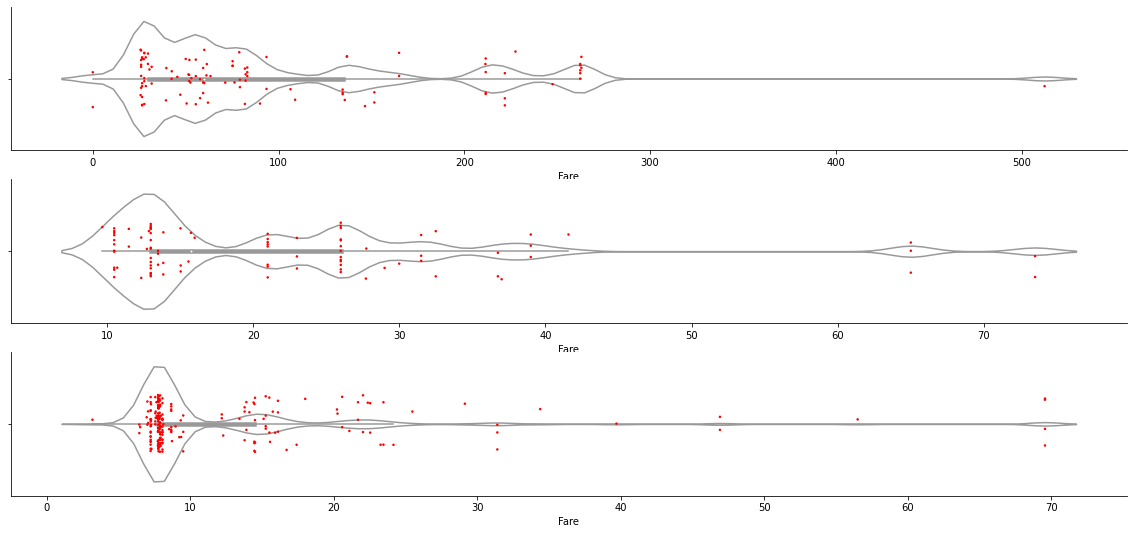

In [105]:
# *Show missing records to highlight that test has missing values in different columns to train:*
def _get_total_and_percentage_nans(df: pdf) -> pdf:
    total = df.isnull().sum().sort_values(ascending=False)
    # Note: `df.isnull().count()` simply used here to count total number of all rows (i.e. both True & False).
    percent = df.isnull().sum() / df.isnull().count() * 100
    percent = (round(percent, 1)).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', '%'])

def make_nan_stats_table(df_train: pdf, df_test: pdf) -> pdf:
    train_nan = _get_total_and_percentage_nans(df_train)
    test_nan = _get_total_and_percentage_nans(df_test)
    both = {'train': train_nan,'test': test_nan}
    table = pd.concat(both, axis=1)
    return table.sort_values(by=[('train', 'Total'), ('test', 'Total')], ascending=False, inplace=False)

test = read_ds('test')
table = make_nan_stats_table(df_train=train, df_test=test)
print(table.head())

# Would imputation of Fare be more accurate if performed according to another feature which correlates with it, namely `Pclass`. 
# Visualise to identify if Fare distribution per Pclass is different and also to see the distribution shape.
# The conclusion is that imputation according to the Pclass would be benefitial. Taking the median would be preferable to the mean as the 
# distribution is very skewed.
def visualise_horizontal_violinplots_per_pclass(df: pdf, sharex: bool, col_of_interest: str) -> None:
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=sharex, figsize=(20,9))
    sns.violinplot(x=col_of_interest, data=df[df.Pclass == 1], color='white', ax=ax1, bw=.1)
    sns.stripplot(x=col_of_interest, data=df[df.Pclass == 1],  color="red", jitter=0.2, size=2.5, ax=ax1)
    sns.violinplot(x=col_of_interest, data=df[df.Pclass == 2], color='white', ax=ax2, bw=.1)
    sns.stripplot(x=col_of_interest, data=df[df.Pclass == 2], color="red", jitter=0.2, size=2.5, ax=ax2)
    sns.violinplot(x=col_of_interest, data=df[df.Pclass == 3], color='white', ax=ax3, bw=.1)
    sns.stripplot(x=col_of_interest, data=df[df.Pclass == 3], color="red", jitter=0.2, size=2.5, ax=ax3)
    # ax3.set(xlim=(0,10))
    sns.despine()
    plt.show()
visualise_horizontal_violinplots_per_pclass(df=test, sharex=False, col_of_interest='Fare')

In [106]:
# As for train, I have pasted into this cell all transformations done (excluding visualisations) 
# which are otherwise spread over many cells above:
def impute_test_fare_with_median_per_pclass(test: pdf) -> pdf:
    fare_median_pclass = test.groupby('Pclass')['Fare'].agg(lambda x: pd.Series.median(x)).to_frame()
    fare_median_pclass.reset_index(level=0, inplace=True)
    for pclass in [1,2,3]:
        test.loc[(test.Pclass == pclass) & (test.Fare.isna()), 'Fare'] = int(fare_median_pclass.loc[fare_median_pclass.Pclass == pclass]['Fare'])
    return test

test = read_ds('test') # 1
test = impute_test_fare_with_median_per_pclass(test) # 2
X_test, _ = transform_ds(test) # 3-18

In [107]:
top_trained_models_and_feature_list.reset_index(inplace=True)
top_trained_models_and_feature_list.head(1)

,model_name,mean_metrics,features,trained_model
0,RFC_pof,80.69,"[Pclass, Age, SibSp, Parch, Fare, ticket_num, ...","(DecisionTreeClassifier(max_features='auto', r..."


In [108]:
def generate_predictions_per_model(top_trained_models_and_feature_list: pdf) -> pdf:
    Y_test_predictions, model_names = [], []
    for index, row in top_trained_models_and_feature_list.iterrows():
        _, X_test_scaled = scale(row.model_name, X_train, X_test)
        Y_test_preds = row.trained_model.predict(X_test_scaled[row.features])
        Y_test_predictions.append(Y_test_preds)
        model_names.append(row.model_name)
    preds_all_models = pd.DataFrame({'model_name': model_names, 'y_preds': Y_test_predictions})
    preds_all_models = pd.DataFrame(preds_all_models['y_preds'].to_list(), index=preds_all_models.model_name)
    # fig, ax = plt.subplots(figsize=(35, 3))
    # sns.heatmap(preds_all_models, ax=ax)
    # plt.show()
    return preds_all_models

def write_predictions_with_mean_of_models(preds_all_models: pdf, test: pdf) -> pdf:
    def mean_and_binary(row):
        row['Survived'] = 0 if row.mean() < 0.5 else 1
        return row
    preds_mean_of_models = preds_all_models.apply(mean_and_binary, axis=0)
    preds_mean_of_models = preds_mean_of_models.loc['Survived']
    submission = test[['PassengerId']].merge(preds_mean_of_models, left_index=True, right_index=True)
    submission.set_index('PassengerId', inplace=True)
    submission.to_csv('submission.csv') 
    return submission

def write_predictions_top_model(preds_all_models: pdf, test: pdf) -> pdf:  
    preds_all_models = preds_all_models.iloc[0]
    submission = test[['PassengerId']].merge(preds_all_models, left_index=True, right_index=True)
    submission.set_index('PassengerId', inplace=True)
    submission.rename(columns={submission.columns[0]: 'Survived'}, inplace=True)
    submission.to_csv('submission.csv') 
    return submission

preds_all_models = generate_predictions_per_model(top_trained_models_and_feature_list)
preds_all_models

,0,1,2,3,4,5,6,7,8,9,...,408,409,410,411,412,413,414,415,416,417
model_name,,,,,,,,,,,,,,,,,,,,,
RFC_pof,0,0,0,1,1,0,0,0,1,0,...,1,1,0,1,0,0,1,0,0,1
XGBC_pof,0,0,0,1,1,0,0,0,1,0,...,1,1,0,1,0,0,1,0,0,1
DTC_pof,0,0,0,0,1,0,1,0,1,0,...,1,0,1,1,0,0,1,1,0,0
LgRgn,0,1,0,0,1,0,1,0,1,0,...,1,1,1,1,1,0,1,0,0,1
LSVMC_l2,0,1,0,0,1,0,1,0,1,0,...,1,0,1,1,1,0,1,0,0,0
Ptrn_en,0,1,0,0,1,0,1,0,1,0,...,1,0,1,1,1,0,1,0,0,1
KNNC,0,0,0,0,1,0,0,0,1,0,...,1,1,1,1,0,0,1,0,0,1
SGDC_l2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
GNB,0,1,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,1,0,0,1


In [109]:
# submission = write_predictions_with_mean_of_models(preds_all_models, test)
submission = write_predictions_top_model(preds_all_models, test)
submission.head(10)

,Survived
PassengerId,
892,0
893,0
894,0
895,1
896,1
897,0
898,0
899,0
900,1
